In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 13 09:11:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   65C    P0    68W /  70W |   5727MiB / 15360MiB |     70%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys

In [ ]:
!{sys.executable} -m pip install evaluate==0.3.0
!{sys.executable} -m pip install gradio

In [ ]:
!{sys.executable} -m pip install ipywidgets

In [ ]:
!{sys.executable} -m jupyter nbextension enable --py widgetsnbextension

In [3]:
import numpy as np
import zipfile
import csv


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/home/ubuntu/lingWav2Vec/dataset.zip")
zip_ref.extractall("/home/ubuntu/lingWav2Vec")
zip_ref.close()

In [4]:
import os

In [ ]:
!{sys.executable} -m pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio===0.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html

- Installing/Updating Libraries


  ```
  sudo apt-get install liblzma-dev libbz2-dev libzstd-dev libsndfile1-dev libopenblas-dev libfftw3-dev libgflags-dev libgoogle-glog-dev
  sudo apt install build-essential cmake libboost-system-dev libboost-thread-dev libboost-program-options-dev libboost-test-dev libeigen3-dev zlib1g-dev libbz2-dev liblzma-dev ffmpeg

   pip install -r w2v_inference/requirements.txt

   pip install packaging soundfile swifter editdistance omegaconf
  ```

  

- Installing Fairseq

```
  git clone https://github.com/AI4Bharat/fairseq.git
  cd fairseq
  pip install --editable ./

  #[Optional for faster training]
  git clone https://github.com/NVIDIA/apex
  
  cd apex

  pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" \
  --global-option="--deprecated_fused_adam" --global-option="--xentropy" \
  --global-option="--fast_multihead_attn" ./
  
  cd ..
  ```

- Installing KenLM

  ```
  git clone https://github.com/kpu/kenlm.git
  cd kenlm
  mkdir -p build && cd build
  cmake .. 
  make -j 16
  cd ..
  export KENLM_ROOT=$PWD
  cd ..

- Installing Flashlight

  ```
  git clone https://github.com/flashlight/flashlight.git
  cd flashlight/bindings/python
  export USE_MKL=0
  python setup.py install
  ```


# Pretraining

###### Data preparation

- Step 1: Downloading Audio Dataset (Unlabelled)

In [ ]:
!{sys.executable} -m pip install joblib==1.2.0
!{sys.executable} -m pip install numpy==1.23.5
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pydub==0.25.1
!{sys.executable} -m pip install SoundFile==0.10.3.post1
!{sys.executable} -m pip install tqdm==4.61.1
!{sys.executable} -m pip install webrtcvad==2.0.10
!{sys.executable} -m pip install youtube-dl==2021.6.6
!{sys.executable} -m pip install yt-dlp

```
  bash dw_util.sh <path_to_urls> <data_store_path> <num_of_threads>
  ```
  The ```<data_store_path>``` refers to the location where the data will be downloaded. The ```<num_of_threads>``` can be used to control the parallelization.

In [ ]:
./home/ubuntu/lingWav2Vec/data_prep_scripts/pret_script/dw_util.sh /home/ubuntu/lingWav2Vec/data_prep_scripts/urls/lingala.txt /home/ubuntu/lingWav2Vec/data_prep_scripts/urls 8

- Step 2: Voiced Activity Detection

```
  python vad.py <data_read_dir> <data_write_dir> <folder_name>
  ```
  The ```<data_read_dir>``` is the root of downloaded files which contain downloaded data in language-named-folders.

  The ```<data_write_dir>``` is the location for saving the data after VAD step.

  The ```<folder_name>``` refers to the names of language-named-folder for which you want to perform this VAD step.

  *The reason why folder_name has been kept as a seperate entity is to allow parallelization because one can process multiple folders simultaneously.

- Step 3: SNR Filtering

```
  python snr.py <data_path> <folder/language_name>
  ```
  where the ```<data_path>``` refers to the root path containing all the audios in language specific folders. Here it refers to the``` <data_write_dir>``` from the previous step. The ```<folder/language_name>``` refers to name of language_specific folder for which snr_filtering needs to be done. The audio data that is rejected is moved in the folder **"snr_rejected"**, which is created automatically.

- Step 4: Chunking

  ```
  python chunking.py <chunking_path>
  ```
  All the audio files present in the ```<chunking_path>``` will be chunked and saved in the same location. The original files are **removed**.

Or alternatively users can use the one single script ```process_data.sh``` to run the entire pipeline
- Usage: ```bash process_data.sh </path/to/download> <num_of_threads>```
- The ```</path/to/download>``` refers to the location where the data will be downloaded.
- The ```<num_of_threads>``` can be used to control the parallelization.
- Please make sure that the relative path is urls directory is ```../urls``` from the script.

In [ ]:
!{sys.executable} -m pip install requests

In [ ]:
!{sys.executable} -m pip install multiprocess

In [ ]:
import requests
import time
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

In [ ]:
urls = ['https://www.radiookapi.net/sites/default/files/2022-10/101022-p-s-journalswahililundimatin_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/101022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web101022-p-a-d-journalkikongosoir-0_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/10102022_-p-s-journalswahililundisoirparfloridakahambu-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web101022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/111022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/11102022_-p-s-journalswahilimardimatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web111022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/111022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/11102022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/111102022_-_p-s-journalswahilimardisoir_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web111022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/121022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/12102022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web12102022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/12102022-p-s-journalswahilimercredimatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/60092022-p-a-d-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web071022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/70092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-s-kinjournalswahilimatingraceamzati-00_web__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/70092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web071022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-s-kinjournalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web101022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/10102022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web101022-p-a-d-journalkikongomatin-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web051022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/50092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/05102022-a-f-journalfrancaismatin06h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/051022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/051022-p-a-d-journalkikongosoir-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/50092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/051022-p-s-kinjournalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/061022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/60092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web061022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/05102022-a-f-journalfrancaissoir18h00-00_2le_bon_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/061022-p-t-journal_tshiluba_matin_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/061022-p-s-kinjournalswahilisoir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web061022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/03102022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web031022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/031022-p-t-journal_tshiluba_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/031022-p-s-kinjournalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web300922-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/30092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/041022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/40092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web041022-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/web041022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/041022-journalswahilisoirh00-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/041022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web28092022_-p-a-djournal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/29092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web290922-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/290922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/300922-p-t-journal_tshiluba_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/29092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web290922-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web300922-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/260922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web260922-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/270922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/26092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/27092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web270922-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/270922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/280922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web270922-p-a-d-journalkikongosoir-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/27092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/28092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web280922-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/280922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/28092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/290922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/22092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web22092022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/230922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web230922-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/230922-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/23092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web230922-p-a-djournalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/26092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web260922-p-a-d-journalkikongomatin-01__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web21092022-p-a-djournalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/220922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/21092022-p-a-d-journallinglasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web22092022-p-a-djournalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/22092022-p-a-d-journallinglamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/220922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/19092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web19092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/190922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web19092022-p-a-d-journalkikongosoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/200922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/19092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web20092022-p-a-djournalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/20092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/200922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/20092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/210922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web20092022-p-a-djournalkikongosoir-01_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/21092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/210922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/150922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web15092022-p-a-d-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/15092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/160922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/16092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web16092022-p-a-d-journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/160922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/16092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web16092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/120922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/12092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web12092022-p-a-d-journalkikongosoir-0b.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/130922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/13092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web13092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/130922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/13092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web13092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/140922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web14092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/14092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/140922-p-t-journal_tshiluba_soir_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web14092022-p-a-d-journalkikongosoir-0b.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/14092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/150922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/15092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web15092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web07092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/070922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web07092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/080922-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/07092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/08092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web08092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web08092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web09092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web09092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web12092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/050922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/05092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web05092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/050922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web05092022-p-a-d-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/05092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/060922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web06092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/06092022-p-a-d-journallingalamatin-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/060922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/070922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web06092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/06092022-p-a-d-journallinglasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/07092022-p-a-d-journallinglamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web01092022-p-a-d-journalswahilisoir-0_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/020922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web02092022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/01092022-p-a-d-journallingalasoir-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/01092022-p-a-d-journalkikongosoir-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/020922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web02092022-p-a-d-journalswahilisoir-0b_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/web02092022-p-a-d-journalswahilisoir-0b_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web31082022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web31082022-p-a-d-journalswahilsoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/010922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/010822-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web01092022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalasoir-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/010822-p-a-d-journallingalasoir-00_tres_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/010922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/29082022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web29082022-p-a-d-journallingalmatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web29082022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web30082022-p-a-d-journalswahilimatinr-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web30082022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/24082022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/240822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/24082022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/25082022-p-sw-journalswahilijeudimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/25082022-p-sw-journalswahilijeudisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/260822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/26082022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/26082022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/260822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/260822-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/22082022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/22082022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/230822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/230822-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/23082022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/230822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/240822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/23082022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/23082022-p-a-d-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/23082022-p-sw-journalswahilimardisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/180822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/180822-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/190822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/190822-p-a-d-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-sw-journalswahilivendredisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/190822-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-l-journallingalamatin-wweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/160822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/170822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-c-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/170822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/180822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-a-d-k-journalkikongomatin-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/150822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/150822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/160822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-sw-journalswahilimardiimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-c-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web10082022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/110822-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/112022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web11082022-p-a-d-journalswahilimatinr-0_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/10082022-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/11082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web11082022-p-a-d-journalswahilisoir-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/112022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/122022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web12082022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/11082022-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/1282022-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/120822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/122022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/082022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/090822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web09082022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/092022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web09082022-p-a-d-journalswahilisoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/090822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/100822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/102022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-l-journallingalasoir-00web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web10082022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-l-journallingalasoir-00web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/100822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/102022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/05082022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web05082022-p-a-d-journalswahilmatin-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/050822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web05082022-p-a-d-journalswahilsoir01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/05082022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/080822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-a-d-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web08082022-p-a-d-journalswahilimatin-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web08082022-p-a-d-journalswahilisoir-0b_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/080822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/02082022-p-a-d-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/030822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web03082022-p-a-d-journalswahilimatinr-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/03082022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/03082022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web03082022-p-a-d-journalswahilisoir-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/04082022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/030822-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/040822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web04082022-p-a-d-journalswahilimatin-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/040822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/050822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/04082022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web04082022-p-a-d-journalswahilsoir-01__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web29072022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web29072022-p-a-d-journalswahilisoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web29072022-p-a-djournalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/020822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web02082022-p-a-d-journalswahilimatinr-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/0200822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web02082022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/260722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web26072022-p-a-d-journalswahilimatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/260722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web26072022-p-a-d-journalswahilisoir-0_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/270722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web27072022-p-a-djournalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/27072022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/270722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web27072022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/280722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web28072022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/280722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web28072022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/2207022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web220722-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/22072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/220722-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/220722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/250722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/25072022-p-a-d-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web25072022_-_p-a-djournalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web250722-p-a-d-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/250722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/2007022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/200722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/210722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web200722-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web210722-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/20072022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/20072022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/21072022-p-a-d-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/21072022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/21072022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web210722-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/210722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/22072022-p-sw-journalswahilivendredimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/220722-p-t-_journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/21072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web220722-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web18072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/180722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/18072022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/190722-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/190722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/18072022-p-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/19072022-p-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web190722p-s-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/190722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/19072022-p-sw-journalswahilimardisoir19072022.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/200722-p-t-journal_tshiluba_matin_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/20072022-p-sw-journalswahilimercredimatin.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web19072022-p-a-d-journallingalasoir-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/_19072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web20072022-p-a-d-journallingalamatin-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/20072022-p-a-d-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/15072022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1507022-p-k-journal_kikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web15072022-p-a-d-journallingalasoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/15062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/150722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/15072022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web180722p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/180722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1807022-p-k-journal_kikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1307022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/130722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/13072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web13072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web14072022p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/13072022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/14072022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1407022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/140722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/14072022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web14072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/150722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/14072022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web15072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/110722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1107022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/110722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/11072022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/11072022-p-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/12072022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web11072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/120722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web12072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/1207022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/12072022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web12062022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/12072022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web13072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/13072022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/080722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08972022-p-sw-journalswahilivendfredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-k-p-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/080722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/11072022-p-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/0507022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/05072022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/050722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/06072022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/060722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/0607022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/060722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/06072022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/070722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/06072022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-sw-journalswahilijeudimatinbrut-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/06072022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/0707022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/070722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/040722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/0407022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/040722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/04072022-p-sw-bonjournalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/050722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/05072022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/27062022-p-sw-journallundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-sw-journalmardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2806022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/280622-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-sw-journalswahilimardisoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/290622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2906022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-sw-journalmercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/290622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/240622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-sw-journalvendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/270622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2706022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/270622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/27062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/27062022-p-l-journallingalasoir-wweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/280622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2206022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/220622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/22062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/230622-p-t-journal_tshiluba_matin_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2306022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/23062022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/230622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/23062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/240622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/23062022-p-sw-journaljeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-sw-journalvendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2406022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/200622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/20062022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2006022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/200622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/210622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/20062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/2106022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/210622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/21062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/220622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/1606022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/16062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/16062022-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/160622-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/160622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/170622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/170622-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/1706022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/170622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/17062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/17062022-p-s-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/17062022-p-s-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web13062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/13062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web14062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/1406022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/14062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/140622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web14062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/150622-p-t-journal_tshiluba_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web15062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/1506022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/150622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web15062022-p-a-d-journalswahilisoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/160622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web16062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/10062022-p-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web10062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web10062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/100622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/10062022-p-k-journalkikongo-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/130622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web13062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/1306022-p-k-journalkikongomatin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/130622-p-t-jouranl_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/07062022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/080622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0806022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web08062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/080622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/08062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/090622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web09062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0906022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/090622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web09062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/09062022-p-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/09062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/10062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/100622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web03062022-a_s-journalswahilisoir-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/06062022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web06062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0606022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web06062022-p-a-d-journal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0606-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/06062022-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/070622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web07062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0706022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web_07062022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/07062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/02062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/02062022-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web01062022-p-a-djournalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web02062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0206022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/020622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web_02062022-p-a-d-journal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/02062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/030622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/web03062022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0306022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/030622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/03062022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31052022-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web31052022-p-a-d-journal_swahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/3105022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/3105052022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web31052022-p-a-djournal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web01062022-p-a-djournalswahilmatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31012022-p-t-journaltshilubasoirweb_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/010622-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/01062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/0106022-p-kjournalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/01062022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/01062022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/01062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/26052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/27052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web27052022journal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web27052022journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web30052022journalswahilimatin_-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/3005022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_30052022-p-a-d-journal_swahili_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web24052022-p-a-d-journalswahilsoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/25052022-p-a-d-journalswahilmatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/24052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/25052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web25052022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web26052022-p-a-d-journalswahilmatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/25052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/26052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web26052022-p-a-d-journalswahisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/27052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web27052022-p-a-d-journalswahimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_20052022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/20052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web23052022-p-a-d-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-ll-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web20052022-p-a-d-journalswahilsoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_24052022-p-a-d-journalswahilimatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_24052022-p-a-d-journalswahilimatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/24052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_17052022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-k-journalkijkongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web18052022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/19052022-p-k-journalkikongomatinbon-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_18052022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_19052022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web19052022-p-a-d-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web20052022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/19052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/20052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/200522-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/13052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web_13052022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/13052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/16052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web16052022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/16052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web17052022-p-a-djournalswahilimatinr-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/16052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web11052022-p-a-d-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/12052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web12052022-p-a-djournalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/12052022-p-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web12052022-p-a-djournalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/13052022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/13052022-p-a-djournalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/06052022-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-sw-journallundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-sw-journallundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-sw-journalmardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web10052022-p-a-d-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/0405022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/04052022-p-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/04052022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/04052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-l-journallingalmatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/0505022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/0505202022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/06052022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/0605022-p-kjjournalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/06052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/06052022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2904022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/29042022-p-sw-journalswahilivendredisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_29042022-p-a-d-journalkikongosoir-01_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/04052022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2704022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web27042022-p-a-d-journal_kikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2804022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web28042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/29042022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/29042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/24042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2504022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_25042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/250422-p-sw-journalswahillundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/26042022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/25042022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/26042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2604022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/26042022-p-l-journallingalasoirbon-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/_web_26042022-p-a-djournalk.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/260422-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2104022-p-kjournalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_21042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2204022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_22042022-p-a-d-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web18042021-p-a-d-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1804022-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042021-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042022journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1904022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042022-p-sw-journaswahilimmardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web19042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-sw-journalswahilimercredimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/2004022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_20042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_14042022-p-a-djournalkikongo00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/15042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/15042022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1504022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/15042022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web15042022-p-a-djournalkikongo00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/18042022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/18042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1804022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/18042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_12042022-p-a-djournalkikongo00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1304022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_13042022-p-a-djournalkikongo00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-sw-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1404022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1104022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_11042022-p-a-djournalkikongo00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/1204022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/070422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/07042022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/0704022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/070422-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/07042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_07042022-p-a-d-journalkikongo_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/080422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/07042022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/0804022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/080422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-sw-journalswahilivendredisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web08042022-p-a-d-journalkikongo-soir-_00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/04042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/05042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/05042022-p-sw-journalswahilimardimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/0504022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/050422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web_05042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/060422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/05042022-p-sw-journalswahilimardisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/06042022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/0604022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/060422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web06042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/06042022-p-sw-journalswahilumercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/010422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web01042022p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web01042022p-a-d-journalkikongosoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/01042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/040422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/04042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/0404022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/040422-p-t-journal_tshiluba_soir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/04042022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/web04042022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/050422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web3003p-a-d-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/310322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-lk-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/3103022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/310322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web31032022-p-a-d-journal_kikongo_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/010422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/01042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-sw-swahilisoirjeudi17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/01042022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/01042022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/01042022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/290322-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2903022-p-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/290322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/_web29032022p-a-d-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/29032022-p-l-journalingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/30032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/290322-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/300322-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/300322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/3003022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/300322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/30032022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/30032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/25032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web_25032022-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/28032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2803022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-s-journalswahililundimatinparfloridkahambu.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/28032022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web28032022p-a-d-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032022-p-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web23032022-p-a-d-_journal_kikongo_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032022-p-sw-journalswahilimercresoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/24032022-p-sw-journalswahilijeudimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032020-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/24032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2403022-p-k-journalkikongomatin-00_b.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2403022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web24032022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2503022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/24032022-p-l-journallingalasoir-00web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/25032022-p-l-journallingalamatin-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2503022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/210322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/21032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/21032022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web21032022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/220322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-l-jjournallingalamatin-00.web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2203022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/21032022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/220322-p-t-journal_tshiluba_soir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web22032022-p-a-d-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/230322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032022-p-sw-journalswahilimercredimatinr-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-l-jjournallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032022journallingalamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/18032022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web18032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1803022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/18032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/180322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/18032022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web18032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/210322-p-t-journal_tshiluba_matin_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/2103022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web16032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1603022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/160322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/16032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web16032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/16032022-p-sw-journalswahilimercredisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/170322-p-t-journal_tshiluba_matin_web_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/17032022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web17032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1703022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/170322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web17032022-p-a-d-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/17032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/180322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/17032022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/140322-p-s-journalswahililundimatinparfloridakahambu-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/140322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/14032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/14032022-p-sw-journalswahililundisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web14032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/150322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/15032022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web15032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1503022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/150322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/15032022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web15032022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/15032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/160322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/16032022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web11032022-p-a-d-journallingala_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1103022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/11032022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/110322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/11032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web11032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/140322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web140322-p-a-djournallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1403022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/09032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/090322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web09032022-p-a-d-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/09032022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/100322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/10032022-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web10032022-p-a-d-journallingala_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/1003022-p-k-journalkikongomatin-00_bon_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/10032022-p-journalswahilijeudisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/100322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/10032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/110322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/11032022-p-journalswahilivendredimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web10032022-p-a-d-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web07032022-p-a-d-journallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/07032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/07032022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/08032022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/080322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web08032022-p-a-d-journallingala_matin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0803022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/080322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/08032022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/08032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web08032022-p-a-d-journallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/090322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/09032022-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web09032022-p-a-d-journallingala_matin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0903022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/03032022-p-s-journalswahili_jeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/040322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/04032022-p-sw-journalswahilivendredimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web04032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0403022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/04032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/040322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/04032022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web04032022-p-a-djournallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/070322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web07032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0703022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/070322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/020322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web02032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/02032022-p-sw-journalswahili_mercredi_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0203022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/02032022-p-sw-journalswahili_mercredi_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web02032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/020322-p-t-journal_tshiluba_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/02032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/03032022-p-sw-journalswahili_jeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/030322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web03032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0303022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/030322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/03032022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web03032022-pad-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web28022022-p-a-d-journallingalamatin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/28022022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2802022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/280222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/28022022-p-sw-journalswahili_lundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web28022022-p-a-djournallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/010322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/01032022-p-sw-journalswahili_mardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_01032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/0103022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/010322-p-t-journal_tshiluiba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web01032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/01032022-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/01032022-p-sw-journalswahili_mardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/240222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/24022022-p-sw-journalswahili_jeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web24022022p-a-d-journalingalamatin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2402022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/240222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/24022022-p-sw-journalswahili_jeudisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/24022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web24022022p-a-d-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/250222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/25022022-p-sw-journalswahili_vendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web25022022p-a-d-journalingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2502022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/25022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2202022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/22022022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/22022022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/220222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/22020222-p-k-journalkikongosoirbon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web22022022_p-a-djournallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/230222-p-t-journal_tshiluba_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/23022022-p-sw-journalswahili_mercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web23022022_p-a-djournallingalam-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2302022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/230222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/23022022-p-sw-journalswahili_mercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/23022022-p-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web23022022p-a-d-journalingalasoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/18022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web21022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/2102022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/210222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/21022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web21022022p-a-djournal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/220222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/21022022-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/22022022-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web22022022p-a-djournal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022022-p-sw-journalswahili_mercredimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/17022022-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/17022022-p-sw-journalswjeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web17022022-p-a-djournallingalamatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/1702022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/17022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/17022022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/18022022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/1802022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/18022022-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web18022022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/14022022-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/150222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web15022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/150202-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/150222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web15022022-p-a-d-journallingalasoir-00-.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/15022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/160222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web16022022-p-a-d_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/15022022-p-sw-journalswahili_mardisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022022-p-sw-journalswahili_mercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web16022022-p-a-_d_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/110222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web11022022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/11022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web11022022-p-a-d-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web14022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/1402022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/140222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web14022022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web090222-p-a-djournallingalasoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/100222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/09022022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/100222-p-sw-journalswahilijeudimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web100222p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/1002022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/100222-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_100222-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web100222p-a-d-journalingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/10022022-p-t-journaltshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/110222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web110222-p-a-djournalingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/1102022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/070222-p-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-p-t-_journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web080222-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/07022022-p-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0802022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/_web_080222-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/08022022-p-sw-journalswahilimardisoirfb-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-sw-journalswahilimatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web090222-p-a-djournallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0902022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web04022022_p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0402022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-sw-journalvendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_040222-_p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/040222-p-k-_journalkikongosoir-_00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web070222-p-a-d-journallingalamatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/07022022-p-sw-journalswahililundimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0702022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web070222-p-a-d-journallingalasoir-00__1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/07022022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/02022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/02022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_02022022p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/02022022-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/030222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web03022022p-a-p-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/03022022-p-sw-journalswahilijeudimatinjdk-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0302022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/03022022-p-t-journal_tshiluba_soir-le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web03022022p-a-djournallingalasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/03022022-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/03022022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/31012022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/31012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_31012022journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/010222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/01022022-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web01022022journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0102022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/010222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web01022022_p-a-djournallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/01022022-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/020222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/01022022-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/02022022-p-sw-journalswahilimercredimatinr-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web02022022p-a-djournallingalamatin.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/0202022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_28012022-p-a-d-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2801022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/280122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web28012022-p-a-djournalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web310222_p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/3101022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_31012022-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/260122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/270122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net//sites/default/files/2022-01/web_26012022-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/26012022-p-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web27012022jjournal_swahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/26012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2701022-p-k-journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/27012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/270122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/27012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web27012022-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/27012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/280122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/240122-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web_24012022-pad-journal_swahili_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/24012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2401022-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/250122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web25012022journal_swahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/26012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/260122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web25012022-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-k-journal_kikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web_26012022jjournal_swahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2601022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web21012022-p-a-d_journalswahili-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/21012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2101022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_210122-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/21012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web_21012022-p-a-d_journalswahilisoi1-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/2101022-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/24012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/24012022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web19012022-p-a-d_journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web19012022-p-a-d_journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/190122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/200122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-k-p-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_20012022-p-a-d_journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/200122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web20012022-p-a-d_journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/210122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/180122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web18012022journalswahilimatin_-p-a-d-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18012022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/180122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_18012022-p-a-d_journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18812022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/190122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/12012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/1301022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/12012022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/130122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web_13012022-p-a-d-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/13012022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/140122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/13012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web14012022-p-a-d-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/14012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/1401022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web14012022journalswahilisoir_-p-a-d-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/140122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/14012022-p-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/1101022-p-k-journal_kikongo_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/110122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/11012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/120122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_web_12012022-p-a-d-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/1201022-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/120122-p-t-journaltshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web12012022-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/12012022-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/130122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_13012022-p-a-d-journalswahilimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/100122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web10012022-p-a-d-journal_swahilimatinr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/1001022-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_10012022-p-a-d-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/100122-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/110122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_11012022-p-a-d-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/15122021-p-sw-journalswahilimercredisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/16122021-p-sw-journalswahilijeudimatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/1612021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web16122021journal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_16122021-p-a-d-journal_kikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_17122021-p-a-d-journal_swahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/17122021-p-k-journalkikongomatin-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web17122021-p-a-d-journal_kikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_131221-_journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/13122021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/13122021-p-sw-journalswahililundisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/14122021-p-sw-journalswahilimardimatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/131221-p-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/1412021-p-k-journal_kikongo_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-t-journaltshiluba_soirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/151221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/14122021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/15122021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web141221-_journalkikongo-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/1512021-p-k-journalkikongo_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web15122021-p-a-d-journal_kikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/151221-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_09122021_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/091221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/1012021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/101221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-sw-journalswahilivendredisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web101221-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/13122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/1312021-p-k-journalkikongo_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/08122021-p-l-_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0812021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/081221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/08122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_08122021_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/091221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/08122021-a-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0912021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-a-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-t-_journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-l-_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/071221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/web_07122021_journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0712021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0112021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/011221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/021221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/01122021-p-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/01122021-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/02122021-p-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0212021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/021221-p-t-journal_tshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/02122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/03122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/031221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/02122021-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/0312021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/031221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/031221-p-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/03122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/2911021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/291121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web29112021journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/301121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web_30112021journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/29112021-p-l-journallingalasoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/29112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/30112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/3011021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_30112021journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/301121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/011221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web01122021jo-urnal_swahili_matin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/30112021-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/30112021-p-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/2511021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/251121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web25112021journalswahilsoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/25112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/261121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web26112021journalswahilimatin00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/25112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/261121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_26112021journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_23112021journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/2311021-p-k-journalkikongomatin-00_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web23112021journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/231121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/241121-p-t-journaltshilubamatinwebbon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/23112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web24112021journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/2411021-p-k-journalkikongomatin-00_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/24112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_24112021journalswahilisoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/241121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/251121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/24112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web25112021journalswahilimatin00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/242112021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/252112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/19112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/19112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web22112021journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web22112021journalswahilimatin-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/22112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/2211021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/221121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web_22112021journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/22112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/23112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/22112021-p-k-journalkikongosoir_-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/231121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web18112021_journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/18112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1811021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/181121-p-t-journal_tshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/18112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/191121-p-t-journaltshiluba_matinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/18112021-p-k-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_18112021_journalswahilisoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web19112021_journalswahilimatinr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1911021-p-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/19112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/191121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web19112021journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/16112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web16112021_journalswhahili_matin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/161121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web16112021journalsawhilisoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/16112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/171121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/16112021-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_17112021journalswahilimatin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1711021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web17112021-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/181121-p-t-journaltshiluba_matinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-k-_journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1211021-p-k-_journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-l-journallingalaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/121121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-sw-journalswahilivendredisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web_12112021journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web15112021journaswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/15112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1511021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/151121-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_15112021_journalshawilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/161121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_16112021_journalswhahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/15112021-p-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/15112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1011021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/101121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-sw-journalswahilimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web10112021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/111121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/1111021-p-k-journalkikongo_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/111121-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-sw-journalswahilijeudisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/121121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_11112021journalkikongo-b_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-sw-journalswahililundisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-sw-journalswahililundisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_08112021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/091121-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-l-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/09112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/0911021-p-k-journal_kikongomatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/091121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/101121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_09112021journalkikongosoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/09112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/09112021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/05112021-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_04112021journalkikongosoi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_05112021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/05112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/051112-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/051112-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_05112021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/05112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/081121-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/021121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/021121-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/031121-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_02112021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/02112021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/031121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/03112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_03112021journalkikongomat-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/031121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/03112021-p-sw-journlswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_03112021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/03112021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/041121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web_04112021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/011121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_01112021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/01112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/011121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_01112021journalkikongos-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/021121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/01112021-_p-sw-journalswahililundisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/_web_02112021journalkikongomatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/01112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/02112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-l-journallingalamatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_281021-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/281021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_28102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-f-sw-journalswahilijeudisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/29102021-p-f-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/291021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_29102021journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/29102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/291021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/291021_p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_29102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/29102021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_26102021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/26102021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/261021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_26102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/26102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_271021-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/271021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web_27102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-sw-journalswahilimercredisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-f-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/281021-p-t-journal_tshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_25102021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/251021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021-p-sw-journalswahililunsdisoie-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/26102021-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/w_eb_25102021journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/261021-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web_21102021journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/21102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/211021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_21102021journalkikongosoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/221021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_22102021journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/21102021-p-sw-journaswahilijeudisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-sw-journalswahilivendredimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-sw-journavendredisoirswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_22102021journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/181021-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/19102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_19102021-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/19102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web191021journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/201021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-sw-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_20102021journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/201021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_20102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/211021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/151021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_15102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/15102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/18102021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/181021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web18102021journalkikongomatin-.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/181021-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web18102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/18102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web13102021-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/14102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_14102021-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-sw-journalswahilijeudimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_14102021-journal_kikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/14102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/151021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_15102021-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/15102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/151021-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/121021-p-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/11102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_11102021-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/12102021-p-l-journallingalamatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/121021-p-t-journaltshilubasoir_web-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/12102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_12102021journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/12102021-a-f-journaswahilimardisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/131021-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/13102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/13102021-s-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/131021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/13102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/080102021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/081021-p-t-journal-tshiluba-pad-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web_08102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/111021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/11102021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/11010021-p-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/111021-p-sw-journalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/121021-p-sw-journalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/111021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/journal_swahili_jdk_soir_mercredi_06102021.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-sw-journalswahilijeudimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/061021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/071021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/06102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_06102021-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/071021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-sw-journalswahilijeudisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_07102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/081021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-l-journalingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-sw-journalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/041021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/04102021-p-l-journallingalsoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web_04102021_journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/051021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021-p-l-journallingalmatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/web_05102021journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/051021-p-sw-journalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/061021-p-sw-journalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/061021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/06102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/06102021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/011021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/30092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/01102021-p-l-journallingalamatinr-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/0110021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/011021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/01102021-a-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/01102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/_web_01102021-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/04102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/041021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/29092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/29092021-p-k-journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/290921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/journal_swahili_soir_lundi.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_290921-journalkikongosoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/29092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/30092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/300921-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/30092021-p-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/300921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/300921-p-sw-journalswahilisoirjeudjdki-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/011021-p-sw-journalswahilivendredimatinjdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_30092021-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/270921-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/270921-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/web_270921-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/280921-p-t-journaltshilubawebmatin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-a-f-journaswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/28092021-p-k-journalkikongomatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/280921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/280921-a-f-journaswahilisoir-lebon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_280921-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/290921-p-t-journaltshilubaweb_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/28092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/290921-p-s-journalswahilimatin-00lebon_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/230921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/23092021-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_23902021journalkikongosoir_-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/23092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/240921-p-t-journaltshilubawebmatin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/24092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/240921-p-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/24092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_24092021_journalkikongosoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/24092021-p-sw-journalswahilivendredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/21902021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/21092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_21902021journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/210921-p-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/220921-p-t-journaltshilubawed.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/web_22092021-_journal_kikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-t-journaltshilubawebsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/230921-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-sw-journalswahilimercredisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/23092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/web16092021-journalkikongosoirb_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/16092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/17092021-p-s-journalswahili-matin_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170921-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170092021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/17092021-a-s-_journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_17092021-journal_kikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20092021-l-p-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/swahili_journal_lundi_soir_et_mardi_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20902021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_20092021journalkiksoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/210921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_14092021-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-p-l-journallingalmatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-sw-webjournalswahilimardisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/150921-p-sw-webjournalswahilimercredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/150921-p-t-journal_tshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-p-l-journallingalsoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web15092021journalkikongs-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/160921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/16092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/16092021-p-s-journalswahili-matin_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/160921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-sw-webjournalswahilivendredisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_10092021-journalkikongosoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/10092021-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/13092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/130921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_13092021-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/13092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-sw-webjournalswahilimardimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/13092021-p-sw-webjournalswahililundisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/140921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/080921-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web1_08092021-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/08092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/08092021-p-sw-webjournalswahilimercredisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-p-l-journallingalmatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/090921-p-sw-web-journalswahilijeudimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/090921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/web_09092021journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-l-p-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-sw-webjournalswahilivendredimatin-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/10092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/060921-p-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/06092021-psw-webjournalswahilimardimatin-jdk-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/06092021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/07092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/internet-06092021-journalkikongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/070921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/070921-p-t-journaltshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/07092021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_a07092021journalkikongos.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/06092021-psw-webjournalswahilimardimatin-jdk-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/08092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/080921-p-t-journal-tshiluba-matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/31082021-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/010921-p-t-journal_tshiluba_de_ce_mercredi_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/020921-p-t-journal_tshiluba_jeudi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/01092021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/02092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/01092021-a-s-journalswahilisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/02092021-p-s-journalswahilisoir-00_1.1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/020921-p-t-journal_tshiluba_de_ce_jeudi_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/030921-p-t-journal_tshiluba_de_ce_vendredi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/03092021-p-t-_journal_soir_veebdredi.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/030921-p-sw-webjournalswahilivendredimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/26082021-p-l-journallingalasoir_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/26082021-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/27082021-l-p-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/27082023-p-k-journal_kikongo_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/30082021-p-t-journaltshilubasoir-le_bon_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/31082021-p-t-journaltshiluba_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/30082021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/310821-p-t-journal_tshiluba_de_ce_mardi_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/010921-p-t-journal_tshiluba_de_ce_mercredi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/31082021-p-l-journal_lingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/01092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021-p-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/19082021-p-t-_journaltshiluba_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/19082021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/23082021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/23082021-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/240821-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/240821-p-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/25082021-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/16082021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/17082021-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021_-p-t-journaltshiluba_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/05052020-a-f-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/06052020-a-f-journaltshilubasoir00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/06052020-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/06052020-a-f-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/07052020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/07052020-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/30042020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/30042020-p-l-journalalingalasoir.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/04052020-a-f-journaltshilubasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/04052020-p-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/04052020-a-f-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/05052020-a-f-journaltshilubasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/05052020-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/24042020-a-f-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/27042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/27042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/27042020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/28042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/28042020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/29042020-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/29042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/29042020-a-k-journalkikongosoir18h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/200420-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/20042020-a-k-journalkikongosoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/21042020-p-l-journallingalasoir-00.mp3web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/21042020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/21042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-p-l-journallingala-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-a-f-journaltshiluba-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-a-f-journalkikono-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/23042020-a-f-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/23042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/23042020-a-f-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/24042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/24042020-a-f-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/14042020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/16042020-a-t-journaltshilubasoir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/16042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/170420-p-l-journallingalasoir-00.mp3webbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/17042020-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/17042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/20042020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/08042020-a-t-journatshilubasoir00-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/08042020-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/08042020-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/09042020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/090420-a-l-journallingalasoir-00_.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/09042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/10042020-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/10042020-p-l-journallingalasoir.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/13042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/14042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/140420-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/06042020-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/06042020-a-t-journaltshilubasoir17h15-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/06042020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/07042020-a-t-journatshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/07042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/07042020-a-f-journakikongo00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-a-t-journaltshilubasoir-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/25032020-s-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/25032020-s-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/25032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-a-s-journalswahilisoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-p-l-journallingalasoir-00.mp3wwwwwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-s-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-s-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-s-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/19032020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/19032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/19032020-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-p-l-journallingalasoir-00.mp3_webbbbbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-p-l-journallingala-00.mp3webbbbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-l-journallingalasoir-00_.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/03032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/03032020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/03032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-p-l-journallingalaweb_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/26022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/26022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/26022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/21022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/21022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/25022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/25022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/25022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/19022020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-t-journaltshilubasoir17h30-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/19022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/19022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/21022020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/140220-p-t-_journal_tshiluba_17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/14022020_-a-l-journallingala_soir00-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/14022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/14022020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-t-journaltshilubasoir17h30web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-t-journal_swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-s-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/07022020-s-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/07022020-a-t-journaltshilubasoir17h15-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/07022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-k-journalkikongosoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/03022020-s-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/03022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/04022020-s-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/04022020-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/04022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-s-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/28012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/28012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/28012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/29012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/29012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/29012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/30012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/30012020-a-s-journalswahilisoir-00_2_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/30012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/31012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/31012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/22012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/23012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/23012020-a-s-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/23012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/24012020-a-s-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/24012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/27012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/27012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/27012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/16012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/17012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/17012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/20012020-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/20012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/20012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/21012020-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/21012020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/21012020-a-s-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/22012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/22012020-a-s-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/10012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/10012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/13012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/13012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/13012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/14012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/14012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/14012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/15012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/15012020-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/15012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/16012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-t-journatshilubasoirl-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-t-journatshilubasoirl-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-k-journalkikongosoirl-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/06012020-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/06012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/06012020p-d-journal_kikongo_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/_06012020-p-d-journal_lingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/26122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/26122019-a-t-journaltshilubasoir-le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/26122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/27122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/27122019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/30122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/30122019-a-k-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/19122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/20122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/20122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/23122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/23122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/23122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/241219-p-t-journal_tshiluba_le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/24122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/241219-p-d-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/16122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/16122019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/16122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/17122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/18122019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/18122019-a-k-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-s-journalswahilisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/02122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/02122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/27112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/27112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/27112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/28112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/28112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/28112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/29112019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/29112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/29112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/02122019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/02122019-a-t-journalswahilitshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/21112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/22112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/22112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/25112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/25112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/25112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/26112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/26112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/26112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/19112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/19112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/20112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/20112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/20112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/21112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/21112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-k-journalkikongosoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/08112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/08112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-t-journaltshilubasoir17h30web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3vvv.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/08112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-k-journalkikongosoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-l-journallingalaisoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/24102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/24102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-s-journaswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/21102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/21102019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/21102019-a-l-journalikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/16102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/16102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/16102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/14102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/14102019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/14102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/03102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/07102019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/07102019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/07102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-s-journalswahilisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-l-journallingalasoir-00.mp3web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/03102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/03102019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/27092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/27092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/27092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-s-journaswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-k-journalkikiongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/20092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/20092019-a-k-journalkikiongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/20092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-k-journalkikiongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-k-journalkikiongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-k-journalkikiongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/06092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/06092019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/06092019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/02092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/02092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/02092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/03092019-a-s-journalswahilusoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/03092019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/03092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/27082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/29082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/27082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/27082019-a-l-journallingalaisoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/28082019-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/28082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/28082019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/29082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/29082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/22082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/22082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/23082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/23082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/23082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/26082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/26082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/26082019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/19082019-a-s-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/19082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/19082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/20082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/20082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/20082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/21082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/21082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/21082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/22082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/14082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/14082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/14082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/15082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/15082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/15082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/16082019-a-s-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/16082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/12082019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/12082019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/12082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/13_08_2019_bunia_i_frpi_demande_pardon_en_swahili.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/13082019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/13082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/07082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/07082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/07082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/02082019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/02082019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-t-journaltshilubasoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/3107019-p-k-journalparlekikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/31072019-s-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/31072019-s-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_25072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/26072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/26072019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_26072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/22072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/22072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/23072019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/23072019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_23072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/24072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/24072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/25072019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/25072019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/17072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/17072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-k-journalkiongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/19072019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/19072019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/12072019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/12072019-a-k-journalkikongosoir18h30-000_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/15072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/15072019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/16072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/16072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/08072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/08072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/08072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/10072019-a-t-journaltshilubasoir17h15_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/10072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/11072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/03072019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/03072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/03072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/04072019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/04072019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/04072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/080719-a-s-journalswahilisoir-17h-00-00_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/28062019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/01072019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/01072019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_01072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-t-journaltshilubasoir17h15-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/25062019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/26062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/26062019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/26062019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/27062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/28062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/28062019-a-t-journaltshilubasoirweb_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_28062019-a-l-journallinalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/21062019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/21062019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/21062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/24062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/24062019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/24062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/25062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/25062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_10062019-a-l-journallingalasoir18h45-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_17062019-a-l-_journallingala18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_17062019-a-l-_journallingala18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/18062019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_18062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/19062019-a-s-journalswahilisoir17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/19062019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/19062019-a-l-journallingalasoir18h45-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/20062019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/20062019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/20062019-k-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/12062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/13062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/13062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/14062019-a-s-journaswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/14062019-a-l-journallingalasoir-00.mp3_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/17062019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/06062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/06062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/06062019-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/07062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/07062019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/07062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/10062019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_10062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/11062019-a-s-journalswahilisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/11062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/03062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/03062019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/03062019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/wb_03062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/04062019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/04062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/04062019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_04062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/05062019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/05062019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/27052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/28052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/29052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/29052019-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-29052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/30052019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/30052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/30052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-30052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/31052019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/31052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/31052019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-31052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/24052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-24052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/27052019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/27052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_27052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/28052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/28052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_28052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_20052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/21052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/21052019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/22052019-a-s-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/22052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_22052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/22052019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-l-journallingalasoir18h45-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/24052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/16052019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_16052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/17052019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/17052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_17052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/20052019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/20052019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/20052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/16052019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/16052019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/17052019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/20052019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/10052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_10052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/16052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/07052019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_07052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/08052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_08052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/09052019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_09052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/02052019-a-s-journalswahiisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_02052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/03052019-a-s-journalswahiisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/06052019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/29042019-a-t-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/29042019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/260419-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/29042019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/29042019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_29042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/3004019-p-k-journalparlekikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/30042019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/30042019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_30042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/230419-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/240419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/240419-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_240419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/240419-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/250419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/250419-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_250419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/260419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/260419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_260419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_18042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_19042019-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/220419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/220419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_220419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web220419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/230419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/230419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/150419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/150419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_150419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/160419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/160419-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_160419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/170419-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/170419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_170419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/19042019-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/18042019-a-t-journaltshilubasoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_090419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/100419-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/100419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/100419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/110419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_110419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/120419-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/120419-a-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_120419-a-p-l-journalingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/050419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_050419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/080419-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/080419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_080419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/090419-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/090419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_080419-a-l-journallingalaisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/010419-a-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_01042019-a-p-l-jourlalingalsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/020419-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/020419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/030419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/wed_030419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/40419-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/wed_030419-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_040419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/26032019-a-t-journaltshilubasoir17h13_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2603019-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_260319-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/27032019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_27032019-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2703019-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/28032019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2803-a-p-l-jourllinagalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_2903-a-p-l-jourllinagalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_2103-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2103019-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/22032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2103019-p-k-journal_kikongo-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2203019-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_22032019-a-l-p-journalsoirlingala.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/25032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2503019-p-k-journal_kikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_250319-a-p-ljournallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/18032019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/18032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_18032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/18032019-a-k-journalkikongosoir18h30-00web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/19032019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/19032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_190319-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/18032019-a-k-journalkikongosoir18h30-00web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/20032019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/20032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_200319-a-l-journal_linagalsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/20032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/13032019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/13032019-a-k-journalkikongosoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_13032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-s-journaswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-t-journaltshilubasoir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/08032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/11032019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/11032019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_11032019-p-l-journallingalasoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/12032019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/12032019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_11032019-p-l-journallingalasoir_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_12032019-a-l-journallingalasoir_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/12032019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/05032019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/05032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_04032019-p-l-journallingalasoir18h45_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_05032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/06032019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_06032019-a-l-journallingalasoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/06032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/07032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/07032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_07032019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/08032019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_08032019-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/01032019-a-s-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/01032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/04032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_04032019-p-l-journallingalasoir18h45.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/04032019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/25022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/25022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/26022019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/26022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/_1127022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/27022019-a-t-journaltshilubasoir17h15_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/27022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/28022019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/28022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/28022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/20022019-a-s-journalswahilisoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/20022019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/2002019-p-l-journalparlelingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/21022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/21022019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/20022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/21022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/22022019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/22022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/15022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/12022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/14022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/15022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/18022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/18022019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/18022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/19022019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/19022019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/19022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/11022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/11022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/11022019-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/12022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/12022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-s-journalszahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/14022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/15022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/06022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/06022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/07022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/07022019-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/06022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/07022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/08022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/08022019-a-t-journaltshilubasoir17h15-le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/08022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/01022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/01022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/04022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/04022019-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/29012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/29012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/28012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/29012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/30012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/30012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/30012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/31012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/31012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/31012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/24012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/24012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/25012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/25012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/25012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/28012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/28012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/21012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/21012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/15012019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/21012019-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/22012019-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/22012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/22012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/22012019-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-s-journalswahilisoir17h00-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-k-journalkikongosoir18h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/15012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/15012019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/15012019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/18012019-a-t-journaltshilubasoir-web_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/09012019-a-t-journaltshilubaisoir-web__0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/10012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/10012019-a-t-journaltshilubaisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/11012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/11012019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/10012019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/11012019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/14012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/14012019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/31122018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-k-journalkikongosoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/07012019-a-k-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/07012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/08012019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/08012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/07012019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/08012019-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/09012019-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/31122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/31122018-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-t-journaltshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-t-journaltshilubaisoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/03012019-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/03012019-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/17122018-a-k-journalkikongosoir18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/26122018-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/26122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/26122018-p-k-journalkikongosoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/27122018-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/27122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/27122018-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/28122018-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/28122018-p-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/20122018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/21122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/21122018-a-t-journaltshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/21122018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/24122018-p-s-journalfrancaisswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/24122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/17122018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/18122018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/18122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/18122018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/181218-p-l-p-d-journalsoir_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/19122018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/191218-p-t-journaltshilubaweb-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/19122018-p-l-journallingala-00-.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/19122018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/20122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/20122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/121218-p-d-l-journallingala.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/12122018-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/13122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/13122018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/13122018-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/1312018-p-d-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/14122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/17122018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/171218-p-l-journal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/17122018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/10122018-a-t-journaltshilubar-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/11122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/11122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/11122018-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/111218-p-d-l-journal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/12122018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/12122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/06122018-a-s-journalswahili-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/06122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/06122018-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/0612018-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-s-journalswahili-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-l-journallingalasoir_18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-l-journallingalasoir_18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/28112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/03122018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/21112018-a-s-journalswahilisoir1700-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/22112018-a-s-journalswahilisoir1700-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/26112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/13112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/14112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/14112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/15112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/16112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/19112018-a-s-journalswahilisoir1700-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/061118-p-d-journallingala_web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/web-07112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/07112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/08112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/09112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/12112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/311018-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/01112018-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/01112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/02112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/02112018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/05112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/06112018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/web-06112018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/291018-a-s-journalsqahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/29102018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/29102018-p-d-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/30102018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/30102018-a-t-journaltshiluba17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/30102018-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/31102018-a-t-journaltshiluba-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/31102018-a-s-journalswahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/22102018-a-s-journalswahilisoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/23102018-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/24102018-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/25102018-a-s-journalswahilisoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/26102018-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/15102018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/16102018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/17102018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/18102018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/19102018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/100918-a-s-journalswahilisoir-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/11092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/12092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/13092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/14092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/11092018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/26092018-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/03092018-a-s-journalswahilimidi-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/03._2706016-p-k-journalregionkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/03092018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/03092018-a-k-journalkikongisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/04092018-a-k-journalkikongomidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/04092018-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/04092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/05092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/05092018-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/04092018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/06092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/07092018-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/07092018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/22082018-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/22082018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/22082018-a-s-journalswahilimidi-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/22082018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/27082018-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/20082018-a-s-journalswahilimidi-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-10082018-a-t-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-10082018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-10082018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-00.100818-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-t-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/18072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/17072018-a-s-journalswahilihisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/18072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-13072018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-13072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-13072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-130718-l-p-d-journal_soir_linagal.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-t-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-l-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-03072018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-030718-p-l-journa_du_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-03072018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-03072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web28062018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-28062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-28062018-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-l-journallingalasoir18-45.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-s-journalswahilimidi17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-t-journaltshilubaasoir17h-15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-t-journaltshilubaisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29052018-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29952018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29052018-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-l-lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-s-journalswahilsoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-s-journalswahilisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-t-journatshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-s-journalswahilisoir-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-k-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/12042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/12042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/2042018-a-k-journalkikongosoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/12042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-t-journaltshilbasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/30032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/30032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/30032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-k-f-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-s-journalswahilisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-al-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-a-s-journalswahilisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-s-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/13032018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/13032018-a-k-journalkikongosoir18h-30.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/28022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/28022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-l-journalkikongo2soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/28022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/08022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/08022018-a-l-journallingalasoir-00le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/08022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-k-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-s-journalswahilsoiri17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/26012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/26012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/26012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/2601018-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-t-tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-l-lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-s-swahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-k-kikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-l-journallingalaasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-08012018-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/08012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/20122017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-t-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-k-journalkikongosoiri-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-k-journakikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-k-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/18122017-a-t-journaltshilubasoiri-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/18122017-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/19122017-a-t-journaltshilubasoiri-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/19122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/20122017-a-f-journalswahilisoir0-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/20122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-k-journalkikongosoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-s-journalswahilisoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-k-journalkikongo-soir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/15122017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/15122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/15122017-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-k-journalkikongosoiri00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-s-journalswahilisoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-t-journaltshilubasoir00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-k-journalkikongosoir00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-s-journalswahilisoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/06122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/06122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/06122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-l-journallingalasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/08122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/08122017-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/08122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-22112017-a-l-journallingalasoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-22112017-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-22112017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-2211017-p-k-journalparlekikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-s-journalswahilisoiri-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-t-journaltshilubasoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-l-journallingalasoiri-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-s-journalswahilisoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-k-journalkikongosoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/16112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-s-jornalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-t-jornaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-l-jornallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-k-jornalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-kl-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31112017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-k-journalkikongosoir0-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-k-journalkikongomatin06h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-l-journallingalamatin06h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-sw-journalswahilimatin05h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-ts-journaltshilubamatin05h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-sw-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-ts-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-s-journalswahilimatin05h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-l-journallingalamatin06h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-k-journalkikongomatin06h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-t-journaltshilubamatin05h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-s-journalswahilisoi00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-s-journalswahilisoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-l-journallingalasoir_-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-s-journalswahilimatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-s-journalswahilimatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-s-journalswahilimatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-s-journalswahilisoir-00.mp3_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-s-journalswahilisoir-00.mp3__0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/210917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/210917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/210917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-f-journalfrancais18h-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-050917-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-050917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-050917-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/050917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/050917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/070917-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/070917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-s-journalswahilimatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-s-journalswahilimatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/150817-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/150817-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/150817-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-t-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/170817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-s-journalswahilisoir-00.mp3_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-p-t-journal_tshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/1408017-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-09082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-09082017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-09082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-bon09082017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-10082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-10082017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-10082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/webb-10082017-a-k-journalkikongosoir-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/28072017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/28072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/310717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/310717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-s-journalswahilimatin-00.mp3_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-s-journalswahili-matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-l-journallingala-matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-s-journalswahili-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-s-journalswahili-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-s-journalswahili-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-t-journaltshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-s-journalswahili-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-t-journaltshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-k-journalkikongosoi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-s-journalswahilimatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-t-journaltshilubamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-swahili-soir_13min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-tshiluba-soir_12min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-lingala-soir_12min56sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-kikongo-soir_14min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-t-journaltshilubamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-k-journalkikongomatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-260617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-250617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-260617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-260617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/270617-a-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/270617-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/270617-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-k-journalkikongosoiri00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-s-journalswahilisoir17hi00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-t-journaltshilubamatinh00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-s-journalswahilimatinh00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-k-journalkikongomatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-t-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-t-journallingalalingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-s-journalswahilimatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-t-journaltshilubatshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-k-journalkikongomatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-s-journalswahilisoir-fox00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-t-journaltshilubasoi_foxr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/journallingala-matin_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/journal-kikong-matin.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-s-journalswahilisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/300517-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/300517-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-k-journalkikongoimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalaimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-t-journaltshilubaimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-t-journaltshilubamatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalamidi-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-k-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-s-journalswahilisoir-00.mp3_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-k-journalkikongoisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-s-journalswahilimatin-00.mp3_ok.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-l-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-l-journallingalamatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-l-journallingalasoir-00.mp3bon.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-s-journalswahilimatin-00.mp3_ok.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-k-journalkiikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/05052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/05052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/05052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-f-journalswahilimatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-t-journaltshilubamatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-k-journalkikongomatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journalkiikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-k-journalkiikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-k-journalkikongosoir-_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-s-journalswahilimidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-k-journalkikongomidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-k-journalkikongomatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-s-journalswahilimatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-t-journaltshilubamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-swahili-soir_13min30sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-tshiluba-soir_12min22sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-kikongo-soir_14min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-lingala-soir_12min29min.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-17042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/12042017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/12042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170412-journal-lingala-soir_11min34sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170412-journal-kikongo-soir_12min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-13042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-13042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-20170413-journalswahili.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-13042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/13042017-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170413-journal-tshiluba-soir_12min15sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170413-journal-lingala-soir_11min49sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170413-journal-kikongo-soir_14min04sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170410-journal-kikongo-soir_12min15sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170410-journal-lingala-soir_11min23sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/07042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/07042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/07042017-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journalkikongoimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journalshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-k-journakikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-k-journakikongosoiri-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journatlshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-k-journakikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-06042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-06042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-k-journakikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-f-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-f-journalswahili17h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-t-journaltshiluba17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-k-journalkikongomatin-00bon.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-k-journaltshilubamatin-00-bis.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-s-journaltshilubaisoiri-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-s-journalswahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-ak-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-s-journalswahilsoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-t-journaltshilubasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-ak-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-s-journalswahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-s-journalswahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-k-journalkikongosoiri-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-a-s-journalswahili_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-ak-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-a-s-journalswahili_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-ak-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-a-l-journallingalasoiri-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-k-journalkikongomidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-t-journaltshilubamatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-s-journalswahilisoiri-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20170320-jounaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20170320-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journalkikongosoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-k-journallingalasoiri-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-t-journaltshilubasoiri-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-k-journalkikongosoir-i-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-t-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journalkikongosoiri-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-l-journallingalasoiri-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-k-journalkikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-s-journalswahilimidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-k-journalkikongomidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-s-journalswahilimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/06032017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/06032017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/07032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/07032017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/07032017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-k-journalkikongomidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-s-journalswahilimidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-t-journaltshilubamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-at-journallingalamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-k-journalkikongomidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-s-journalswahilimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-at-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-k-journalkikongosoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/270217-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/270217-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/bloc_a_monter_journal_brut_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/journal-lingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-s-journalswahilimidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-k-journalkikongomidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2202017-a-k-journalkikongosoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/220201-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2302017-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2302017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2202017-a-k-journalkikongosoir-00.mp3_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/23022017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/240201-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2402017-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2402017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2402017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/200201-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/200201-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/200201-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2002017-a-l-journallingalasoir-00_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-s-journalswahilisoir-00.mp3_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-k-journalkikongosoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2202017-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2202017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-s-journalswahilisoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-s-journalswahilisoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-s-journalswahilisoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-k-journalkikongosoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-k-journalkikongosoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-s-journalswahilisoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-k-journalkikongosoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-s-journalswahilsoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-f-journalfrancais18h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-s-journalswahili-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-t-journaltshiluba-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-k-journalkikongo-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-k-journalkikongo-00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/07022017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-t-journaltshilubai00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-t-journaltshiluba00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-s-journalswahili00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-k-journalkikongo00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-l-journallingala00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-t-journaltshiluba15h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-s-journalswahili15h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-l-journallingala00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-k-journalkikongo00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-sw-journalswahili00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-t-journaltshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-k-journalkikongo00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-s-journalswahili00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-t-journaltshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-k-journalkikongo00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-l-journallingala00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-k-journalkikongo00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-l-journallingala00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-s-journalswahili00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-t-journatshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/23012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/23012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/23012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/2301017-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/24012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/24012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/24012017-a-k-journakikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/2401017-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-s-journallingalasoir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-t-journatshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-t-journatshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-l-journallingalasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-s-journalswahilisoir00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-k-journalkikongosoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-l-journallingalasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/22122016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-s-journalswahilisoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-t-journaltshilubasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-l-journallingalasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-k-journalkikongosoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-tshiluba-soir_9min17sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-swahili-soir_11min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-kikongo-soir_12min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-lingala-soir_12min46sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/web-22122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/web-22122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/web-22122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-k-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-f-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-f-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-f-journalkikongosoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-l-journallingalagosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-tshiluba-soir_10min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-swahili-soir_10min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-kikongo-soir_11min27sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-lingala-soir_11min45sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-swahili-soir_11min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-tshiluba-soir_11min28sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-kikongo-soir_11min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-lingala-soir_11min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-t-journatshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/02122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/02122016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/02122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-s-journalswahilisoir-00_wb.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/24112016-a-f-journaltshiluba17h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/24112016-a-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/24112016-a-f-journalkikongo18h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2411016-p-l-journalparlelingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-p-f-journaltshiluba17h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-p-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-a-f-journalkikongo18h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-p-f-journallingala19h00-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/21112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/21112016-a-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/21112016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2111016-p-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/22112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/22112016-a-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/22112016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2211016-p-l-journalparlelingalasoir19h-00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/23112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/23112016-a-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2311016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/23112016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-l-journallingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-f-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-f-journalswahilu-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-f-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/11112016-a-t-journaltshiluba-soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/11112016-a-s-journalswahili-soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/11112016-a-k-journalkikongo-soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-f-journalswajhili_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-f-journaltshilubai_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-f-journalkikongoi_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-l-journallingala_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-f-journalswahili00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-f-journaltshilubai00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-f-journalkikongoi00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-l-journallingala_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-f-journalswahili-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-f-journalkikongoi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-f-journatshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-l-journallingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/03112016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/03112016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/03112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-tshiluba-soir_12min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-swahili-soir_11min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-kikongo-soir_12min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-lingala-soir_13min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-26102016-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-26102016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-271016-p-s-journalswahilisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-271016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-2710016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-271016-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-281016-p-l-journallingallasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-281016-p-s-journalswahilisoir-00_partial.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-281016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-2810016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-s-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-251016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-251016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-2510016-p-k-journal_kikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-25102016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-261016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-2610016-p-k-journalkikongo-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-a-k-_journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-a-s-_journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-a-k-_journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-a-s-_journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/17102016-a-k-_journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/17102016-a-s-_journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/17102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/171016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/18102016-a-s-_journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-18102016-a-k-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-18102016-a-t-_journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-181016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-19102016-a-k-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-19102016-a-s-_journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-19102016-a-t-_journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-191016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/12102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-11102016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-11102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-1102016-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-11102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/11102016-a-s-journalswahilisoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/12102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/12102016-a-k-journalkikongosoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-s-_journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-k-_journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-l-_journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-s-_journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-k-_journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-s-_journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-k-_journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-l-_journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-a-s-_journaswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-a-k-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/05102016-a-s-_journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/05102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-05102016-a-k-_journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-05102016-a-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-f-journalswahilisoir17h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-f-journalkikongosoir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-f-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-l-journal_lingalasoir19h-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/3009016-p-k-journal_kikongosoir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/300916-p-s-journalswahilisoir17h-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/300916-p-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/30092016-p-l-journal_lingalasoir19h-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161002-journal-francais-midi_10min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-f-journalswahili_soir17h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-f-journaltshiluba_soir17h300-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-f-journalkikongo_soir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-l-journallingala_soir19h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-f-journalkikongosoir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-f-journalswahilisoir17h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-f-journaltshiluba_soir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-l-journal_lingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-f-journalkikongosoir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-f-journalswahilisoir17h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-f-journaltshiluba_soir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-l-journal_lingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-kikongo-soir_7min04sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-lingala-soir_9min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-tshiluba-soir_7min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-f-journalkikongo_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-l-journallingala-00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journaswahili_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journatshilubai_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journakikongo.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journalingalai.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-swahili-soir_8min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-f-journaltshiluba_3.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-f-journalswahili.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-f-journalkikongo.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-f-journalswahili_00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-f-journaltshilubai_00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-f-journalkikongo_00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-l-journallingalasoir_00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-f-journalswahili_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-f-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-f-journalswahili-.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-f-journaltshilubai-.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-f-journalkikongo-.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/07092016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/07092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-07092016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-07092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/01092016-a-k-journalkikongosoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/02092016-a-s-journalswahilisoir17h00-00-le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/02092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/02092016-a-k-journalkikongosoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/2908016-p-k-journal_kikongosoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/2908016-p-k-journal_lingalasoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-s-journalswahilisoir17h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-k-journalkikongosoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-s-journallingalasoir19h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-tshiluba-soir_11min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-swahili-soir_10min56sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-lingala-soir_10min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-kikongo-soir_11min04sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/01092016-a-s-journalswahilisoir17h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/01092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/journalswahilisoir17h-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-23082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-23082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-23082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/23082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/180816-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/18082016-p-l-journal_lingala_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/190816-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/190816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/190816-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/160816-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/160816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/160816-a-k-journalkikongoisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/16082016-p-l-journal_lingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/170816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/170816-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/170816-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/17082016-p-l-journal_lingala_soir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/180816-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/180816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/11082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-11082016-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/08082016-a-s-journalswahilisoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-08082016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/11082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/11082016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-kikongo-soir_10min48sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-lingala-soir_11min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-a-f-journaltshiluba_17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-a-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-p-l-journallingalasoir19h-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/08082016-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/08082016-a-s-journalkikongosoir18h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journaltshiluba_soir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journalswahili_soir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journalkikongo_soir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journallingala_soir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journaltshilubasoir_17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journalswahilisoir_17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journalkikongosoir_18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journallingasoir_19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-swahili-soir_10min14sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-tshiluba-soir_10min06sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160718-journal-swahili-soir_11min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160718-journal-lingala-soir_10min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/1807016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/190716-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/190716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160719-journal-kikongo-soir_11min04sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160719-journal-lingala-soir_10min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/200716-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/200716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160720-journal-kikongo-soir_11min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160720-journal-lingalasoir_11min.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-tshiluba-soir_11min13sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-swahili-soir_11min34sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-lingalai-soir_8min40sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-kikongo-soir_10min01sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160718-journal-tshiluba-soir_10min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/11072016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/11072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/11072016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-tshiluba-soir_9min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-swahili-soir_9min44sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-kikongo-soir_9min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-lingala-soir_8min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journalswahili-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-swahili-soir_10min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-tshiluba-soir_10min44sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-lingala-soir_9min35sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-kikongo-soir_10min24sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-tshiluba-soir_11min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-swahili-soir_11min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-lingala-soir_11min03sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-kikongo-soir_11min11sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-tshiluba-soir_10min32sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-swahili-soir_9min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-lingala-soir_10min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-kikongo-soir_10min14sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journaltshilubasoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journalswahilisoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journallingalasoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journalkikongoisoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-a-k-journalkkongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-k-journalkikongoisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-tshiluba-soir_10min17sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-swahili-soir_10min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-kikongo-soir_10min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-lingala-soir_10min.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-l-journallingalasoir19h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-s-journalfrancaisswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-f-journallingalasoir18h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/080616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/080616-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/080616-p-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0906016-p-k-journalkikongosoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0906016-p-k-journal_lingala_soir00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/090616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/090616-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/1006016-p-k-journalparlekikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/100616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/100616-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/10062016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/060616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0606016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/060616-p-t-journaltshilubasoir17h00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/06062016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/070616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/070616-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0706016-p-k-journalparlekikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0706016-p-k-journalparlelingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0806016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160601-journal-lingala-soir_10min19sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-journalswahilisoir10min46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-journaltshilubasoir9min41s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-journalkikongosoir11min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journalswahili17h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journaltshiluba17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journalkikongo18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journallingala19h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-lingala-soir_10min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-kikongo-soir_11min03sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-swahili-soir_11min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-tshiluba-soir_9min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-f-journalswahili_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-f-journaltshiluba_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-f-journalkikongo_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/01062016-journalswahilisoir11min19s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/01062016-journaltshilubasoir10min7s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160601-journal-kikongo-soir_11min07sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/26052016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/26052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/26052016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/260516-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-t-journaltshilubasoir-00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-k-journalkikongosoir-00_zeb.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-l-journallingalasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/23052016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/23052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/23052016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/230516-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/24052016-journalswahilisoir9min19s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/24052016-journaltshilubasoir11min0s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/24052016-journalkikongosoir11min5s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/2405016-p-l-journalparlelingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/25052016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/25052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/25052016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/2505016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-lingala-soir_11min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-kikongo-soir_11min06sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/19052016-journalswahilisoir10min34s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/19052016-journaltshilubasoir9min59s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/19052016-journalkikongosoir11min6s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/16052016-journalswahilisoir11min7s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/16052016-journaltshilubasoir9min52s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160516-journal-kikongo-soir_11min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160516-journal-lingala-soir_10min52sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journalswahilisoir10min51s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journaltshilubasoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journalkikongosoir11min48s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journallingalasoir10min56s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-tshiluba-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-swahili-soir_10min22sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/11052016-journaltshilubasoir11min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/11052016-journalkikongosoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/110516-a-l-journalling-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/12052016-journalswahilisoir10min42s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/12052016-journaltshilubasoir12min32s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/120516-a-l-journalling-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/120516-a-f-journalkik-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-kikongo-soir_11min12sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-lingala-soir_8min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-swahili-soir_9min15sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-tshiluba-soir_8min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-l-journalsoir-lgl.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-f-journalsoir-tsh.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-f-journalsoir-sw.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-f-journalsoir-kik.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/10052016-journalswahilisoir10min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/10052016-journaltshilubasoir11min2s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/10052016-journalkikongosoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/100516-a-l-journalling-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/11052016-journalswahilisoir11min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-020516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-020516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-020516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-02052016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/030516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/030516-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/030516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-03052016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-280416-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-280416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-2804016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-280416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/2904016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/290416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/290416-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/290416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/25042016-journalswahilisoir10min44s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/25042016-journaltshilubasoir10min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/25042016-journalkikongosoir9min49s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-250416-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/26042016-journalswahilisoir11min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/26042016-journaltshilubasoir10in46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/26042016-journalkikongosoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-260416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/19042016-journalswahilisoir11min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/19042016-journaltshilubasoir11min2s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/19042016-journalkikongosoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-19042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journalswahilisoir11min26s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journaltshilubasoir10min38s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journalkikongosoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journallingalasoir10min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-l-journallingalasoirr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-l-journallingalasoirr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/11042016-journalswahilisoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/11042016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/11042016-journalkikongosoir11min22s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-11042016-a-l-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/12042016-journalswahilisoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/12042016-journaltshilubasoir10min44s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/12042016-journalkikongosoir11min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-12042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/13042016-journalswahilisoir11min25s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/13042016-journaltshilubasoir11min22s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-13042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-13042016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/04042016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/04042016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/04042016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-04042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/05042016-journalswahilisoir10min50s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/05042016-journaltshilubasoir10min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-05042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-05042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-31032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-31032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-31032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-310316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-28032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-28032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-28032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-280316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/29032016-journalswahilisoir10min47s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/29032016-journaltshilubasoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/29032016-journalkikongosoir10min50s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-290316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/30032016-journalswahilisoir11min25s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/30032016-journaltshilubasoir11min8s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/30032016-journalkikongosoir10min51s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-300316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-journaltshilubasoir10min42s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-journalswahilisoir10min35s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-journalkikongosoir11min0s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journalswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journallingala19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/21032016-journaltshilubasoir10min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/21032016-journalkikongosoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/21032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-journalswahilisoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-journaltshilubasoir10min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-journalkikongosoir11min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/230316-journalswahilisoir-17h00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/23032016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/23032016-journalkikongosoir11min15s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-23032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/15032016-journalswahilisoir10min46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/15032016-journaltshilubasoir10min46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/15032016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/16032016-journalswahilisoir10min45s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-16032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-16032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-16032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/17032016-journalswahilisoir10min51s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-s-journalswahilisoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-journalswahilisoir10min40s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-journaltshilubasoir9min36s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-journalkikongosoir11min16s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-08032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-08032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-08032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-a-l-journallingalasoir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-l-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/03032016-journalswahilisoir10min13s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/03032016-journaltshilubasoir10min10s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/03032016-journalkikongosoir10min15s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-030316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/29022016-journaltshilubasoir11min28s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/29022016-journalkikongosoir12min6s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/290216-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/010316-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/010316-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/010316-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-010316-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-01032016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/02032016-journalswahilisoir10min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/02032016-journaltshilubasoir10min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/02032016-journalkikongosoir11min26s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-020316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/25022016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/25022016-journalkikongosoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-25022016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-s-journalswahilisoir-00le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/29022016-journalswahilisoir10min38s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/18022016-journalswahilisoir12min2s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/18022016-journaltshilubasoir12min26s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/18022016-journalkikongosoir11min38s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1802016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/190216-p-t-journaltshilubasoir-17h30-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/19022016-a-s-journalswahilisoir17h00-00_lebon-.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1902016-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1902016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/160216-p-t-journaltshilubasoir-17h30-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/16022016-a-s-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1602016-p-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/17022016-journalswahilisoir11min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/17022016-journaltshilubasoir12min8s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/17022016-journalkikongosoir11min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-17022016-a-l-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-09022016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/10022016-journalswahilisoir10min29s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/10022016-journaltshilubasoir11min5s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/10022016-journalkikongosoir11min52s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/08022016-journalswahilisoir11min28s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/08022016-journaltshilubasoir10min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/08022016-journalkikongosoir11min22s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-08022016-p-l-journal_lingala_soir00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/09022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/09022016-journalswahilisoir11min12s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/09022016-journalkikongosoir10min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/02022016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-s-journaltshilubasoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-s-journalswahilisoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/04022016-journalswahilisoir11min36s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/04022016-journaltshilubasoir11min59s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/04022016-journalkikongosoir12min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-04022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journallingala17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022016-journalswahilisoir10min50s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022016-journaltshilubasoir10min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022016-journalkikongosoir9min43s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022106-journallingalasoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/02022016-journalswahilisoir12min3s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/20202016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/02022016-journalkikongosoir11min6s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journallingalasoir11min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journalswahilisoir12min16s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journaltshilubasoir11min45s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journalkikongosoir11min12s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journallingalasoir12min37s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20160128-journal-tshiluba-soir_10min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20160128-journal-lingala-soir_10min52sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20160128-journal-swahili-soir_11min14sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/web-28012016-a-f-journalkikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journaltshiluba17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journalswahili17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journalkikongo17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-l-journal_soir_3.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25062016-journalswahilisoir10min15s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25012016-journaltshilubasoir11min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25012016-journalkikongosoir10min40s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25012016-journallingalasoir10min48s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journalswahilisoir10min3s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journaltshilubasoir11min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journalkikongosoir10min50s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journallingalasoir11min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journalswahilisoir11min27s_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journaltshilubasoir10min2s_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journalkikongosoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journallingalasoir11min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21012016-a-s-journal_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21012016-a-t-journal_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21042016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-t-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-s-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-k-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/18012016-journallingalasoir10min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/18012016-journalswahilisoir10min49s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/18012016-journaltshilubasoir10min56s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journalswahilisoir12min28s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journaltshilubasoir10min10s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journalkikongosoir11min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journalswahilisoir11min22s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journaltshilubasoir10min34s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journalkikongosoir11min19s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journallingalasoir12min12s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-s-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-s-journalswahilisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-k-journalkikongosoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-k-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journalswahilisoir11min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journaltshilubasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journalkikongosoir11min01s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journallingalasoir10min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-s-journalswahili-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-28122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/28122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-28122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-swahili-soir_9min39sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-tshiluba-soir_10min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-kikongo-soir_9min24sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-lingala-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-28012015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-tshiluba-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-swahili-soir_11min11sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-kikongo-soir_11min21sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-lingala-soir_10min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-tshiluba-soir_10min53sec_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-swahili-soir_11min13sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-kikongo-soir_11min15sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-lingala-soir_11min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16122015-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-kikongo-soir_11min19sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-lingala-soir_11min43sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210t-journal-tshiluba-soir_10min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210-journal-swahili-soir_11min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210-journal-kikongo-soir_11min16sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210-journal-lingala-soir_11min46sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-tshiluba-soir_10min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-swahili-soir_10min.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-lingala-soir_10min21sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-kikongo-soir_11min05sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151208-journal-tshiluba-soir_10min49sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151208-journal-swahili-soir_10min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151208-journal-kikongo-soir_10min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-swahili-soir_11min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-tshiluba-soir_11min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-s-journalswahilisoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-t-journaltshilubasoir-00.mp3_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-k-journalkikongosoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-k-journalkikongosoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-s-journalswahilisoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-k-journalkikongosoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journalkikongosoir11min.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journallingalasoir12min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-swahili-soir_10min39sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-tshiluba-soir_10min58sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-kikongo-soir_9min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-lingala-soir_11min32sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journalswahilisoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journaltshilubasoir10min57s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journalkikongosoir11min38s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journallingalasoir11min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journalswahilisoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journaltshilubasoir10min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journalkikongosoir10min56s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journallingalasoir11min43s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journalswahilisoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journaltshilubasoir10min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journalkikongosoir11min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journallingalasoir12min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-t-journallingalaasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journalswahilisoir11min19s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journaltshilubasoir10min21sbon.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journalkikongosoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journallingalasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journalswahilisoir12min28s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journaltshilubasoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journalkikongosoir10min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journallingalasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journalswahilisoir11min15s_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journaltshilubasoir11min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journaltshilubasoir10min36s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journalkikongosoir10min48s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journallingalasoir11min35s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/131115-a-s-journalswahilisoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/131115-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/131115-a-k-journalkikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web_131115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journalswahilisoir11min41s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journaltshilubasoir10min51s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journalkikongosoir11min40s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journallingalasoir10min25s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journalswahilisoir10min31s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journaltshilubasoir9min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journalkikongosoir10mi46s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journallingalasoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journalswahilisoir10min40s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/041115-p-s-journalswahilisoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/041115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/041115-p-k-journalkikongosoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04112015-a-l-journallingalasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/051115-p-s-journalswahilisoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/051115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/051115-p-k-journalkikongosoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/05112015-a-l-journallingalaisoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/06112015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/061115-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/061115-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/061115-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-p-s-journalswahilisoir10min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-p-t-journaltshilubasoir11min29s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-journalkikongosoir11min09s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-journallingalasoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/031115-p-s-journalswahilisoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/031115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/031115-p-k-journalkikongosoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151103-journal-lingala-soir_10min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-journalkikongosoir11min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-journalswahilisoir11mi20s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-journaltshilubasoir11mi24s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web291015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-291015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-291015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/291015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-s-journalswahilisoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-k-journalkikongosoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-swahili-soir_11min35sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-tshiluba-soir_10min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-kikongo-soir_11min16sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-lingala-soir_10min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-k-journalkilongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-f-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-s-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-swahili-soir_12min04sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-tshiluba-soir_10min14sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-kikongo-soir_11min13sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-lingala-soir_10min56sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-swahili-soir_11min03sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-tshiluba-soir_10min45sec_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-kikongo-soir_11min21sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-lingala-soir_10min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-p-f-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-p-f-journalswahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-p-f-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-a-f-journallingalasoir19h00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280915-p-t-journaltshilubasoir_17h30.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280915journalparleswahilisoir_.mp3',
'https://www.radiookapi.net/sites/default/files/2015/28092015-p-f-journalkikongosoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/28092015-p-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-f-journalparletshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-f-journalparleswahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-f-journalparlekikongo18h30-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-l-journalparlelingala19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-23092015-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-230915-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-23092015-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-23092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-24092015-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-240915-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-24092015-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-24092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-k-journalkikongo-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-t-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-s-journalswahili-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-s-journalswahili-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-swahili-soir_11min23sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-tshiluba-soir_10min34sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-kikongo-soir_11min07sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-lingala-soir_10min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-swahili-soir_11min07sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-tshiluba-soir_10min53sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-kikongo-soir_11min37sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-lingala-soir_11min43sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150907-journal-tshiluba-soir_9min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150907-journal-swahili-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150907-journal-kikongo-soir_10min436sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/07092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-swahili-soir_10min.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-tshiluba-soir_9min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-kikongo-soir_9min40sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-lingala-soir_9min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/020915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/020915-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/020915-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/030915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/030915-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03092015-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03092015-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/journal_tshilubu.mp3',
'https://www.radiookapi.net/sites/default/files/2015/journal_swahili_soir_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04092015-a-k-journalkikongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04092015-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2015/310815-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/310815-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/31082015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/310815-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/010915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/010915-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/010915-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/260815-p-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/26082015-p-t-journal_tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/260815-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/260815-p-sw-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-t-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-240815-p-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-240815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-2408015-p-k-journal_kikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-2408015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-sw-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-tshiluba-soir_11min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-kikongo-soir_11min38sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-lingala-soir_11min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-swahili-soir_10min58sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-tshiluba-soir_10min27sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-kikongo-soir_10min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-lingala-soir_10min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/21082015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/21082015-a-s-journalswahilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/21082015-a-k-journalkikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/21082015-a-k-journalkikongosoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-s-JournalSwahiliSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-k-JournalKikongoSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-l-JournalLingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-swahili-soir_11min09sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-tshiluba-soir_11min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-kikongo-soir_11min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-lingala-soir_11min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-swahili-soir_11min23sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-tshiluba-soir_11min22sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-kikongo-soir_11min35sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-lingala-soir_11min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-swahili-soir_11min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-k-JournalKikongoSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-k-JournalKikongoSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-k-JournalKikongoSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-l-JournalLingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-s-JournalSwahiliSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10.08.15-a-s-JournalSwahiliSoir.mp3',
'https://www.radiookapi.net/sites/default/files/10.08.15-a-s-JournalSwahiliSoir.mp3',
'https://www.radiookapi.net/sites/default/files/05082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/05082015-a-k-journalKikongoSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/05082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/05082015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/290715JournalParleKiswahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/29072015-p-t-Journal-TshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-2907015-p-k-JournalKikongoSoir-00-.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29.07.15-a-l-JournalLingalaSoir18h-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-30072015-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-30072015-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-30072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-300715-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/27072015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/27072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-27072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-27072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/28072015-Journaswahilisoir-11min43sec.mp3',
'https://www.radiookapi.net/sites/default/files/280715-Journaltshilubasoir-10min50sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-28072015-a-k-JournalKikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-28072015-a-l-JournalLingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/22072015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-22072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-22072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-22072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/23072015-a-s-journalSwahiliSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-23072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-23072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-23072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-20072015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-20072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-20072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-200715-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/21072015-a-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-21072015-a-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-21072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-21072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/15072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/15072015-a-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/15072015-a-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-f-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-f-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-k-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/14072015-a-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/14072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-14072015-a-k-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-14072015-a-k-JournalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-t-journalTshilubaSoir-00-2.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-t-journalTshilubaSoir-00-4.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-010715-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-01072015-p-t-Journal-TshilubaSoir-00.mp3',
'http://radiookapi.net/files/WEB-0107015-p-k-JournalParl%C3%A9KikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-01072015-a-l-journaLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/020715-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-0207015-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-0207015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-02072015-p-t-JournalTshilubaSoir00.mp3',
'https://www.radiookapi.net/sites/default/files/03072015-p-t-JournalTshilubaSoir00.mp3',
'https://www.radiookapi.net/sites/default/files/030715-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/0307015-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/0307015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-260615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-260615-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-260615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-2906015-p-k-Journal-KikongoSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29062015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29062015-p-t-Journal-Tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-290615-p-Sw-JOURNALsoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-s-JournalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-240615-p-k-JournalKikongoSoir-.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-240615-p-s-JournalSwahiliSoir-.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-240615-p-t-JournalTshilubaSoir-.mp3',
'https://www.radiookapi.net/sites/default/files/250615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/250615-p-s-JournalSwhahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/250615-p-k-JournalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-250615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/260615-p-s-JournalSwhahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-l-JournalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/190615-p-f-JournalKikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-k-journalKikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-s-journalSwahiliSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-k-JournalkikongoSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16062015-a-f-journalkikongo18h30-00-2.mp3',
'https://www.radiookapi.net/sites/default/files/15062015-a-l-journalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/17062015-a-f-journalTshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/17062015-a-f-journalSwahili17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/17062015-a-f-journalKikongo18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/170615-a-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-f-Journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-f-JournalKikongoSoir18h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-f-JournalSwahilisoir1700-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/190615-p-f-Journalswahili1700-00.mp3',
'https://www.radiookapi.net/sites/default/files/190615-p-f-JournalTshiluba17h30-00.mp3']




In [ ]:
fns = ['/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101022-p-s-journalswahililundimatin_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web101022-p-a-d-journalkikongosoir-0_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102022_-p-s-journalswahililundisoirparfloridakahambu-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web101022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102022_-p-s-journalswahilimardimatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web111022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111102022_-_p-s-journalswahilimardisoir_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web111022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12102022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102022-p-s-journalswahilimercredimatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/60092022-p-a-d-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web071022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/70092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071022-p-s-kinjournalswahilimatingraceamzati-00_web__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/70092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web071022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071022-p-s-kinjournalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web101022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web101022-p-a-d-journalkikongomatin-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web051022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/50092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102022-a-f-journalfrancaismatin06h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051022-p-a-d-journalkikongosoir-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/50092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051022-p-s-kinjournalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/60092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web061022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102022-a-f-journalfrancaissoir18h00-00_2le_bon_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061022-p-t-journal_tshiluba_matin_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061022-p-s-kinjournalswahilisoir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web061022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web031022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031022-p-t-journal_tshiluba_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031022-p-s-kinjournalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web300922-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/40092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web041022-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web041022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041022-journalswahilisoirh00-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28092022_-p-a-djournal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web290922-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300922-p-t-journal_tshiluba_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web290922-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web300922-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web260922-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web270922-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web270922-p-a-d-journalkikongosoir-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web280922-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web22092022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web230922-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230922-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web230922-p-a-djournalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web260922-p-a-d-journalkikongomatin-01__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web21092022-p-a-djournalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092022-p-a-d-journallinglasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web22092022-p-a-djournalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092022-p-a-d-journallinglamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19092022-p-a-d-journalkikongosoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20092022-p-a-djournalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20092022-p-a-djournalkikongosoir-01_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15092022-p-a-d-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16092022-p-a-d-journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12092022-p-a-d-journalkikongosoir-0b.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140922-p-t-journal_tshiluba_soir_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14092022-p-a-d-journalkikongosoir-0b.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web07092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web07092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080922-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web05092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web05092022-p-a-d-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web06092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092022-p-a-d-journallingalamatin-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web06092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092022-p-a-d-journallinglasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092022-p-a-d-journallinglamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01092022-p-a-d-journalswahilisoir-0_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02092022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092022-p-a-d-journallingalasoir-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092022-p-a-d-journalkikongosoir-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02092022-p-a-d-journalswahilisoir-0b_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02092022-p-a-d-journalswahilisoir-0b_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-a-d-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-a-d-journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web31082022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web31082022-p-a-d-journalswahilsoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010822-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01092022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310822-p-a-d-journallingalasoir-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010822-p-a-d-journallingalasoir-00_tres_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29082022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290822-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web29082022-p-a-d-journallingalmatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web29082022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290822-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web30082022-p-a-d-journalswahilimatinr-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web30082022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082022-p-sw-journalswahilijeudimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250822-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082022-p-sw-journalswahilijeudisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250822-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260822-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220822-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220822-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230822-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082022-p-a-d-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082022-p-sw-journalswahilimardisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180822-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190822-p-a-d-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082022-p-sw-journalswahilivendredisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190822-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-l-journallingalamatin-wweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-c-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082022-p-a-d-k-journalkikongomatin-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-sw-journalswahilimardiimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-c-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10082022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110822-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/112022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11082022-p-a-d-journalswahilimatinr-0_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10082022-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11082022-p-a-d-journalswahilisoir-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/112022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/122022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12082022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082022-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1282022-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/122022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/082022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09082022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/092022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09082022-p-a-d-journalswahilisoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/102022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082022-p-l-journallingalasoir-00web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10082022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082022-p-l-journallingalasoir-00web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/102022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web05082022-p-a-d-journalswahilmatin-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web05082022-p-a-d-journalswahilsoir01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082022-p-a-d-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08082022-p-a-d-journalswahilimatin-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08082022-p-a-d-journalswahilisoir-0b_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082022-p-a-d-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03082022-p-a-d-journalswahilimatinr-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03082022-p-a-d-journalswahilisoir-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030822-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04082022-p-a-d-journalswahilimatin-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04082022-p-a-d-journalswahilsoir-01__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web29072022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web29072022-p-a-d-journalswahilisoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web29072022-p-a-djournalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02082022-p-a-d-journalswahilimatinr-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0200822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02082022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web26072022-p-a-d-journalswahilimatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web26072022-p-a-d-journalswahilisoir-0_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27072022-p-a-djournalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27072022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28072022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28072022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2207022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web220722-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220722-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25072022-p-a-d-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25072022_-_p-a-djournalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web250722-p-a-d-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2007022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web200722-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web210722-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072022-p-a-d-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web210722-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22072022-p-sw-journalswahilivendredimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220722-p-t-_journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web220722-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190722-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072022-p-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072022-p-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web190722p-s-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072022-p-sw-journalswahilimardisoir19072022.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200722-p-t-journal_tshiluba_matin_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072022-p-sw-journalswahilimercredimatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19072022-p-a-d-journallingalasoir-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_19072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20072022-p-a-d-journallingalamatin-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072022-p-a-d-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1507022-p-k-journal_kikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15072022-p-a-d-journallingalasoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web180722p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1807022-p-k-journal_kikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1307022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14072022p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14072022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1407022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14072022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14072022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1107022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072022-p-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1207022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12062022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08972022-p-sw-journalswahilivendfredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072022-k-p-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072022-p-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0507022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0607022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072022-p-sw-journalswahilijeudimatinbrut-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0707022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0407022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04072022-p-sw-bonjournalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062022-p-sw-journallundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062022-p-sw-journalmardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2806022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280622-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062022-p-sw-journalswahilimardisoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2906022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062022-p-sw-journalmercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062022-p-sw-journalvendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2706022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062022-p-l-journallingalasoir-wweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2206022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230622-p-t-journal_tshiluba_matin_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2306022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062022-p-sw-journaljeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062022-p-sw-journalvendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2406022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2006022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2106022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1606022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062022-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160622-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170622-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1706022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062022-p-s-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062022-p-s-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1406022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150622-p-t-journal_tshiluba_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1506022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15062022-p-a-d-journalswahilisoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10062022-p-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10062022-p-k-journalkikongo-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1306022-p-k-journalkikongomatin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130622-p-t-jouranl_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07062022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0806022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0906022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062022-p-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03062022-a_s-journalswahilisoir-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web06062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0606022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web06062022-p-a-d-journal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0606-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062022-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web07062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0706022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07062022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062022-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01062022-p-a-djournalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0206022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_02062022-p-a-d-journal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03062022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0306022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052022-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web31052022-p-a-d-journal_swahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3105022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3105052022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web31052022-p-a-djournal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01062022-p-a-djournalswahilmatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012022-p-t-journaltshilubasoirweb_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010622-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0106022-p-kjournalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27052022journal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27052022journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web30052022journalswahilimatin_-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3005022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_30052022-p-a-d-journal_swahili_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web24052022-p-a-d-journalswahilsoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052022-p-a-d-journalswahilmatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25052022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web26052022-p-a-d-journalswahilmatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web26052022-p-a-d-journalswahisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27052022-p-a-d-journalswahimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20052022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web23052022-p-a-d-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052022-p-ll-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20052022-p-a-d-journalswahilsoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_24052022-p-a-d-journalswahilimatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_24052022-p-a-d-journalswahilimatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17052022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052022-p-k-journalkijkongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18052022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052022-p-k-journalkikongomatinbon-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18052022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_19052022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19052022-p-a-d-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20052022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200522-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_13052022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16052022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17052022-p-a-djournalswahilimatinr-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11052022-p-a-d-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12052022-p-a-djournalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052022-p-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12052022-p-a-djournalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052022-p-a-djournalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052022-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052022-p-sw-journallundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052022-p-sw-journallundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052022-p-sw-journalmardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10052022-p-a-d-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0405022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052022-p-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052022-p-l-journallingalmatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0505022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0505202022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0605022-p-kjjournalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2904022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042022-p-sw-journalswahilivendredisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_29042022-p-a-d-journalkikongosoir-01_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2704022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27042022-p-a-d-journal_kikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2804022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2504022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_25042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250422-p-sw-journalswahillundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2604022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042022-p-l-journallingalasoirbon-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_26042022-p-a-djournalk.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260422-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2104022-p-kjournalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_21042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2204022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22042022-p-a-d-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18042021-p-a-d-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1804022-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042021-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042022journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1904022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042022-p-sw-journaswahilimmardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042022-p-sw-journalswahilimercredimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2004022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_14042022-p-a-djournalkikongo00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1504022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15042022-p-a-djournalkikongo00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1804022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_12042022-p-a-djournalkikongo00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1304022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042022-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_13042022-p-a-djournalkikongo00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042022-p-sw-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1404022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1104022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11042022-p-a-djournalkikongo00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1204022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0704022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070422-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07042022-p-a-d-journalkikongo_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0804022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042022-p-sw-journalswahilivendredisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08042022-p-a-d-journalkikongo-soir-_00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042022-p-sw-journalswahilimardimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0504022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_05042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042022-p-sw-journalswahilimardisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0604022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web06042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042022-p-sw-journalswahilumercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01042022p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01042022p-a-d-journalkikongosoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0404022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040422-p-t-journal_tshiluba_soir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04042022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web3003p-a-d-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032022-p-lk-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3103022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web31032022-p-a-d-journal_kikongo_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032022-p-sw-swahilisoirjeudi17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290322-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2903022-p-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280322-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web29032022p-a-d-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032022-p-l-journalingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290322-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300322-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3003022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_25032022-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2803022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280322-p-s-journalswahililundimatinparfloridkahambu.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280322-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28032022p-a-d-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032022-p-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web23032022-p-a-d-_journal_kikongo_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032022-p-sw-journalswahilimercresoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032022-p-sw-journalswahilijeudimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032020-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2403022-p-k-journalkikongomatin-00_b.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2403022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web24032022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2503022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032022-p-l-journallingalasoir-00web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032022-p-l-journallingalamatin-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2503022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web21032022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032022-p-l-jjournallingalamatin-00.web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2203022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220322-p-t-journal_tshiluba_soir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web22032022-p-a-d-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032022-p-sw-journalswahilimercredimatinr-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032022-p-l-jjournallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032022journallingalamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1803022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210322-p-t-journal_tshiluba_matin_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2103022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1603022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032022-p-sw-journalswahilimercredisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170322-p-t-journal_tshiluba_matin_web_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1703022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17032022-p-a-d-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140322-p-s-journalswahililundimatinparfloridakahambu-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032022-p-sw-journalswahililundisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1503022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15032022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11032022-p-a-d-journallingala_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1103022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web140322-p-a-djournallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1403022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09032022-p-a-d-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032022-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10032022-p-a-d-journallingala_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1003022-p-k-journalkikongomatin-00_bon_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032022-p-journalswahilijeudisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032022-p-journalswahilivendredimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10032022-p-a-d-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web07032022-p-a-d-journallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08032022-p-a-d-journallingala_matin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0803022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web08032022-p-a-d-journallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032022-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web09032022-p-a-d-journallingala_matin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0903022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032022-p-s-journalswahili_jeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032022-p-sw-journalswahilivendredimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0403022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04032022-p-a-djournallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web07032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0703022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032022-p-sw-journalswahili_mercredi_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0203022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032022-p-sw-journalswahili_mercredi_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020322-p-t-journal_tshiluba_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032022-p-sw-journalswahili_jeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0303022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03032022-pad-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28022022-p-a-d-journallingalamatin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2802022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022022-p-sw-journalswahili_lundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28022022-p-a-djournallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032022-p-sw-journalswahili_mardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_01032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0103022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010322-p-t-journal_tshiluiba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032022-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032022-p-sw-journalswahili_mardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022022-p-sw-journalswahili_jeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web24022022p-a-d-journalingalamatin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2402022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022022-p-sw-journalswahili_jeudisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web24022022p-a-d-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022022-p-sw-journalswahili_vendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25022022p-a-d-journalingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2502022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2202022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22022022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22022022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22020222-p-k-journalkikongosoirbon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web22022022_p-a-djournallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230222-p-t-journal_tshiluba_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022022-p-sw-journalswahili_mercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web23022022_p-a-djournallingalam-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2302022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022022-p-sw-journalswahili_mercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022022-p-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web23022022p-a-d-journalingalasoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web21022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web21022022p-a-djournal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022022-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22022022-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web22022022p-a-djournal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022022-p-sw-journalswahili_mercredimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022022-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022022-p-sw-journalswjeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17022022-p-a-djournallingalamatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1702022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1802022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022022-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18022022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022022-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150202-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15022022-p-a-d-journallingalasoir-00-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16022022-p-a-d_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022022-p-sw-journalswahili_mardisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022022-p-sw-journalswahili_mercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16022022-p-a-_d_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11022022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web11022022-p-a-d-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1402022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14022022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090222-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web090222-p-a-djournallingalasoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100222-p-sw-journalswahilijeudimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web100222p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1002022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100222-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_100222-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web100222p-a-d-journalingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022022-p-t-journaltshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web110222-p-a-djournalingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1102022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070222-p-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080222-p-t-_journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web080222-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022022-p-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080222-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0802022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080222-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_080222-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022022-p-sw-journalswahilimardisoirfb-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090222-p-sw-journalswahilimatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web090222-p-a-djournallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0902022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web04022022_p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0402022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022022-p-sw-journalvendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_040222-_p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040222-p-k-_journalkikongosoir-_00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web070222-p-a-d-journallingalamatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022022-p-sw-journalswahililundimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0702022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web070222-p-a-d-journallingalasoir-00__1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_02022022p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022022-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03022022p-a-p-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022022-p-sw-journalswahilijeudimatinjdk-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0302022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022022-p-t-journal_tshiluba_soir-le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web03022022p-a-djournallingalasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022022-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022022-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_31012022journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022022-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01022022journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0102022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01022022_p-a-djournallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022022-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022022-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022022-p-sw-journalswahilimercredimatinr-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web02022022p-a-djournallingalamatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0202022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_28012022-p-a-d-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2801022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web28012022-p-a-djournalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web310222_p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3101022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_31012022-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_26012022-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012022-p-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27012022jjournal_swahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2701022-p-k-journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web27012022-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240122-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_24012022-pad-journal_swahili_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2401022-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25012022journal_swahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012022-p-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25012022-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012022-p-k-journal_kikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_26012022jjournal_swahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2601022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web21012022-p-a-d_journalswahili-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2101022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_210122-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_21012022-p-a-d_journalswahilisoi1-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2101022-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19012022-p-a-d_journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19012022-p-a-d_journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012022-k-p-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20012022-p-a-d_journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web20012022-p-a-d_journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18012022journalswahilimatin_-p-a-d-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18012022-p-a-d_journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18812022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1301022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_13012022-p-a-d-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14012022-p-a-d-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1401022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web14012022journalswahilisoir_-p-a-d-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012022-p-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1101022-p-k-journal_kikongo_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_12012022-p-a-d-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1201022-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120122-p-t-journaltshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web12012022-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012022-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_13012022-p-a-d-journalswahilimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10012022-p-a-d-journal_swahilimatinr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1001022-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_10012022-p-a-d-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100122-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11012022-p-a-d-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122021-p-sw-journalswahilimercredisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122021-p-sw-journalswahilijeudimatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1612021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161221-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16122021journal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161221-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_16122021-p-a-d-journal_kikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171221-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17122021-p-a-d-journal_swahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122021-p-k-journalkikongomatin-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17122021-p-a-d-journal_kikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_131221-_journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122021-p-sw-journalswahililundisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122021-p-sw-journalswahilimardimatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131221-p-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141221-p-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1412021-p-k-journal_kikongo_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141221-p-t-journaltshiluba_soirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web141221-_journalkikongo-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1512021-p-k-journalkikongo_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15122021-p-a-d-journal_kikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151221-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161221-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_09122021_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122021-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122021sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1012021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122021-p-sw-journalswahilivendredisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web101221-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1312021-p-k-journalkikongo_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122021-p-l-_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0812021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0812021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/081221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_08122021_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122021-a-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122021-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0912021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122021-a-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122021-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122021-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122021-p-t-_journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122021-p-l-_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07122021_journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0712021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0112021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122021-p-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122021-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122021-p-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0212021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021221-p-t-journal_tshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122021-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0312021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031221-p-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2911021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web29112021journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_30112021journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112021-p-l-journallingalasoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3011021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_30112021journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web01122021jo-urnal_swahili_matin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112021-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112021-p-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2511021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web25112021journalswahilsoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/261121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web26112021journalswahilimatin00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/261121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_26112021journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_23112021journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2311021-p-k-journalkikongomatin-00_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web23112021journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241121-p-t-journaltshilubamatinwebbon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web24112021journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2411021-p-k-journalkikongomatin-00_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_24112021journalswahilisoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web25112021journalswahilimatin00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/242112021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/252112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web22112021journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web22112021journalswahilimatin-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2211021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/221121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_22112021journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112021-p-k-journalkikongosoir_-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18112021_journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1811021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181121-p-t-journal_tshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191121-p-t-journaltshiluba_matinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112021-p-k-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18112021_journalswahilisoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19112021_journalswahilimatinr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1911021-p-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web19112021journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16112021_journalswhahili_matin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16112021journalsawhilisoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16112021-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17112021journalswahilimatin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1711021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web17112021-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181121-p-t-journaltshiluba_matinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112021-p-k-_journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1211021-p-k-_journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112021-p-l-journallingalaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112021-p-sw-journalswahilivendredisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_12112021journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web15112021journaswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1511021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151121-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_15112021_journalshawilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_16112021_journalswhahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112021-p-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1011021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112021-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112021-p-sw-journalswahilimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web10112021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1111021-p-k-journalkikongo_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111121-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112021-p-sw-journalswahilijeudisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112021-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11112021journalkikongo-b_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112021-p-sw-journalswahililundisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112021-p-sw-journalswahililundisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_08112021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091121-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112021-p-l-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0911021-p-k-journal_kikongomatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_09112021journalkikongosoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112021-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_04112021journalkikongosoi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_05112021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051112-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051112-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_05112021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/081121-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021121-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031121-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_02112021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_03112021journalkikongomat-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112021-p-sw-journlswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_03112021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112021-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_04112021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_01112021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_01112021journalkikongos-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112021-_p-sw-journalswahililundisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_02112021journalkikongomatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102021-p-l-journallingalamatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_281021-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_28102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102021-p-f-sw-journalswahilijeudisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102021-p-f-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_29102021journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291021_p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_29102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_26102021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26102021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/261021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_26102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27102021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27102021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_271021-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/271021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_27102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27102021-p-sw-journalswahilimercredisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102021-p-f-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281021-p-t-journal_tshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_25102021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102021-p-sw-journalswahililunsdisoie-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26102021-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102021journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/w_eb_25102021journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/261021-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_21102021journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/211021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_21102021journalkikongosoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/221021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22102021journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102021-p-sw-journaswahilijeudisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102021-p-sw-journalswahilivendredimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102021-p-sw-journavendredisoirswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22102021journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181021-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191021-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_19102021-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web191021journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102021-p-sw-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20102021journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/211021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_15102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web18102021journalkikongomatin-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181021-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web18102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web13102021-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_14102021-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141021-p-sw-journalswahilijeudimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/141021-p-sw-journalswahilijeudisoirjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_14102021-journal_kikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_15102021-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151021-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121021-p-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11102021-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102021-p-l-journallingalamatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121021-p-t-journaltshilubasoir_web-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_12102021journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102021-a-f-journaswahilimardisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131021-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102021-s-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080102021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102021-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/081021-p-t-journal-tshiluba-pad-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_08102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11010021-p-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111021-p-sw-journalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121021-p-sw-journalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal_swahili_jdk_soir_mercredi_06102021.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102021-p-sw-journalswahilijeudimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_06102021-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/071021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102021-p-sw-journalswahilijeudisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/081021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102021-p-l-journalingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102021-p-sw-journalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102021-p-l-journallingalsoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_04102021_journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102021-p-l-journallingalmatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102021journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_05102021journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051021-p-sw-journalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061021-p-sw-journalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102021-p-l-journallingalamatinr-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0110021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102021-a-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_01102021-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092021-p-k-journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal_swahili_soir_lundi.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_290921-journalkikongosoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300921-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092021-p-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300921-p-sw-journalswahilisoirjeudjdki-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/011021-p-sw-journalswahilivendredimatinjdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_30092021-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270921-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270921-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_270921-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280921-p-t-journaltshilubawebmatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092021-a-f-journaswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092021-p-k-journalkikongomatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280921-a-f-journaswahilisoir-lebon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_280921-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290921-p-t-journaltshilubaweb_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290921-p-s-journalswahilimatin-00lebon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092021-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_23902021journalkikongosoir_-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240921-p-t-journaltshilubawebmatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240921-p-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_24092021_journalkikongosoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092021-p-sw-journalswahilivendredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21902021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_21902021journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210921-p-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220921-p-t-journaltshilubawed.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22092021-_journal_kikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092021-p-t-journaltshilubawebsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230921-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092021-p-sw-journalswahilimercredisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web16092021-journalkikongosoirb_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092021-p-s-journalswahili-matin_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170921-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170092021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092021-a-s-_journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_17092021-journal_kikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092021-l-p-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/swahili_journal_lundi_soir_et_mardi_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20902021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_20092021journalkiksoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_14092021-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092021-p-l-journallingalmatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092021-p-sw-webjournalswahilimardisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150921-p-sw-webjournalswahilimercredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150921-p-t-journal_tshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092021-p-l-journallingalsoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web15092021journalkikongs-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092021-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092021-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092021-p-s-journalswahili-matin_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100921-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100921-p-sw-webjournalswahilivendredisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_10092021-journalkikongosoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092021-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_13092021-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092021-p-sw-webjournalswahilimardimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092021-p-sw-webjournalswahililundisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080921-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web1_08092021-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092021-p-sw-webjournalswahilimercredisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092021-p-l-journallingalmatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090921-p-sw-web-journalswahilijeudimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092021-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_09092021journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092021-l-p-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092021-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100921-p-sw-webjournalswahilivendredimatin-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060921-p-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092021-psw-webjournalswahilimardimatin-jdk-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/internet-06092021-journalkikongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070921-p-t-journaltshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_web_a07092021journalkikongos.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092021-psw-webjournalswahilimardimatin-jdk-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080921-p-t-journal-tshiluba-matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31082021-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010921-p-t-journal_tshiluba_de_ce_mercredi_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020921-p-t-journal_tshiluba_jeudi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092021-a-s-journalswahilisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092021-p-s-journalswahilisoir-00_1.1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020921-p-t-journal_tshiluba_de_ce_jeudi_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030921-p-t-journal_tshiluba_de_ce_vendredi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092021-p-t-_journal_soir_veebdredi.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030921-p-sw-webjournalswahilivendredimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082021-p-l-journallingalasoir_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082021-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082021-l-p-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082023-p-k-journal_kikongo_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082021-p-t-journaltshilubasoir-le_bon_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31082021-p-t-journaltshiluba_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310821-p-t-journal_tshiluba_de_ce_mardi_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010921-p-t-journal_tshiluba_de_ce_mercredi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31082021-p-l-journal_lingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082021-p-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082021-p-t-_journaltshiluba_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082021-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240821-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240821-p-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082021-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082021-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082021_-p-t-journaltshiluba_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052020-a-f-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052020-a-f-journaltshilubasoir00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052020-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052020-a-f-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07052020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07052020-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042020-p-l-journalalingalasoir.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052020-a-f-journaltshilubasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052020-p-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052020-a-f-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052020-a-f-journaltshilubasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052020-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042020-a-f-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042020-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042020-a-k-journalkikongosoir18h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200420-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042020-a-k-journalkikongosoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042020-p-l-journallingalasoir-00.mp3web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042020-p-l-journallingala-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042020-a-f-journaltshiluba-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042020-a-f-journalkikono-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23042020-a-f-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23042020-a-f-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042020-a-f-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042020-a-t-journaltshilubasoir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042020-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170420-p-l-journallingalasoir-00.mp3webbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042020-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042020-a-t-journatshilubasoir00-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042020-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042020-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09042020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090420-a-l-journallingalasoir-00_.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042020-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042020-p-l-journallingalasoir.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140420-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02042020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02042020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042020-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042020-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042020-a-t-journaltshilubasoir17h15-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042020-a-t-journatshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042020-a-f-journakikongo00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032020-a-t-journaltshilubasoir-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032020-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032020-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032020-s-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032020-s-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032020-a-s-journalswahilisoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032020-p-l-journallingalasoir-00.mp3wwwwwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032020-s-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032020-s-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032020-s-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032020-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032020-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032020-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032020-p-l-journallingalasoir-00.mp3_webbbbbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032020-p-l-journallingala-00.mp3webbbbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032020-a-l-journallingalasoir-00_.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032020-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032020-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032020-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032020-p-l-journallingalaweb_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24022020-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022020-a-t-journaltshilubasoir17h30-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022020-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140220-p-t-_journal_tshiluba_17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022020_-a-l-journallingala_soir00-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022020-a-t-journaltshilubasoir17h30web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022020-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022020-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022020-a-t-journal_swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022020-a-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022020-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022020-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022020-s-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022020-s-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022020-a-t-journaltshilubasoir17h15-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022020-a-k-journalkikongosoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022020-s-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022020-s-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022020-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022020-s-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022020-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012020-a-s-journalswahilisoir-00_2_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012020-a-s-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012020-a-s-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012020-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012020-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012020-a-s-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012020-a-s-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012020-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012020-a-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012020-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012020-a-t-journatshilubasoirl-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012020-a-t-journatshilubasoirl-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012020-a-k-journalkikongosoirl-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012020-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012020p-d-journal_kikongo_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_06012020-p-d-journal_lingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122019-a-t-journaltshilubasoir-le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122019-a-k-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241219-p-t-journal_tshiluba_le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241219-p-d-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122019-a-k-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122019-a-s-journalswahilisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122019-a-t-journalswahilitshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112019-a-k-journalkikongosoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112019-a-t-journaltshilubasoir17h30web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3vvv.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102019-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102019-a-k-journalkikongosoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102019-a-l-journallingalaisoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102019-a-s-journaswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102019-a-l-journalikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102019-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08102019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01102019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102019-a-s-journalswahilisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102019-a-l-journallingalasoir-00.mp3web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092019-a-s-journaswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092019-a-k-journalkikiongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092019-a-k-journalkikiongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092019-a-k-journalkikiongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092019-a-k-journalkikiongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092019-a-k-journalkikiongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10092019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092019-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092019-a-s-journalswahilusoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082019-a-l-journallingalaisoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28082019-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28082019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082019-a-s-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082019-a-s-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13_08_2019_bunia_i_frpi_demande_pardon_en_swahili.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13082019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-t-journaltshilubasoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3107019-p-k-journalparlekikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31072019-s-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31072019-s-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_25072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_26072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23072019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23072019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_23072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25072019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25072019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072019-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072019-a-k-journalkiongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072019-a-k-journalkikongosoir18h30-000_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072019-a-t-journaltshilubasoir17h15_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03072019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04072019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04072019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072019-a-f-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072019-a-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072019-a-f-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05072019-a-f-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080719-a-s-journalswahilisoir-17h-00-00_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_01072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02072019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02072019-a-t-journaltshilubasoir17h15-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02072019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25062019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26062019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26062019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062019-a-t-journaltshilubasoirweb_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_28062019-a-l-journallinalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21062019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21062019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_10062019-a-l-journallingalasoir18h45-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17062019-a-l-_journallingala18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17062019-a-l-_journallingala18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062019-a-s-journalswahilisoir17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062019-a-l-journallingalasoir18h45-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062019-k-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062019-a-s-journaswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062019-a-l-journallingalasoir-00.mp3_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062019-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07062019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10062019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_10062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11062019-a-s-journalswahilisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/wb_03062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04062019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04062019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_04062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05062019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05062019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29052019-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_27052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_28052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_20052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21052019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052019-a-s-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052019-a-l-journallingalasoir18h45-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_16052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_17052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20052019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_10052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07052019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_08052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_09052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052019-a-s-journalswahiisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_02052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052019-a-s-journalswahiisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06052019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042019-a-t-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260419-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29042019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_29042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3004019-p-k-journalparlekikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_30042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230419-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240419-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_240419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240419-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250419-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_250419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_260419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_19042019-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_220419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web220419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_150419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160419-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_160419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170419-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_170419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042019-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042019-a-t-journaltshilubasoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_090419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100419-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_110419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120419-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120419-a-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_120419-a-p-l-journalingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_050419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080419-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_080419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090419-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_080419-a-l-journallingalaisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010419-a-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_01042019-a-p-l-jourlalingalsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020419-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/wed_030419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/40419-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/wed_030419-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_040419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26032019-a-t-journaltshilubasoir17h13_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2603019-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_260319-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_27032019-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2703019-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2803-a-p-l-jourllinagalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_2903-a-p-l-jourllinagalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_2103-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2103019-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2103019-p-k-journal_kikongo-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2203019-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_22032019-a-l-p-journalsoirlingala.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2503019-p-k-journal_kikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_250319-a-p-ljournallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_18032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032019-a-k-journalkikongosoir18h30-00web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_190319-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18032019-a-k-journalkikongosoir18h30-00web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_200319-a-l-journal_linagalsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032019-a-k-journalkikongosoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_13032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032019-a-s-journaswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14032019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032019-a-t-journaltshilubasoir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032019-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11032019-p-l-journallingalasoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_11032019-p-l-journallingalasoir_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_12032019-a-l-journallingalasoir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12032019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_04032019-p-l-journallingalasoir18h45_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_05032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_06032019-a-l-journallingalasoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_07032019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_08032019-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032019-a-s-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_04032019-p-l-journallingalasoir18h45.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04032019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/_1127022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022019-a-t-journaltshilubasoir17h15_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022019-a-s-journalswahilisoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2002019-p-l-journalparlelingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22022019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11022019-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022019-a-s-journalszahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022019-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022019-a-t-journaltshilubasoir17h15-le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022019-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012019-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012019-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012019-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012019-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012019-a-s-journalswahilisoir17h00-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012019-a-k-journalkikongosoir18h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012019-a-t-journaltshilubasoir-web_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012019-a-t-journaltshilubaisoir-web__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012019-a-t-journaltshilubaisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31122018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012019-p-k-journalkikongosoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012019-a-k-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012019-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012019-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31122018-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012019-p-t-journaltshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012019-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02012019-p-t-journaltshilubaisoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012019-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012019-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122018-a-k-journalkikongosoir18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122018-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26122018-p-k-journalkikongosoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122018-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122018-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122018-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122018-p-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122018-a-t-journaltshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24122018-p-s-journalfrancaisswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181218-p-l-p-d-journalsoir_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191218-p-t-journaltshilubaweb-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122018-p-l-journallingala-00-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/121218-p-d-l-journallingala.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122018-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122018-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1312018-p-d-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171218-p-l-journal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17122018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10122018-a-t-journaltshilubar-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11122018-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111218-p-d-l-journal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122018-a-s-journalswahili-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122018-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0612018-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122018-a-s-journalswahili-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122018-a-l-journallingalasoir_18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122018-a-l-journallingalasoir_18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112018-a-s-journalswahilisoir1700-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112018-a-s-journalswahilisoir1700-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19112018-a-s-journalswahilisoir1700-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061118-p-d-journallingala_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/311018-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112018-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06112018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291018-a-s-journalsqahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29102018-p-d-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102018-a-t-journaltshiluba17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30102018-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102018-a-t-journaltshiluba-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31102018-a-s-journalswahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22102018-a-s-journalswahilisoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102018-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24102018-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102018-a-s-journalswahilisoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26102018-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100918-a-s-journalswahilisoir-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11092018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092018-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092018-a-s-journalswahilimidi-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03._2706016-p-k-journalregionkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092018-a-k-journalkikongisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092018-a-k-journalkikongomidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092018-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05092018-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092018-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082018-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082018-a-s-journalswahilimidi-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22082018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27082018-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20082018-a-s-journalswahilimidi-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082018-a-t-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-00.100818-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072018-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072018-a-t-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072018-a-s-journalswahilihisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13072018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-130718-l-p-d-journal_soir_linagal.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04072018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05072018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06072018-a-t-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06072018-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02072018-a-l-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03072018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030718-p-l-journa_du_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03072018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27062018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27062018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27062018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27062018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web28062018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28062018-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25062018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25062018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25062018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25062018-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26062018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26062018-a-l-journallingalasoir18-45.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26062018-a-s-journalswahilimidi17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26062018-a-t-journaltshilubaasoir17h-15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19062018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06062018-a-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062018-a-t-journaltshilubaisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04062018-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05062018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05062018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29052018-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29952018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29052018-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28052018-a-l-lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24052018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24052018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24052018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09052018-a-s-journalswahilsoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10052018-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07052018-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27042018-a-s-journalswahilisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042018-a-t-journatshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30042018-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24042018-a-s-journalswahilisoir-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26042018-a-k-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2042018-a-k-journalkikongosoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042018-a-t-journaltshilbasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03042018-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02042018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02042018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032018-k-f-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032018-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032018-a-s-journalswahilisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032018-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032018-al-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032018-a-s-journalswahilisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19032018-s-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13032018-a-k-journalkikongosoir18h-30.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022018-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27022018-a-l-journalkikongo2soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022018-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022018-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022018-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022018-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022018-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022018-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022018-a-l-journallingalasoir-00le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022018-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02022018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02022018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30012018-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30012018-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31012018-a-k-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31012018-a-s-journalswahilsoiri17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2601018-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012018-a-t-tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012018-a-l-lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012018-a-s-swahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012018-a-k-kikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09012018-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10012018-a-l-journallingalaasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10012018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11012018-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08012018-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09012018-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122017-a-t-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122017-a-k-journalkikongosoiri-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21122017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122017-a-k-journakikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122017-a-k-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122017-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122017-a-t-journaltshilubasoiri-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18122017-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122017-a-t-journaltshilubasoiri-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122017-a-f-journalswahilisoir0-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13122017-a-k-journalkikongosoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13122017-a-s-journalswahilisoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13122017-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122017-a-k-journalkikongo-soir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122017-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11122017-a-k-journalkikongosoiri00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11122017-a-s-journalswahilisoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11122017-a-t-journaltshilubasoir00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12122017-a-k-journalkikongosoir00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12122017-a-s-journalswahilisoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12122017-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122017-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07122017-a-l-journallingalasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122017-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122017-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01122017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01122017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22112017-a-l-journallingalasoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22112017-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22112017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2211017-p-k-journalparlekikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23112017-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20112017-a-s-journalswahilisoiri-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20112017-a-t-journaltshilubasoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20112017-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20112017-a-l-journallingalasoiri-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21112017-a-s-journalswahilisoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21112017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21112017-a-k-journalkikongosoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112017-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112017-a-s-jornalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112017-a-t-jornaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112017-a-l-jornallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112017-a-k-jornalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112017-a-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13112017-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112017-a-kl-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01112017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02112017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02112017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27102017-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31112017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102017-a-k-journalkikongosoir0-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25102017-a-k-journalkikongomatin06h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25102017-a-l-journallingalamatin06h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25102017-a-sw-journalswahilimatin05h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25102017-a-ts-journaltshilubamatin05h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102017-a-sw-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102017-a-ts-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102017-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23102017-a-s-journalswahilimatin05h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23102017-a-l-journallingalamatin06h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23102017-a-k-journalkikongomatin06h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23102017-a-t-journaltshilubamatin05h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23102017-a-s-journalswahilisoi00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102017-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102017-a-s-journalswahilisoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102017-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102017-a-l-journallingalasoir_-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-131017-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-131017-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-131017-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-131017-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-090917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-090917-a-s-journalswahilimatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-090917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-100917-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-100917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-100917-a-s-journalswahilimatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-100917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-110917-a-s-journalswahilimatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-110917-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-110917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-110917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-090917-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04102017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04102017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-s-journalswahilisoir-00.mp3_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-s-journalswahilisoir-00.mp3__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270917-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25092017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25092017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200917-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200917-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150917-a-f-journalfrancais18h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-140917-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-140917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-140917-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-140917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-080917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-080917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-080917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-080917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-050917-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-050917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-050917-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060917-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070917-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310817-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310817-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040917-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040917-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290817-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290817-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-s-journalswahilimatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-s-journalswahilimatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280817-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230817-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230817-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-230817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-230817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-230817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-230817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150817-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150817-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150817-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-170817-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-170817-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-170817-a-t-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-170817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180817-a-s-journalswahilisoir-00.mp3_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140817-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140817-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140817-p-t-journal_tshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1408017-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09082017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-bon09082017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/webb-10082017-a-k-journalkikongosoir-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082017-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07082017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07082017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08082017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08082017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030817-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030817-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020817-a-s-journalswahilimatin-00.mp3_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020817-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072017-a-s-journalswahili-matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072017-a-l-journallingala-matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26072017-a-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26072017-a-s-journalswahili-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27072017-a-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27072017-a-s-journalswahili-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24072017-a-s-journalswahili-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24072017-a-t-journaltshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25072017-a-s-journalswahili-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25072017-a-t-journaltshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18072017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130717-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140717-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110717-a-k-journalkikongosoi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120717-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070717-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100717-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050717-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060717-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030717-a-s-journalswahilimatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030717-a-t-journaltshilubamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170703-journal-swahili-soir_13min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170703-journal-tshiluba-soir_12min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170703-journal-lingala-soir_12min56sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170703-journal-kikongo-soir_14min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-t-journaltshilubamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040717-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-290617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-290617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-290617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-290617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030717-a-k-journalkikongomatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030717-a-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270617-a-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270617-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270617-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220617-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220617-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-220617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230617-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230617-a-k-journalkikongosoiri00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-190617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-190617-a-s-journalswahilisoir17hi00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-190617-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200617-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200617-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-200617-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210617-a-t-journaltshilubamatinh00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210617-a-s-journalswahilimatinh00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210617-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210617-a-k-journalkikongomatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210617-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210617-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-210617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160617-a-t-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160617-a-t-journallingalalingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-190617-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-s-journalswahilimatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-t-journaltshilubatshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070617-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-k-journalkikongomatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08062017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09062017-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-s-journalswahilisoir-fox00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-t-journaltshilubasoi_foxr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070617-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070617-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journallingala-matin_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal-kikong-matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-s-journalswahilisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050517-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300517-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300517-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-310517-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-310517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-310517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-310517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290517-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-k-journalkikongoimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-l-journallingalaimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300517-a-t-journaltshilubaimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-t-journaltshilubamatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260517-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260517-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-l-journallingalamidi-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-k-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-s-journalswahilisoir-00.mp3_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-k-journalkikongoisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-l-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18052017-a-l-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052017-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-l-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052017-a-l-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-l-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-s-journalswahilimatin-00.mp3_ok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-l-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-l-journallingalamatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-l-journallingalasoir-00.mp3bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-s-journalswahilimatin-00.mp3_ok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-k-journalkiikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-f-journalswahilimatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-t-journaltshilubamatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08052017-a-k-journalkikongomatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-s-journalkiikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-k-journalkiikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03052017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02052017-a-s-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042017-a-k-journalkikongosoir-_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042017-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042017-a-s-journalswahilimidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042017-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042017-a-k-journalkikongomidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27042017-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042017-a-k-journalkikongomatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042017-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042017-a-s-journalswahilimatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042017-a-t-journaltshilubamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170414-journal-swahili-soir_13min30sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170414-journal-tshiluba-soir_12min22sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170414-journal-kikongo-soir_14min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170414-journal-lingala-soir_12min29min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170412-journal-lingala-soir_11min34sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170412-journal-kikongo-soir_12min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20170413-journalswahili.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042017-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170413-journal-tshiluba-soir_12min15sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170413-journal-lingala-soir_11min49sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170413-journal-kikongo-soir_14min04sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170410-journal-kikongo-soir_12min15sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170410-journal-lingala-soir_11min23sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journaltshilubaimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-s-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12042017-a-s-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12042017-a-s-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12042017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07042017-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10042017-a-s-journalkikongoimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-t-journalshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-k-journakikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-k-journakikongosoiri-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042017-a-t-journatlshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-k-journakikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-k-journakikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-f-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-f-journalswahili17h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-t-journaltshiluba17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-k-journalkikongomatin-00bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-k-journaltshilubamatin-00-bis.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-s-journaltshilubaisoiri-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-s-journalswahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-ak-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-s-journalswahilsoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-t-journaltshilubasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-ak-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-s-journalswahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032017-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27032017-a-s-journalswahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032017-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032017-a-k-journalkikongosoiri-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27032017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032017-a-s-journalswahili_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032017-ak-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032017-a-s-journalswahili_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032017-ak-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28032017-a-l-journallingalasoiri-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24032017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24032017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-27032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-t-journaltshilubamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-l-journallingalamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-k-journalkikongomidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-t-journaltshilubamatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-s-journalswahilisoiri-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170320-jounaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20170320-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-k-journalkikongosoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-k-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160317-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160317-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160317-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160317-a-k-journallingalasoiri-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170317-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170317-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-t-journaltshilubasoiri-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-k-journalkikongosoir-i-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-t-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-k-journalkikongosoiri-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/140317-a-k-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-l-journallingalasoiri-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/130317-a-k-journalkikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-s-journalswahilimidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-k-journalkikongomidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10032017-a-s-journalswahilimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030317-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030317-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030317-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030317-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06032017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010317-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010317-a-k-journalkikongomidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010317-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010317-a-s-journalswahilimidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010317-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-t-journaltshilubamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-at-journallingalamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-k-journalkikongomidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-s-journalswahilimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-at-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020317-a-k-journalkikongosoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270217-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270217-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/bloc_a_monter_journal_brut_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal-lingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-s-journalswahilimidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-k-journalkikongomidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280217-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2202017-a-k-journalkikongosoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220201-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2302017-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2302017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2202017-a-k-journalkikongosoir-00.mp3_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23022017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/240201-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2402017-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2402017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2402017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200201-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200201-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200201-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2002017-a-l-journallingalasoir-00_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102017-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102017-a-s-journalswahilisoir-00.mp3_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102017-a-k-journalkikongosoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2102017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2202017-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2202017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022017-a-s-journalswahilisoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022017-a-s-journalswahilisoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022017-a-s-journalswahilisoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022017-a-k-journalkikongosoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022017-a-k-journalkikongosoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022017-a-s-journalswahilisoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022017-a-k-journalkikongosoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022017-a-s-journalswahilsoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022017-a-f-journalfrancais18h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022017-a-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-s-journalswahili-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-t-journaltshiluba-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-k-journalkikongo-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-k-journalkikongo-00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07022017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06022017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022017-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022017-a-t-journaltshilubai00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022017-a-t-journaltshiluba00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022017-a-s-journalswahili00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022017-a-k-journalkikongo00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022017-a-l-journallingala00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022017-a-t-journaltshiluba15h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022017-a-s-journalswahili15h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022017-a-l-journallingala00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022017-a-k-journalkikongo00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012017-a-sw-journalswahili00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012017-a-t-journaltshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012017-a-k-journalkikongo00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30012017-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012017-a-s-journalswahili00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012017-a-t-journaltshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012017-a-k-journalkikongo00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31012017-a-l-journallingala00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022017-a-k-journalkikongo00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022017-a-l-journallingala00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022017-a-s-journalswahili00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012017-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012017-a-t-journatshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2301017-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24012017-a-k-journakikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2401017-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012017-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012017-a-s-journallingalasoir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012017-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012017-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17012017-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012017-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012017-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012017-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012017-a-t-journatshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012017-a-t-journatshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122016-a-l-journallingalasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012017-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012017-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03012017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122016-a-s-journalswahilisoir00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122016-a-k-journalkikongosoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122016-a-l-journallingalasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29122016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30122016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22122016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122016-a-s-journalswahilisoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122016-a-t-journaltshilubasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122016-a-l-journallingalasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27122016-a-k-journalkikongosoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161219-journal-tshiluba-soir_9min17sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161219-journal-swahili-soir_11min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161219-journal-kikongo-soir_12min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161219-journal-lingala-soir_12min46sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201216-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201216-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201216-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201216-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15122016-a-k-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122016-a-f-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122016-a-f-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122016-a-f-journalkikongosoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12122016-a-l-journallingalagosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13122016-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14122016-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161208-journal-tshiluba-soir_10min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161208-journal-swahili-soir_10min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161208-journal-kikongo-soir_11min27sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161208-journal-lingala-soir_11min45sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122016-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161207-journal-swahili-soir_11min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161207-journal-tshiluba-soir_11min28sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161207-journal-kikongo-soir_11min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161207-journal-lingala-soir_11min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122016-a-t-journatshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112016-a-s-journalswahilisoir-00_wb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24112016-a-f-journaltshiluba17h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24112016-a-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24112016-a-f-journalkikongo18h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2411016-p-l-journalparlelingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112016-p-f-journaltshiluba17h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112016-p-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112016-a-f-journalkikongo18h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25112016-p-f-journallingala19h00-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112016-a-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21112016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2111016-p-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112016-a-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22112016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2211016-p-l-journalparlelingalasoir19h-00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23112016-a-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2311016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23112016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17112016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17112016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18112016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112016-p-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112016-p-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112016-p-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15112016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16112016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16112016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112016-a-l-journallingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112016-a-f-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112016-a-f-journalswahilu-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10112016-a-f-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112016-a-t-journaltshiluba-soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112016-a-s-journalswahili-soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11112016-a-k-journalkikongo-soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112016-a-f-journalswajhili_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112016-a-f-journaltshilubai_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112016-a-f-journalkikongoi_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07112016-a-l-journallingala_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112016-a-f-journalswahili00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112016-a-f-journaltshilubai00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112016-a-f-journalkikongoi00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08112016-a-l-journallingala_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112016-a-f-journalswahili-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112016-a-f-journalkikongoi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112016-a-f-journatshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09112016-a-l-journallingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161031-journal-tshiluba-soir_12min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161031-journal-swahili-soir_11min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161031-journal-kikongo-soir_12min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161031-journal-lingala-soir_13min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01112016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02112016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26102016-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-26102016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-271016-p-s-journalswahilisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-271016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2710016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-271016-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-281016-p-l-journallingallasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-281016-p-s-journalswahilisoir-00_partial.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-281016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2810016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-241016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-241016-p-s-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-241016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-241016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-251016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-251016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2510016-p-k-journal_kikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25102016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-261016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2610016-p-k-journalkikongo-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102016-a-k-_journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102016-a-s-_journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20102016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102016-a-k-_journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102016-a-s-_journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21102016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102016-a-k-_journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102016-a-s-_journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18102016-a-s-_journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102016-a-k-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18102016-a-t-_journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-181016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102016-a-k-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102016-a-s-_journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102016-a-t-_journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-191016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13102016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13102016-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102016-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102016-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11102016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-1102016-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11102016-a-s-journalswahilisoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102016-a-k-journalkikongosoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102016-a-s-_journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102016-a-k-_journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06102016-a-l-_journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102016-a-s-_journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102016-a-k-_journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07102016-a-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102016-a-s-_journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102016-a-k-_journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03102016-a-l-_journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102016-a-s-_journaswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102016-a-k-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04102016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102016-a-s-_journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102016-a-k-_journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102016-a-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092016-p-f-journalswahilisoir17h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092016-p-f-journalkikongosoir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092016-p-f-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092016-p-l-journal_lingalasoir19h-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/3009016-p-k-journal_kikongosoir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300916-p-s-journalswahilisoir17h-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/300916-p-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30092016-p-l-journal_lingalasoir19h-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20161002-journal-francais-midi_10min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092016-p-f-journalswahili_soir17h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092016-p-f-journaltshiluba_soir17h300-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092016-p-f-journalkikongo_soir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26092016-p-l-journallingala_soir19h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092016-p-f-journalkikongosoir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092016-p-f-journalswahilisoir17h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092016-p-f-journaltshiluba_soir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27092016-p-l-journal_lingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092016-p-f-journalkikongosoir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092016-p-f-journalswahilisoir17h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092016-p-f-journaltshiluba_soir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092016-p-l-journal_lingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22092016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23092016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160919-journal-kikongo-soir_7min04sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160919-journal-lingala-soir_9min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160919-journal-tshiluba-soir_7min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092016-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20092016-p-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21092016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092016-a-f-journalkikongo_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092016-a-l-journallingala-00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092016-a-f-journaswahili_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092016-a-f-journatshilubai_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092016-a-f-journakikongo.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092016-a-f-journalingalai.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160919-journal-swahili-soir_8min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1209016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092016-a-f-journaltshiluba_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092016-a-f-journalswahili.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092016-a-f-journalkikongo.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092016-a-f-journalswahili_00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092016-a-f-journaltshilubai_00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092016-a-f-journalkikongo_00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14092016-a-l-journallingalasoir_00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092016-a-f-journalswahili_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092016-a-f-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09092016-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1209016-a-f-journalswahili-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1209016-a-f-journaltshilubai-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1209016-a-f-journalkikongo-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05092016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07092016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08092016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092016-a-k-journalkikongosoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092016-a-s-journalswahilisoir17h00-00-le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092016-a-k-journalkikongosoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05092016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05092016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2908016-p-k-journal_kikongosoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2908016-p-k-journal_lingalasoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082016-a-s-journalswahilisoir17h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082016-a-k-journalkikongosoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30082016-a-s-journallingalasoir19h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160831-journal-tshiluba-soir_11min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160831-journal-swahili-soir_10min56sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160831-journal-lingala-soir_10min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160831-journal-kikongo-soir_11min04sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092016-a-s-journalswahilisoir17h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journalswahilisoir17h-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180816-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18082016-p-l-journal_lingala_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190816-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190816-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150816-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150816-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160816-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160816-a-k-journalkikongoisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16082016-p-l-journal_lingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170816-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170816-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17082016-p-l-journal_lingala_soir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180816-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/180816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11082016-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082016-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150816-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/150816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082016-a-s-journalswahilisoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08082016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10082016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10082016-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10082016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11082016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160804-journal-kikongo-soir_10min48sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160804-journal-lingala-soir_11min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082016-a-f-journaltshiluba_17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082016-a-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082016-p-l-journallingalasoir19h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082016-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08082016-a-s-journalkikongosoir18h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082016-a-f-journaltshiluba_soir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082016-a-f-journalswahili_soir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082016-a-f-journalkikongo_soir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02082016-a-f-journallingala_soir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082016-a-f-journaltshilubasoir_17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082016-a-f-journalswahilisoir_17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082016-a-f-journalkikongosoir_18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082016-a-f-journallingasoir_19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160804-journal-swahili-soir_10min14sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160804-journal-tshiluba-soir_10min06sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29072016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29072016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29072016-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29072016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250716-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250716-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250716-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250716-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210716-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210716-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/210716-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220716-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220716-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/220716-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160718-journal-swahili-soir_11min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160718-journal-lingala-soir_10min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1807016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190716-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160719-journal-kikongo-soir_11min04sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160719-journal-lingala-soir_10min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200716-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160720-journal-kikongo-soir_11min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160720-journal-lingalasoir_11min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14072016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14072016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14072016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14072016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160715-journal-tshiluba-soir_11min13sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160715-journal-swahili-soir_11min34sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160715-journal-lingalai-soir_8min40sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160715-journal-kikongo-soir_10min01sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160718-journal-tshiluba-soir_10min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11072016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160707-journal-tshiluba-soir_9min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160707-journal-swahili-soir_9min44sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160707-journal-kikongo-soir_9min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160707-journal-lingala-soir_8min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072016-a-f-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072016-a-f-journalswahili-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072016-a-f-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072016-a-f-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160704-journal-swahili-soir_10min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160704-journal-tshiluba-soir_10min44sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160704-journal-lingala-soir_9min35sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160704-journal-kikongo-soir_10min24sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160705-journal-tshiluba-soir_11min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160705-journal-swahili-soir_11min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160705-journal-lingala-soir_11min03sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160705-journal-kikongo-soir_11min11sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160706-journal-tshiluba-soir_10min32sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160706-journal-swahili-soir_9min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160706-journal-lingala-soir_10min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160706-journal-kikongo-soir_10min14sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29062016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072016-a-f-journaltshilubasoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072016-a-f-journalswahilisoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072016-a-f-journallingalasoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01072016-a-f-journalkikongoisoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27062016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28062016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22062016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22062016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22062016-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23062016-a-k-journalkkongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24062016-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062016-a-k-journalkikongoisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20062016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160621-journal-tshiluba-soir_10min17sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160621-journal-swahili-soir_10min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160621-journal-kikongo-soir_10min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160621-journal-lingala-soir_10min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062016-a-l-journallingalasoir19h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062016-a-s-journalfrancaisswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13062016-a-f-journallingalasoir18h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13062016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13062016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080616-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/080616-p-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0906016-p-k-journalkikongosoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0906016-p-k-journal_lingala_soir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090616-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1006016-p-k-journalparlekikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100616-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10062016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0606016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060616-p-t-journaltshilubasoir17h00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06062016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/070616-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0706016-p-k-journalparlekikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0706016-p-k-journalparlelingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0806016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160601-journal-lingala-soir_10min19sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062016-journalswahilisoir10min46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062016-journaltshilubasoir9min41s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062016-journalkikongosoir11min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02062016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062016-a-f-journalswahili17h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062016-a-f-journaltshiluba17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062016-a-f-journalkikongo18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03062016-a-f-journallingala19h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160530-journal-lingala-soir_10min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160530-journal-kikongo-soir_11min03sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160530-journal-swahili-soir_11min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160530-journal-tshiluba-soir_9min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052016-a-f-journalswahili_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052016-a-f-journaltshiluba_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052016-a-f-journalkikongo_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31052016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062016-journalswahilisoir11min19s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01062016-journaltshilubasoir10min7s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160601-journal-kikongo-soir_11min07sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26052016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26052016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260516-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052016-a-t-journaltshilubasoir-00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052016-a-k-journalkikongosoir-00_zeb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27052016-a-l-journallingalasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23052016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230516-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052016-journalswahilisoir9min19s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052016-journaltshilubasoir11min0s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24052016-journalkikongosoir11min5s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2405016-p-l-journalparlelingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25052016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2505016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160518-journal-lingala-soir_11min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160518-journal-kikongo-soir_11min06sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052016-journalswahilisoir10min34s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052016-journaltshilubasoir9min59s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19052016-journalkikongosoir11min6s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200516-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/200516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052016-journalswahilisoir11min7s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16052016-journaltshilubasoir9min52s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160516-journal-kikongo-soir_11min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160516-journal-lingala-soir_10min52sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052016-journalswahilisoir10min51s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052016-journaltshilubasoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052016-journalkikongosoir11min48s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17052016-journallingalasoir10min56s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160518-journal-tshiluba-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160518-journal-swahili-soir_10min22sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052016-journaltshilubasoir11min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052016-journalkikongosoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/110516-a-l-journalling-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052016-journalswahilisoir10min42s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12052016-journaltshilubasoir12min32s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120516-a-l-journalling-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/120516-a-f-journalkik-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160513-journal-kikongo-soir_11min12sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160513-journal-lingala-soir_8min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160513-journal-swahili-soir_9min15sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160513-journal-tshiluba-soir_8min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090516-a-l-journalsoir-lgl.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090516-a-f-journalsoir-tsh.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090516-a-f-journalsoir-sw.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/090516-a-f-journalsoir-kik.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052016-journalswahilisoir10min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052016-journaltshilubasoir11min2s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10052016-journalkikongosoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/100516-a-l-journalling-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11052016-journalswahilisoir11min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040516-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040516-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/050516-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/060516-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-02052016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030516-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-03052016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-040516-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280416-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2804016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2904016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290416-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042016-journalswahilisoir10min44s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042016-journaltshilubasoir10min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25042016-journalkikongosoir9min49s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250416-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042016-journalswahilisoir11min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042016-journaltshilubasoir10in46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26042016-journalkikongosoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-260416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270416-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-270416-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21042016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-21042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22042016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18042016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-18042016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042016-journalswahilisoir11min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042016-journaltshilubasoir11min2s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19042016-journalkikongosoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042016-journalswahilisoir11min26s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042016-journaltshilubasoir10min38s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042016-journalkikongosoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20042016-journallingalasoir10min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14042016-a-l-journallingalasoirr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042016-a-l-journallingalasoirr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042016-journalswahilisoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11042016-journalkikongosoir11min22s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11042016-a-l-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042016-journalswahilisoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042016-journaltshilubasoir10min44s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12042016-journalkikongosoir11min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-12042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042016-journalswahilisoir11min25s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13042016-journaltshilubasoir11min22s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-13042016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07042016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08042016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04042016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042016-journalswahilisoir10min50s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05042016-journaltshilubasoir10min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-31032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-310316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01042016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-280316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032016-journalswahilisoir10min47s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032016-journaltshilubasoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29032016-journalkikongosoir10min50s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-290316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032016-journalswahilisoir11min25s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032016-journaltshilubasoir11min8s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/30032016-journalkikongosoir10min51s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-300316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032016-journaltshilubasoir10min42s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032016-journalswahilisoir10min35s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032016-journalkikongosoir11min0s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/24032016-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032016-a-f-journalswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032016-a-f-journallingala19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25032016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032016-journaltshilubasoir10min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032016-journalkikongosoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032016-journalswahilisoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032016-journaltshilubasoir10min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032016-journalkikongosoir11min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22032016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/230316-journalswahilisoir-17h00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23032016-journalkikongosoir11min15s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032016-journalswahilisoir10min46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032016-journaltshilubasoir10min46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15032016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16032016-journalswahilisoir10min45s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-16032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17032016-journalswahilisoir10min51s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-10032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032016-a-s-journalswahilisoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032016-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032016-journalswahilisoir10min40s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032016-journaltshilubasoir9min36s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032016-journalkikongosoir11min16s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07032016-a-l-journallingalasoir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09032016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09032016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09032016-a-l-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032016-journalswahilisoir10min13s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032016-journaltshilubasoir10min10s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03032016-journalkikongosoir10min15s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-030316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040316-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040316-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040316-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/040316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29022016-journaltshilubasoir11min28s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29022016-journalkikongosoir12min6s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290216-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010316-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010316-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010316-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-010316-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-01032016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032016-journalswahilisoir10min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032016-journaltshilubasoir10min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02032016-journalkikongosoir11min26s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-020316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25022016-journalkikongosoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-25022016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022016-a-s-journalswahilisoir-00le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29022016-journalswahilisoir10min38s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022016-journalswahilisoir12min2s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022016-journaltshilubasoir12min26s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18022016-journalkikongosoir11min38s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1802016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190216-p-t-journaltshilubasoir-17h30-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19022016-a-s-journalswahilisoir17h00-00_lebon-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1902016-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1902016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/160216-p-t-journaltshilubasoir-17h30-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16022016-a-s-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/1602016-p-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022016-journalswahilisoir11min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022016-journaltshilubasoir12min8s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17022016-journalkikongosoir11min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-17022016-a-l-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-09022016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022016-journalswahilisoir10min29s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022016-journaltshilubasoir11min5s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10022016-journalkikongosoir11min52s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11022016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11022016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11022016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022016-journalswahilisoir11min28s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022016-journaltshilubasoir10min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08022016-journalkikongosoir11min22s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08022016-p-l-journal_lingala_soir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022016-journalswahilisoir11min12s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09022016-journalkikongosoir10min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022016-a-s-journaltshilubasoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022016-a-s-journalswahilisoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022016-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03022016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022016-journalswahilisoir11min36s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022016-journaltshilubasoir11min59s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04022016-journalkikongosoir12min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-04022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05022016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012016-a-f-journallingala17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022016-journalswahilisoir10min50s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022016-journaltshilubasoir10min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022016-journalkikongosoir9min43s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01022106-journallingalasoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022016-journalswahilisoir12min3s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20202016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02022016-journalkikongosoir11min6s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012016-journallingalasoir11min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012016-journalswahilisoir12min16s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012016-journaltshilubasoir11min45s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012016-journalkikongosoir11min12s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27012016-journallingalasoir12min37s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160128-journal-tshiluba-soir_10min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160128-journal-lingala-soir_10min52sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20160128-journal-swahili-soir_11min14sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28012016-a-f-journalkikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012016-a-f-journaltshiluba17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012016-a-f-journalswahili17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29012016-a-f-journalkikongo17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012016-a-l-journal_soir_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25062016-journalswahilisoir10min15s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012016-journaltshilubasoir11min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012016-journalkikongosoir10min40s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25012016-journallingalasoir10min48s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012016-journalswahilisoir10min3s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012016-journaltshilubasoir11min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26012016-journalkikongosoir10min50s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012016-journallingalasoir11min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012016-journalswahilisoir11min27s_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012016-journaltshilubasoir10min2s_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012016-journalkikongosoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20012016-journallingalasoir11min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012016-a-s-journal_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21012016-a-t-journal_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21042016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012016-a-t-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012016-a-s-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22012016-a-k-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012016-journallingalasoir10min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012016-journalswahilisoir10min49s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18012016-journaltshilubasoir10min56s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012016-journalswahilisoir12min28s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012016-journaltshilubasoir10min10s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/19012016-journalkikongosoir11min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012016-journalswahilisoir11min22s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012016-journaltshilubasoir10min34s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012016-journalkikongosoir11min19s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13012016-journallingalasoir12min12s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012016-a-s-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012016-a-s-journalswahilisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14012016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15012016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012016-a-k-journalkikongosoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/11012016-a-k-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012016-journalswahilisoir11min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012016-journaltshilubasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012016-journalkikongosoir11min01s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12012016-journallingalasoir10min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06012016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012016-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07012016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012016-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08012016-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012016-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012016-a-s-journalswahili-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012016-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05012016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29122015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-29122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30122015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151223-journal-swahili-soir_9min39sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151223-journal-tshiluba-soir_10min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151223-journal-kikongo-soir_9min24sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151223-journal-lingala-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-28012015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151221-journal-tshiluba-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151221-journal-swahili-soir_11min11sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151221-journal-kikongo-soir_11min21sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151221-journal-lingala-soir_10min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151222-journal-tshiluba-soir_10min53sec_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151222-journal-swahili-soir_11min13sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151222-journal-kikongo-soir_11min15sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151222-journal-lingala-soir_11min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122015-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171215-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171215-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171215-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181215-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181215-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122015-a-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122015-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151215-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/151215-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151209-journal-kikongo-soir_11min19sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151209-journal-lingala-soir_11min43sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151210t-journal-tshiluba-soir_10min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151210-journal-swahili-soir_11min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151210-journal-kikongo-soir_11min16sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151210-journal-lingala-soir_11min46sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111215-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111215-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151207-journal-tshiluba-soir_10min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151207-journal-swahili-soir_10min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151207-journal-lingala-soir_10min21sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151207-journal-kikongo-soir_11min05sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151208-journal-tshiluba-soir_10min49sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151208-journal-swahili-soir_10min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151208-journal-kikongo-soir_10min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151209-journal-swahili-soir_11min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151209-journal-tshiluba-soir_11min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122015-a-s-journalswahilisoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122015-a-t-journaltshilubasoir-00.mp3_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122015-a-k-journalkikongosoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02122015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122015-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122015-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122015-a-k-journalkikongosoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03122015-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30112015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30112015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30112015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-30112015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122015-a-s-journalswahilisoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122015-a-k-journalkikongosoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122015-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251115-journalkikongosoir11min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251115-journallingalasoir12min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151126-journal-swahili-soir_10min39sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151126-journal-tshiluba-soir_10min58sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151126-journal-kikongo-soir_9min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151126-journal-lingala-soir_11min32sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/271115-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/271115-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/271115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/271115-a-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231115-journalswahilisoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231115-journaltshilubasoir10min57s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231115-journalkikongosoir11min38s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/231115-journallingalasoir11min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241115-journalswahilisoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241115-journaltshilubasoir10min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241115-journalkikongosoir10min56s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/241115-journallingalasoir11min43s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251115-journalswahilisoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/251115-journaltshilubasoir10min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181115-journalkikongosoir11min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181115-journallingalasoir12min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191115-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191115-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191115-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/191115-a-t-journallingalaasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201115-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201115-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/201115-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161115-journalswahilisoir11min19s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161115-journaltshilubasoir10min21sbon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161115-journalkikongosoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/161115-journallingalasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171115-journalswahilisoir12min28s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171115-journaltshilubasoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171115-journalkikongosoir10min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/171115-journallingalasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181115-journalswahilisoir11min15s_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/181115-journaltshilubasoir11min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111115-journaltshilubasoir10min36s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111115-journalkikongosoir10min48s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111115-journallingalasoir11min35s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12112015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131115-a-s-journalswahilisoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131115-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/131115-a-k-journalkikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web_131115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091115-journalswahilisoir11min41s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091115-journaltshilubasoir10min51s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091115-journalkikongosoir11min40s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/091115-journallingalasoir10min25s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101115-journalswahilisoir10min31s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101115-journaltshilubasoir9min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101115-journalkikongosoir10mi46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/101115-journallingalasoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/111115-journalswahilisoir10min40s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041115-p-s-journalswahilisoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/041115-p-k-journalkikongosoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04112015-a-l-journallingalasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051115-p-s-journalswahilisoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/051115-p-k-journalkikongosoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05112015-a-l-journallingalaisoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06112015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061115-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061115-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/061115-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021115-p-s-journalswahilisoir10min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021115-p-t-journaltshilubasoir11min29s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021115-journalkikongosoir11min09s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/021115-journallingalasoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031115-p-s-journalswahilisoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/031115-p-k-journalkikongosoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151103-journal-lingala-soir_10min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281015-journalkikongosoir11min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281015-journalswahilisoir11mi20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281015-journaltshilubasoir11mi24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/281015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web291015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-291015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-291015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/291015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/301015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2610015-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2610015-a-s-journalswahilisoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2610015-a-k-journalkikongosoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2610015-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2710015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2710015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2710015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2710015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151021-journal-swahili-soir_11min35sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151021-journal-tshiluba-soir_10min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151021-journal-kikongo-soir_11min16sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151021-journal-lingala-soir_10min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22102015-a-k-journalkilongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2310015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2310015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2310015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/2310015-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-19102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102015-a-f-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-20102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/12102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/13102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-07102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-08102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102015-a-s-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-05102015-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-06102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150930-journal-swahili-soir_12min04sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150930-journal-tshiluba-soir_10min14sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150930-journal-kikongo-soir_11min13sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150930-journal-lingala-soir_10min56sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151001-journal-swahili-soir_11min03sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151001-journal-tshiluba-soir_10min45sec_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151001-journal-kikongo-soir_11min21sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20151001-journal-lingala-soir_10min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102015-p-f-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102015-p-f-journalswahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102015-p-f-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02102015-a-f-journallingalasoir19h00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280915-p-t-journaltshilubasoir_17h30.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280915journalparleswahilisoir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092015-p-f-journalkikongosoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28092015-p-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092015-p-f-journalparletshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092015-p-f-journalparleswahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092015-p-f-journalparlekikongo18h30-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29092015-p-l-journalparlelingala19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23092015-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-230915-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23092015-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-23092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24092015-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240915-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24092015-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-24092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092015-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/25092015-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092015-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092015-a-k-journalkikongo-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22092015-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22092015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22092015-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-22092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092015-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092015-a-t-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17092015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092015-a-s-journalswahili-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092015-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18092015-a-s-journalswahili-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14092015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14092015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-14092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15092015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150909-journal-swahili-soir_11min23sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150909-journal-tshiluba-soir_10min34sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150909-journal-kikongo-soir_11min07sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150909-journal-lingala-soir_10min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150910-journal-swahili-soir_11min07sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150910-journal-tshiluba-soir_10min53sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150910-journal-kikongo-soir_11min37sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150910-journal-lingala-soir_11min43sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11092015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-11092015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150907-journal-tshiluba-soir_9min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150907-journal-swahili-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150907-journal-kikongo-soir_10min436sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150908-journal-swahili-soir_10min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150908-journal-tshiluba-soir_9min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150908-journal-kikongo-soir_9min40sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150908-journal-lingala-soir_9min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020915-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020915-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/02092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030915-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092015-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03092015-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal_tshilubu.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/journal_swahili_soir_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092015-a-k-journalkikongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04092015-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310815-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310815-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/31082015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/310815-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010915-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/01092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/010915-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260815-p-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/26082015-p-t-journal_tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260815-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260815-p-sw-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270815-p-t-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270815-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/270815-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280815-p-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280815-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280815-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240815-p-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-240815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2408015-p-k-journal_kikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-2408015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250815-p-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250815-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250815-p-sw-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/web-250815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150819-journal-tshiluba-soir_11min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150819-journal-kikongo-soir_11min38sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150819-journal-lingala-soir_11min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150820-journal-swahili-soir_10min58sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150820-journal-tshiluba-soir_10min27sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150820-journal-kikongo-soir_10min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150820-journal-lingala-soir_10min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082015-a-s-journalswahilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082015-a-k-journalkikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21082015-a-k-journalkikongosoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-1208.15-a-s-JournalSwahiliSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-1208.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-1208.15-a-k-JournalKikongoSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-1208.15-a-l-JournalLingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150817-journal-swahili-soir_11min09sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150817-journal-tshiluba-soir_11min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150817-journal-kikongo-soir_11min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150817-journal-lingala-soir_11min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150818-journal-swahili-soir_11min23sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150818-journal-tshiluba-soir_11min22sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150818-journal-kikongo-soir_11min35sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150818-journal-lingala-soir_11min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/20150819-journal-swahili-soir_11min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-k-JournalKikongoSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-k-JournalKikongoSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-11.08.15-a-k-JournalKikongoSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-11.08.15-a-l-JournalLingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-11.08.15-a-s-JournalSwahiliSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-11.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10.08.15-a-s-JournalSwahiliSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10.08.15-a-s-JournalSwahiliSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082015-a-k-journalKikongoSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-07082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/04082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/05082015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/290715JournalParleKiswahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/29072015-p-t-Journal-TshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-2907015-p-k-JournalKikongoSoir-00-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-29.07.15-a-l-JournalLingalaSoir18h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-30072015-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-30072015-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-30072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-300715-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/27072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-27072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-27072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/28072015-Journaswahilisoir-11min43sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/280715-Journaltshilubasoir-10min50sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-28072015-a-k-JournalKikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-28072015-a-l-JournalLingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/22072015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-22072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-22072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-22072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/23072015-a-s-journalSwahiliSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-23072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-23072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-23072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-24072015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-24072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-24072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-24072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-20072015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-20072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-20072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-200715-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/21072015-a-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-21072015-a-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-21072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-21072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072015-a-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15072015-a-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072015-a-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072015-a-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16072015-a-f-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072015-a-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072015-a-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17072015-a-f-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-13072015-a-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-13072015-a-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-13072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-13072015-a-k-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14072015-a-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/14072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-14072015-a-k-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-14072015-a-k-JournalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072015-p-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072015-p-t-journalTshilubaSoir-00-2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/08072015-p-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072015-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072015-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/09072015-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072015-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072015-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/10072015-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072015-p-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072015-p-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072015-p-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/06072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072015-p-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072015-p-t-journalTshilubaSoir-00-4.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/07072015-p-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-010715-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-01072015-p-t-Journal-TshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-0107015-p-k-JournalParl%C3%A9KikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-01072015-a-l-journaLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/020715-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-0207015-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-0207015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-02072015-p-t-JournalTshilubaSoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/03072015-p-t-JournalTshilubaSoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/030715-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0307015-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/0307015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-260615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-260615-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-260615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-2906015-p-k-Journal-KikongoSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-29062015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-29062015-p-t-Journal-Tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-290615-p-Sw-JOURNALsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-230615-p-s-JournalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-230615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-230615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-240615-p-k-JournalKikongoSoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-240615-p-s-JournalSwahiliSoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-240615-p-t-JournalTshilubaSoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250615-p-s-JournalSwhahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/250615-p-k-JournalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-250615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/260615-p-s-JournalSwhahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062015-p-l-JournalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190615-p-f-JournalKikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-220615-p-k-journalKikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-220615-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-220615-p-s-journalSwahiliSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-220615-p-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/WEB-230615-p-k-JournalkikongoSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/16062015-a-f-journalkikongo18h30-00-2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/15062015-a-l-journalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062015-a-f-journalTshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062015-a-f-journalSwahili17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/17062015-a-f-journalKikongo18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/170615-a-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062015-p-f-Journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062015-p-f-JournalKikongoSoir18h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062015-p-f-JournalSwahilisoir1700-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/18062015-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190615-p-f-Journalswahili1700-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/190615-p-f-JournalTshiluba17h30-00.mp3']




In [ ]:
inputs = zip(urls, fns)

In [ ]:
def download_url(args):
    t0 = time.time()
    url, fn = args[0], args[1]
    try:
        r = requests.get(url)
        
        with open(fn, 'wb') as f:
            f.write(r.content)
        return(url, time.time() - t0)
    except Exception as e:
        print('Exception in download_url():', e)

In [ ]:
def download_parallel(args):
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(download_url, args)
    for result in results:
        print('url:', result[0], 'time (s):', result[1])

In [ ]:
download_parallel(inputs)

In [ ]:
!{sys.executable} -m pip install pydub

In [ ]:
!{sys.executable} -m pip install librosa

In [ ]:
import glob
import librosa
import numpy

paths = glob.glob('/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA/*.wav')
durations = [ librosa.get_duration(filename=p) for p in paths ]

stats = {
    'mean': numpy.mean(durations),
    'max': numpy.max(durations),
    'min': numpy.min(durations),
    'total':numpy.sum(durations)
}

print(stats)

In [ ]:
urls = ['https://www.radiookapi.net/sites/default/files/2022-10/11102022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/12102022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/60092022-p-a-d-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/70092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/70092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/10102022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/50092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/50092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/60092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/03102022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/30092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/40092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/29092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/29092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/30092022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/26092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/27092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/27092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/28092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/28092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/22092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/230922-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/23092022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/26092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/21092022-p-a-d-journallinglasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/22092022-p-a-d-journallinglamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/19092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/20092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/20092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/21092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/15092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/16092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/16092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/12092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/13092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/13092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/14092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/14092022_-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/15092022_-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/07092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/08092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/05092022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/05092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/06092022-p-a-d-journallingalamatin-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/06092022-p-a-d-journallinglasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/07092022-p-a-d-journallinglamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/01092022-p-a-d-journallingalasoir-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/02092022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-a-d-journallingalasoir-00_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/010822-p-a-d-journallingalasoir-00_tres_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/web29082022-p-a-d-journallingalmatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/18082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/19082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-l-journallingalamatin-wweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/16082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-c-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/17082022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/15082022-c-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/10082022-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/11082022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/11082022-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/1282022-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-l-journallingalasoir-00web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/09082022-p-l-journallingalasoir-00web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web220722-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web200722-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web210722-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web210722-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web220722-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web18072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web190722p-s-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web19072022-p-a-d-journallingalasoir-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web20072022-p-a-d-journallingalamatin-0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web15072022-p-a-d-journallingalasoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web180722p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web13072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web14072022p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web14072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web15072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web11072022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web12072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web12062022-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/web13072022-p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/08072022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/06072022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/07072022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/29062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/27062022-p-l-journallingalasoir-wweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/28062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/23062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/24062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/16062022-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/09062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/10062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/02062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/01062022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/01062022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/26052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/27052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/web27052022journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/24052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/25052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/20052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-ll-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/23052022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-k-journalkijkongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/18052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/19052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/20052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/13052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/16052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/16052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/17052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/11052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/09052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/10052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/04052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-l-journallingalmatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/05052022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/06052022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/27042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/28042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/29042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/24042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/25042022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/26042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/26042022-p-l-journallingalasoirbon-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/_web_26042022-p-a-djournalk.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/21042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/22042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042022journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/19042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/20042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/15042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/18042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/18042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/13042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/14042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/11042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/12042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/07042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/08042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/04042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/05042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/01042022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/04042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-lk-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/31032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/01042022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/29032022-p-l-journalingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/30032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/30032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/25032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/28032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032020-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/24032022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/24032022-p-l-journallingalasoir-00web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/25032022-p-l-journallingalamatin-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/21032022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-l-jjournallingalamatin-00.web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/22032022-p-l-jjournallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/23032022journallingalamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web18032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web18032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web16032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web16032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web17032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web17032022-p-a-d-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web14032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web15032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web15032022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web11032022-p-a-d-journallingala_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web11032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web140322-p-a-djournallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web09032022-p-a-d-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web10032022-p-a-d-journallingala_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web10032022-p-a-d-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web07032022-p-a-d-journallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web08032022-p-a-d-journallingala_matin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web08032022-p-a-d-journallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web09032022-p-a-d-journallingala_matin_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web04032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web04032022-p-a-djournallingala_soir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web07032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web02032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web02032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web03032022-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web03032022-pad-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web28022022-p-a-d-journallingalamatin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web28022022-p-a-djournallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_01032022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/web01032022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web24022022p-a-d-journalingalamatin-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web24022022p-a-d-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web25022022p-a-d-journalingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web22022022_p-a-djournallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web23022022_p-a-djournallingalam-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web23022022p-a-d-journalingalasoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web21022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web21022022p-a-djournal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web22022022p-a-djournal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web17022022-p-a-djournallingalamatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web18022022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web15022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web15022022-p-a-d-journallingalasoir-00-.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web16022022-p-a-d_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web16022022-p-a-_d_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web11022022-p-a-d-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web14022022-p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web14022022-p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web090222-p-a-djournallingalasoir-01.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web100222p-a-d-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web100222p-a-d-journalingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web110222-p-a-djournalingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web080222-p-a-djournallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/_web_080222-p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web090222-p-a-djournallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web04022022_p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_040222-_p-a-d-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web070222-p-a-d-journallingalamatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web070222-p-a-d-journallingalasoir-00__1.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web_02022022p-a-d-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web03022022p-a-p-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web03022022p-a-djournallingalasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web_31012022journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/01022022-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web01022022_p-a-djournallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/web02022022p-a-djournallingalamatin.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/web310222_p-a-d-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/26012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/27012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/27012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/28012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/24012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/26012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/21012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/21012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/24012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/19012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/20012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/18812022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/12012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/12012022-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/13012022-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/14012022-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/131221-p-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/151221-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/13122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/08122021-p-l-_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/08122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/09122021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-l-_journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/01122021-p-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/02122021-p-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/02122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/03122021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/03122021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/29112021-p-l-journallingalasoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/30112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/30112021-p-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/25112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/26112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/24112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/242112021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/252112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/19112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/22112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/22112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/23112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/18112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/18112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/19112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/16112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web16112021journalsawhilisoir_-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/16112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/12112021-p-l-journallingalaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/15112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/web_15112021_journalshawilisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/15112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/11112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-l-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/09112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/09112021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/10112021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/05112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/05112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/02112021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/03112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/03112021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/04112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/01112021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/01112021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/02112021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-l-journallingalamatin-00_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/28102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/29102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/29102021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/26102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/21102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/22102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/19102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/19102021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/20102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/15102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/18102021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/18102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/14102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/14102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/15102021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/11102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/12102021-p-l-journallingalamatin-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/12102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/13102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/13102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/11102021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/06102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/07102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/08102021-p-l-journalingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/04102021-p-l-journallingalsoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021-p-l-journallingalmatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021-p-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/06102021-p-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/30092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/01102021-p-l-journallingalamatinr-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/01102021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/04102021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/29092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/29092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/30092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/27092021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/28092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/23092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/24092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/24092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/21092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/23092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/16092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170092021-p-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20092021-l-p-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web_20092021journalkiksoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20092021-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-p-l-journallingalmatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/15092021-p-l-journallingalsoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/_web15092021journalkikongs-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/16092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/10092021-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/13092021-p-l-journallingalamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/13092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/14092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/08092021-p-l-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-p-l-journallingalmatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-l-p-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/10092021-p-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/06092021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/07092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/internet-06092021-journalkikongsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/07092021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/08092021-p-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/01092021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/02092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/03092021-p-t-_journal_soir_veebdredi.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/26082021-p-l-journallingalasoir_1.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/27082021-l-p-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/30082021-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/31082021-p-l-journal_lingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/01092021-p-l-journal_lingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021-p-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/23082021-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/240821-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/25082021-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/06052020-p-l-journallingalasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/07052020-p-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/30042020-p-l-journalalingalasoir.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/04052020-p-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/05052020-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/27042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/29042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/200420-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/21042020-p-l-journallingalasoir-00.mp3web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-p-l-journallingala-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-a-f-journalkikono-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/23042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/24042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/16042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/170420-p-l-journallingalasoir-00.mp3webbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/08042020-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/090420-a-l-journallingalasoir-00_.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/10042020-p-l-journallingalasoir.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/140420-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/06042020-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/07042020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/25032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-p-l-journallingalasoir-00.mp3wwwwwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/19032020-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-p-l-journallingalasoir-00.mp3_webbbbbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-p-l-journallingala-00.mp3webbbbb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-l-journallingalasoir-00_.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/03032020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-p-l-journallingalaweb_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/26022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/21022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/25022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/19022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/14022020_-a-l-journallingala_soir00-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/14022020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/07022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/03022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/04022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/28012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/29012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/30012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/31012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/22012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/23012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/24012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/27012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/16012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/17012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/20012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/21012020-p-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/13012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/14012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/15012020-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/_06012020-p-d-journal_lingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/26122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/30122019-a-k-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/20122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/23122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/241219-p-d-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/16122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/18122019-a-k-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/02122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/27112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/28112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/29112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/21112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/22112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/25112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/26112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/19112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/20112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3vvv.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-l-journallingalaisoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/21102019-a-l-journalikongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/14102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/03102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/07102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-l-journallingalasoir-00.mp3web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/27092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/20092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/02092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/03092019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/29082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/27082019-a-l-journallingalaisoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/28082019-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/22082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/23082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/26082019-a-l-journallingalasoir-00.mp3web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/19082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/20082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/21082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/14082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/15082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/16082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/12082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/13082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/07082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/02082019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/31072019-s-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_25072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_26072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/22072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_23072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/24072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/17072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-k-journalkiongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/16072019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/08072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/10072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/03072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/04072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/web_01072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_28062019-a-l-journallinalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/21062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/24062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/25062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_10062019-a-l-journallingalasoir18h45-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_17062019-a-l-_journallingala18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_17062019-a-l-_journallingala18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_18062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/19062019-a-l-journallingalasoir18h45-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/20062019-k-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/12062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/13062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/14062019-a-l-journallingalasoir-00.mp3_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/06062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/07062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_10062019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/11062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/wb_03062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_04062019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-29052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-30052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-31052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web-24052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_27052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_28052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_20052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_22052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-l-journallingalasoir18h45-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_16052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_17052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_10052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_07052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_08052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_09052019-a-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_02052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_29042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_30042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_240419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_250419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_260419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_18042019-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_19042019-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_220419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web220419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_150419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_160419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_170419-a-l-journalligalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_090419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/100419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_110419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_120419-a-p-l-journalingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_050419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_080419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_080419-a-l-journallingalaisoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_01042019-a-p-l-jourlalingalsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/020419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/wed_030419-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/wed_030419-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/web_040419-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_260319-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_27032019-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/2803-a-p-l-jourllinagalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_2903-a-p-l-jourllinagalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_2103-a-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_22032019-a-l-p-journalsoirlingala.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_250319-a-p-ljournallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_18032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_190319-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_200319-a-l-journal_linagalsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_13032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_11032019-p-l-journallingalasoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_11032019-p-l-journallingalasoir_1.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_12032019-a-l-journallingalasoir_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_04032019-p-l-journallingalasoir18h45_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_05032019-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_06032019-a-l-journallingalasoir_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_07032019-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_08032019-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/web_04032019-p-l-journallingalasoir18h45.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/2002019-p-l-journalparlelingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/11022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/12022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-s-journalszahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-s-journalszahilisoir17h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/181218-p-l-p-d-journalsoir_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/19122018-p-l-journallingala-00-.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/121218-p-d-l-journallingala.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/1312018-p-d-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/171218-p-l-journal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/111218-p-d-l-journal_lingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/0612018-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-l-journallingalasoir_18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-l-journallingalasoir_18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/061118-p-d-journallingala_web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/311018-p-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/01112018-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/291018-a-s-journalsqahilisoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/29102018-p-d-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/30102018-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/03092018-a-k-journalkikongisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-00.100818-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/18072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-130718-l-p-d-journal_soir_linagal.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-030718-p-l-journa_du_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-l-journallingalasoir18-45.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29052018-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-l-lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-l-journallingalasoir18h45-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/12042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-al-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/28022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/08022018-a-l-journallingalasoir-00le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/2601018-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-l-lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-l-journallingalaasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/08012018-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/20122017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-k-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/15122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-l-journallinglasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/06122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-l-journallingalasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/08122017-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-22112017-a-l-journallingalasoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-l-journallingalasoiri-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-l-jornallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31112017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-l-journallingalamatin06h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-l-journallingalamatin06h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-l-journallingalasoir_-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-f-journalfrancais18h-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-050917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/150817-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-t-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-09082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-10082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/310717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-l-journallingala-matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-lingala-soir_12min56sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-l-journallingalamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-260617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-l-journallingalamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-t-journallingalalingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-l-journallingalamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/journallingala-matin_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/journal-kikong-matin.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-l-journallingalaimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalamidi-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-l-journallingalasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-l-journallingalamatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-l-journallingalasoir-00.mp3bon.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-k-journalkiikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journalkiikongomatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-k-journalkiikongosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-lingala-soir_12min29min.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-17042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170412-journal-lingala-soir_11min34sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-13042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170413-journal-lingala-soir_11min49sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170410-journal-lingala-soir_11min23sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/07042017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journallingalaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journalshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journatlshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-a-l-journallingalasoiri-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-l-journallingalamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-l-journallingalasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-k-journallingalasoiri-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-k-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-k-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-l-journallingalasoiri-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-l-journallingalamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-at-journallingalamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-at-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/bloc_a_monter_journal_brut_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/journal-lingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-l-journallingalamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/220201-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/23022017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2402017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2002017-a-l-journallingalasoir-00_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-l-journallingalasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-l-journallingalasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-f-journalfrancais18h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-l-journallingalasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-l-journallingala00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-l-journallingala00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-l-journallingala00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-l-journallingala00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/2301017-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/2401017-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-s-journallingalasoir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-l-journallingalasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-l-journallingalasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/22122016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-l-journallingalasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-lingala-soir_12min46sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-k-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-l-journallingalagosoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-s-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-lingala-soir_11min45sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-lingala-soir_11min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/02122016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2411016-p-l-journalparlelingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-p-f-journallingala19h00-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2111016-p-l-journallingala-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2211016-p-l-journalparlelingalasoir19h-00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/2311016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-l-journallingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-l-journallingala_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-l-journallingala_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-l-journallingala_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-lingala-soir_13min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-26102016-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-271016-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-281016-p-l-journallingallasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-s-journallingalsoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-25102016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/171016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-181016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-191016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/12102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-11102016-a-t-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-l-_journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-l-_journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-05102016-a-l-_journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-l-journal_lingalasoir19h-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/30092016-p-l-journal_lingalasoir19h-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161002-journal-francais-midi_10min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-l-journallingala_soir19h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-l-journal_lingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-l-journal_lingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-lingala-soir_9min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-l-journallingala-00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journalingalai.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-l-journallingalasoir_00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-07092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/2908016-p-k-journal_lingalasoir18h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-s-journallingalasoir19h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-lingala-soir_10min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-23082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/18082016-p-l-journal_lingala_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/190816-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/16082016-p-l-journal_lingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/17082016-p-l-journal_lingala_soir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-11082016-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-l-journallingalasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-lingala-soir_11min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-p-l-journallingalasoir19h-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/08082016-a-l-journallingalasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journallingala_soir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journallingasoir_19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160718-journal-lingala-soir_10min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160719-journal-lingala-soir_10min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160720-journal-lingalasoir_11min.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-lingalai-soir_8min40sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/11072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-lingala-soir_8min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-lingala-soir_9min35sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-lingala-soir_11min03sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-lingala-soir_10min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journallingalasoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-t-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-a-k-journalkkongosoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-lingala-soir_10min.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-l-journallingalasoir19h00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-f-journallingalasoir18h00-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/080616-p-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0906016-p-k-journal_lingala_soir00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/10062016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/06062016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/0706016-p-k-journalparlelingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160601-journal-lingala-soir_10min19sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journallingala19h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-lingala-soir_10min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/260516-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-l-journallingalasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/230516-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/2405016-p-l-journalparlelingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/2505016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-lingala-soir_11min25sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160516-journal-lingala-soir_10min52sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journallingalasoir10min56s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/110516-a-l-journalling-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/120516-a-l-journalling-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/120516-a-f-journalkik-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-lingala-soir_8min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-l-journalsoir-lgl.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/100516-a-l-journalling-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-02052016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-03052016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-280416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/290416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-250416-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-260416-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-19042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journallingalasoir10min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-l-journallingalasoirr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-l-journallingalasoirr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-11042016-a-l-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-12042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-13042016-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-04042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-05042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-310316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-p-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-280316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-290316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-300316-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-a-l-journalingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journallingala19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/21032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-23032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-16032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-a-l-journallingalasoir-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-l-journallingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-030316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/290216-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-01032016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-020316-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-25022016-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1802016-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/1902016-p-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-17022016-a-l-journallingalasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-09022016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-p-l-journal_lingala_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-08022016-p-l-journal_lingala_soir00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/02022016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-04022016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journallingala17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022106-journallingalasoir11min20s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journallingalasoir11min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journallingalasoir12min37s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20160128-journal-lingala-soir_10min52sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-l-journal_soir_3.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25012016-journallingalasoir10min48s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journallingalasoir11min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journallingalasoir11min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21012016-a-s-journal_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21012016-a-t-journal_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21042016-a-l-journallingalasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-t-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-s-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-k-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/18012016-journallingalasoir10min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journallingalasoir12min12s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-s-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-l-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-k-journallingalasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journallingalasoir10min30s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-p-l-journal_lingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/28122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-lingala-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-lingala-soir_10min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-lingala-soir_11min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16122015-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-k-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-lingala-soir_11min43sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210-journal-lingala-soir_11min46sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-lingala-soir_10min21sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-l-journallingalasoir-00.mp3web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journallingalasoir12min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-lingala-soir_11min32sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journallingalasoir11min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journallingalasoir11min43s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journallingalasoir12min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-t-journallingalaasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journallingalasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journallingalasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journallingalasoir11min35s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web_131115-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journallingalasoir10min25s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journallingalasoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04112015-a-l-journallingalasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/05112015-a-l-journallingalaisoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/06112015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-journallingalasoir11min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151103-journal-lingala-soir_10min57sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-291015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-l-journallingalasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-lingala-soir_10min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-k-journalkilongosoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-lingala-soir_10min56sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-lingala-soir_10min26sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-a-f-journallingalasoir19h00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/28092015-p-l-journallingalasoir19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-l-journalparlelingala19h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-230915-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-240915-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-l-journallingala-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-l-journallingalaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-lingala-soir_10min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-lingala-soir_11min43sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/07092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-lingala-soir_9min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03092015-a-s-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04092015-a-l-journallingalasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2015/31082015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01092015-a-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-2408015-p-l-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-t-journallingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-lingala-soir_11min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-lingala-soir_10min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-l-JournalLingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-lingala-soir_11min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-lingala-soir_11min08sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-l-JournalLingalaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29.07.15-a-l-JournalLingalaSoir18h-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-300715-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-27072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-28072015-a-l-JournalLingalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-22072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-23072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-200715-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-21072015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-f-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-f-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-k-JournallingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-14072015-a-k-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-14072015-a-k-JournalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-01072015-a-l-journaLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-0207015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/0307015-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-260615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29062015-a-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-250615-p-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-l-JournalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-l-journalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/15062015-a-l-journalLingalaSoir-001.mp3',
'https://www.radiookapi.net/sites/default/files/170615-a-l-JournalLingalaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-l-JournalLingalaSoir-00.mp3',
]




In [ ]:
fns = ['/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11102022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12102022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/60092022-p-a-d-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/70092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/70092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10102022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/50092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/50092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/60092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03102022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/40092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/230922-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23092022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21092022-p-a-d-journallinglasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22092022-p-a-d-journallinglamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14092022_-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092022_-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05092022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06092022-p-a-d-journallingalamatin-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06092022-p-a-d-journallinglasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07092022-p-a-d-journallinglamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01092022-p-a-d-journallingalasoir-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02092022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02092022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/300822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/310822-p-a-d-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/310822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/310822-p-a-d-journallingalasoir-00_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/010822-p-a-d-journallingalasoir-00_tres_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web29082022-p-a-d-journallingalmatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/290822-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/300822-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16082022-p-l-journallingalamatin-wweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17082022-c-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17082022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15082022-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15082022-c-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10082022-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11082022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11082022-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/1282022-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09082022-p-l-journallingalasoir-00web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09082022-p-l-journallingalasoir-00web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web220722-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web200722-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web210722-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web210722-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web220722-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web18072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web190722p-s-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web19072022-p-a-d-journallingalasoir-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web20072022-p-a-d-journallingalamatin-0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15072022-p-a-d-journallingalasoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web180722p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web13072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web14072022p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web14072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web11072022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web12072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web12062022-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web13072022-p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07072022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08072022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06072022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07072022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27062022-p-l-journallingalasoir-wweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16062022-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01062022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01062022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web27052022journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052022-p-ll-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052022-p-k-journalkijkongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05052022-p-l-journallingalmatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05052022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06052022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25042022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26042022-p-l-journallingalasoirbon-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/_web_26042022-p-a-djournalk.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19042022journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01042022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31032022-p-lk-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01042022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280322-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29032022-p-l-journalingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280322-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032020-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24032022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24032022-p-l-journallingalasoir-00web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25032022-p-l-journallingalamatin-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032022-p-l-jjournallingalamatin-00.web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032022-p-l-jjournallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032022journallingalamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web18032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web18032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web16032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web16032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web17032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web17032022-p-a-d-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web14032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15032022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web11032022-p-a-d-journallingala_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web11032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web140322-p-a-djournallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web09032022-p-a-d-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web10032022-p-a-d-journallingala_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web10032022-p-a-d-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web07032022-p-a-d-journallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web08032022-p-a-d-journallingala_matin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web08032022-p-a-d-journallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web09032022-p-a-d-journallingala_matin_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web04032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web04032022-p-a-djournallingala_soir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web07032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web02032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web02032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web03032022-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web03032022-pad-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web28022022-p-a-d-journallingalamatin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web28022022-p-a-djournallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_01032022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web01032022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web24022022p-a-d-journalingalamatin-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web24022022p-a-d-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web25022022p-a-d-journalingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web22022022_p-a-djournallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web23022022_p-a-djournallingalam-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web23022022p-a-d-journalingalasoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web21022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web21022022p-a-djournal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web22022022p-a-djournal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web17022022-p-a-djournallingalamatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web18022022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web15022022-p-a-d-journallingalasoir-00-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web16022022-p-a-d_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web16022022-p-a-_d_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web11022022-p-a-d-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web14022022-p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web14022022-p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web090222-p-a-djournallingalasoir-01.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web100222p-a-d-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web100222p-a-d-journalingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web110222-p-a-djournalingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web080222-p-a-djournallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/_web_080222-p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web090222-p-a-djournallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web04022022_p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_040222-_p-a-d-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web070222-p-a-d-journallingalamatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web070222-p-a-d-journallingalasoir-00__1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_02022022p-a-d-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web03022022p-a-p-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web03022022p-a-djournallingalasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_31012022journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01022022-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web01022022_p-a-djournallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web02022022p-a-djournallingalamatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web310222_p-a-d-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18812022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12012022-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13012022-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14012022-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/161221-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/171221-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/131221-p-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/141221-p-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/151221-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/161221-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08122021-p-l-_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09122021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06122021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07122021-p-l-_journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01122021-p-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02122021-p-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03122021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03122021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29112021-p-l-journallingalasoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30112021-p-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/242112021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/252112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web16112021journalsawhilisoir_-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12112021-p-l-journallingalaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_15112021_journalshawilisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08112021-p-l-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09112021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10112021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02112021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03112021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01112021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01112021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02112021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28102021-p-l-journallingalamatin-00_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29102021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19102021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18102021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15102021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12102021-p-l-journallingalamatin-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11102021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08102021-p-l-journalingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04102021-p-l-journallingalsoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05102021-p-l-journallingalmatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05102021-p-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06102021-p-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01102021-p-l-journallingalamatinr-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01102021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04102021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22092021-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/170092021-p-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092021-l-p-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/_web_20092021journalkiksoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092021-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092021-p-l-journallingalmatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092021-p-l-journallingalsoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/_web15092021journalkikongs-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10092021-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092021-p-l-journallingalamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08092021-p-l-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09092021-p-l-journallingalmatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09092021-l-p-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10092021-p-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06092021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/internet-06092021-journalkikongsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07092021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08092021-p-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01092021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03092021-p-t-_journal_soir_veebdredi.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26082021-p-l-journallingalasoir_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27082021-l-p-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30082021-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31082021-p-l-journal_lingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01092021-p-l-journal_lingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18082021-p-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23082021-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/240821-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25082021-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06052020-p-l-journallingalasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07052020-p-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30042020-p-l-journalalingalasoir.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052020-p-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05052020-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/200420-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042020-p-l-journallingalasoir-00.mp3web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22042020-p-l-journallingala-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22042020-a-f-journalkikono-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/170420-p-l-journallingalasoir-00.mp3webbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08042020-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/090420-a-l-journallingalasoir-00_.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10042020-p-l-journallingalasoir.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140420-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03042020-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06042020-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07042020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31032020-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01042020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27032020-p-l-journallingalasoir-00.mp3wwwwwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18032020-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19032020-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20032020-p-l-journallingalasoir-00.mp3_webbbbbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16032020-p-l-journallingala-00.mp3webbbbb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10032020-a-l-journallingalasoir-00_.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12032020-p-l-journallingalasoir-00.mp3wwwwww.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09032020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02032020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03032020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04032020-p-l-journallingalaweb_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14022020_-a-l-journallingala_soir00-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14022020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17022020-a-k-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13022020-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10022020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05022020-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21012020-p-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15012020-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02012020-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/_06012020-p-d-journal_lingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30122019-a-k-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/241219-p-d-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18122019-a-k-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06122019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09122019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03122019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04122019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13112019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06112019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07112019-a-l-journallingalasoir18h45-00.mp3web.mp3vvv.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01112019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04112019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28102019-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29102019-a-l-journallingalaisoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21102019-a-l-journalikongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22102019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17102019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18102019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10102019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04102019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07102019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01102019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02102019-a-l-journallingalasoir-00.mp3web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25092019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17092019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12092019-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09092019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10092019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11092019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03092019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27082019-a-l-journallingalaisoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28082019-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26082019-a-l-journallingalasoir-00.mp3web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12082019-a-l-journallingalasoir18h45-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13082019-a-l-journallingalasoir18h45-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02082019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05082019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31072019-s-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_25072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_26072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_23072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18072019-a-k-journalkiongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16072019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05072019-a-f-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_01072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02072019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_28062019-a-l-journallinalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_10062019-a-l-journallingalasoir18h45-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_17062019-a-l-_journallingala18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_17062019-a-l-_journallingala18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_18062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19062019-a-l-journallingalasoir18h45-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20062019-k-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14062019-a-l-journallingalasoir-00.mp3_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_10062019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/wb_03062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_04062019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-29052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-30052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-31052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-24052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_27052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_28052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_20052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_22052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052019-a-l-journallingalasoir18h45-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_16052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_17052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_10052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13052019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_06052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_07052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_08052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_09052019-a-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_02052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_03052019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_29042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_30042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_240419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_250419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_260419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_18042019-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_19042019-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_220419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web220419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_150419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_160419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_170419-a-l-journalligalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_090419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/100419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_110419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_120419-a-p-l-journalingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_050419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_080419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_080419-a-l-journallingalaisoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_01042019-a-p-l-jourlalingalsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/020419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/wed_030419-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/wed_030419-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_040419-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_260319-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_27032019-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2803-a-p-l-jourllinagalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_2903-a-p-l-jourllinagalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_2103-a-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_22032019-a-l-p-journalsoirlingala.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_250319-a-p-ljournallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_18032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_190319-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_200319-a-l-journal_linagalsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_13032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14032019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15032019-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_11032019-p-l-journallingalasoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_11032019-p-l-journallingalasoir_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_12032019-a-l-journallingalasoir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_04032019-p-l-journallingalasoir18h45_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_05032019-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_06032019-a-l-journallingalasoir_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_07032019-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_08032019-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_04032019-p-l-journallingalasoir18h45.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2002019-p-l-journalparlelingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13022019-a-s-journalszahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13022019-a-s-journalszahilisoir17h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/181218-p-l-p-d-journalsoir_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19122018-p-l-journallingala-00-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/121218-p-d-l-journallingala.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/1312018-p-d-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/171218-p-l-journal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/111218-p-d-l-journal_lingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/0612018-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07122018-a-l-journallingalasoir_18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07122018-a-l-journallingalasoir_18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/061118-p-d-journallingala_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/311018-p-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01112018-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/291018-a-s-journalsqahilisoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29102018-p-d-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30102018-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03092018-a-k-journalkikongisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-00.100818-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20072018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-130718-l-p-d-journal_soir_linagal.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-06072018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02072018-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-030718-p-l-journa_du_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27062018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-29062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25062018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-26062018-a-l-journallingalasoir18-45.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18062018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19062018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-06062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05062018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29052018-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25052018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28052018-a-l-lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-21052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-24052018-a-l-journallingalasoir18h45-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-21052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-10052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-09052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30042018-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-24042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-26042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-03042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05042018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16032018-al-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02032018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23022018-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-16022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08022018-a-l-journallingalasoir-00le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09022018-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-31012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02022018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-29012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-30012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2601018-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012018-a-l-lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-09012018-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-10012018-a-l-journallingalaasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08012018-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-28122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20122017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21122017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22122017-a-k-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-13122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14122017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-12122017-a-l-journallinglasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07122017-a-l-journallingalasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08122017-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05122017-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01122017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22112017-a-l-journallingalasoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-20112017-a-l-journallingalasoiri-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-21112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10112017-a-l-jornallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13112017-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08112017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02112017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-31112017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25102017-a-l-journallingalamatin06h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23102017-a-l-journallingalamatin06h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-18102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-20102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16102017-a-l-journallingalasoir_-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-17102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-131017-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-16102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-090917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-100917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-110917-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-06102017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04102017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-270917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-270917-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-260917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-200917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-220917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150917-a-f-journalfrancais18h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18092017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-140917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-080917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-050917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060917-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/300817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/310817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-040917-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/290817-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/300817-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-240817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/250817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280817-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-220817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/230817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-230817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/180817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-210817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150817-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-170817-a-t-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140817-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09082017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-09082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-10082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11082017-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-08082017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-030817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/030817-a-l-journallingalasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07082017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/020817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/030817-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/030817-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/310717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-020817-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26072017-a-l-journallingala-matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-26072017-a-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27072017-a-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-24072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21072017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18072017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/100717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/100717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/110717-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120717-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/070717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/070717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/050717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/050717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060717-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20170703-journal-lingala-soir_12min56sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/040717-a-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/040717-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-290617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-030717-a-l-journallingalamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-260617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-280617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-280617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-220617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/230617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-190617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-200617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/210617-a-l-journallingalamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-210617-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/160617-a-t-journallingalalingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09062017-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120617-a-l-journallingalamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/070617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08062017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09062017-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/050517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060617-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060617-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/journallingala-matin_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/journal-kikong-matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02062017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/050517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-300517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-310517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01062017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/290517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-300517-a-l-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-300517-a-l-journallingalaimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/250517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/260517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052017-a-l-journallingalamidi-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/240517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/240517-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/250517-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16052017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12052017-a-l-journallingalasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08052017-a-l-journallingalamatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08052017-a-l-journallingalasoir-00.mp3bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052017-a-k-journalkiikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02052017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03052017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03052017-a-s-journalkiikongomatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03052017-a-k-journalkiikongosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03052017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02052017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27042017-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25042017-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042017-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042017-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-19042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20170414-journal-lingala-soir_12min29min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-17042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20170412-journal-lingala-soir_11min34sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-13042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20170413-journal-lingala-soir_11min49sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20170410-journal-lingala-soir_11min23sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11042017-a-s-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-12042017-a-s-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07042017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10042017-a-s-journallingalaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05042017-a-t-journalshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05042017-a-t-journatlshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04042017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03042017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30032017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27032017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-28032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28032017-a-l-journallingalasoiri-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-24032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-27032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032017-a-l-journallingalamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23032017-a-l-journallingalamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032017-a-l-journallingalasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150317-a-k-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/160317-a-k-journallingalasoiri-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/170317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130317-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/140317-a-k-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150317-a-k-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10032017-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10032017-a-l-journallingalasoiri-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/130317-a-l-journallingalamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08032017-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09032017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/030317-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/010317-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/020317-at-journallingalamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/020317-at-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/bloc_a_monter_journal_brut_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/journal-lingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280217-a-l-journallingalamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280217-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/220201-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23022017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2402017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2002017-a-l-journallingalasoir-00_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2102017-a-l-journallingalasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16022017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15022017-a-l-journallingalasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08022017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09022017-a-f-journalfrancais18h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09022017-a-l-journallingalasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10022017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06022017-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02022017-a-l-journallingala00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03022017-a-l-journallingala00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30012017-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31012017-a-l-journallingala00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01022017-a-l-journallingala00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2301017-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2401017-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19012017-a-s-journallingalasoir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20012017-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17012017-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18012017-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10012017-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05012017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30122016-a-l-journallingalasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03012017-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28122016-a-l-journallingalasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29122016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22122016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27122016-a-l-journallingalasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20161219-journal-lingala-soir_12min46sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/201216-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15122016-a-k-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16122016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12122016-a-l-journallingalagosoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13122016-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14122016-a-s-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20161208-journal-lingala-soir_11min45sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09122016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20161207-journal-lingala-soir_11min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01122016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02122016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30112016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2411016-p-l-journalparlelingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25112016-p-f-journallingala19h00-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2111016-p-l-journallingala-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2211016-p-l-journalparlelingalasoir19h-00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2311016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-17112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15112016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-16112016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10112016-a-l-journallingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07112016-a-l-journallingala_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08112016-a-l-journallingala_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09112016-a-l-journallingala_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04112016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20161031-journal-lingala-soir_13min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01112016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02112016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-26102016-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-271016-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-281016-p-l-journallingallasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-241016-p-s-journallingalsoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25102016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20102016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21102016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/171016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-181016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-191016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-13102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11102016-a-t-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06102016-a-l-_journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07102016-a-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03102016-a-l-_journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04102016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05102016-a-l-_journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092016-p-l-journal_lingalasoir19h-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30092016-p-l-journal_lingalasoir19h-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20161002-journal-francais-midi_10min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26092016-p-l-journallingala_soir19h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27092016-p-l-journal_lingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28092016-p-l-journal_lingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22092016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23092016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160919-journal-lingala-soir_9min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20092016-p-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21092016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092016-a-l-journallingala-00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092016-a-f-journalingalai.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/1209016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14092016-a-l-journallingalasoir_00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09092016-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06092016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08092016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05092016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2908016-p-k-journal_lingalasoir18h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/30082016-a-s-journallingalasoir19h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160831-journal-lingala-soir_10min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25082016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24082016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18082016-p-l-journal_lingala_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/190816-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/150816-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16082016-p-l-journal_lingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17082016-p-l-journal_lingala_soir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11082016-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12082016-a-l-journallingalasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10082016-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160804-journal-lingala-soir_11min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05082016-p-l-journallingalasoir19h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08082016-a-l-journallingalasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02082016-a-f-journallingala_soir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03082016-a-f-journallingasoir_19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28072016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-29072016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/250716-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/210716-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/220716-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160718-journal-lingala-soir_10min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160719-journal-lingala-soir_10min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160720-journal-lingalasoir_11min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14072016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160715-journal-lingalai-soir_8min40sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13072016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160707-journal-lingala-soir_8min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08072016-a-f-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160704-journal-lingala-soir_9min35sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160705-journal-lingala-soir_11min03sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160706-journal-lingala-soir_10min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29062016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01072016-a-f-journallingalasoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27062016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28062016-a-t-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22062016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23062016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/23062016-a-k-journalkkongosoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24062016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20062016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160621-journal-lingala-soir_10min.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16062016-a-l-journallingalasoir19h00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-13062016-a-f-journallingalasoir18h00-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14062016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/080616-p-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/0906016-p-k-journal_lingala_soir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10062016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06062016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/0706016-p-k-journalparlelingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160601-journal-lingala-soir_10min19sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02062016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03062016-a-f-journallingala19h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160530-journal-lingala-soir_10min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31052016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/260516-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27052016-a-l-journallingalasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/230516-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2405016-p-l-journalparlelingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2505016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160518-journal-lingala-soir_11min25sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/200516-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160516-journal-lingala-soir_10min52sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17052016-journallingalasoir10min56s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/110516-a-l-journalling-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120516-a-l-journalling-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/120516-a-f-journalkik-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160513-journal-lingala-soir_8min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/090516-a-l-journalsoir-lgl.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/100516-a-l-journalling-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-040516-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/050516-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/060516-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-02052016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-03052016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-270416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-280416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/290416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-250416-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-260416-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-21042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22042016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-18042016-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-19042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20042016-journallingalasoir10min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14042016-a-l-journallingalasoirr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15042016-a-l-journallingalasoirr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11042016-a-l-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-12042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-13042016-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08042016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-06042016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-310316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01042016-p-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-280316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-290316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-300316-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/24032016-a-l-journalingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25032016-a-f-journallingala19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22032016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-23032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-16032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-10032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11032016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07032016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07032016-a-l-journallingalasoir-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-09032016-a-l-journallingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-030316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/040316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/290216-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-01032016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-020316-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-25022016-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/1802016-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/1902016-p-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-17022016-a-l-journallingalasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-09022016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11022016-p-l-journal_lingala_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-08022016-p-l-journal_lingala_soir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02022016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03022016-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-04022016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29012016-a-f-journallingala17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01022106-journallingalasoir11min20s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/26012016-journallingalasoir11min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/27012016-journallingalasoir12min37s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20160128-journal-lingala-soir_10min52sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012016-a-l-journal_soir_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25012016-journallingalasoir10min48s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/19012016-journallingalasoir11min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20012016-journallingalasoir11min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21012016-a-s-journal_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21012016-a-t-journal_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/21042016-a-l-journallingalasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012016-a-t-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012016-a-s-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/22012016-a-k-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18012016-journallingalasoir10min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13012016-journallingalasoir12min12s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14012016-a-s-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15012016-a-l-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/11012016-a-k-journallingalasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12012016-journallingalasoir10min30s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06012016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07012016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08012016-p-l-journal_lingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05012016-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-29122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-30122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151223-journal-lingala-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151221-journal-lingala-soir_10min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151222-journal-lingala-soir_11min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16122015-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/171215-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/181215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14122015-a-k-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/151215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151209-journal-lingala-soir_11min43sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151210-journal-lingala-soir_11min46sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/111215-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151207-journal-lingala-soir_10min21sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02122015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03122015-a-l-journallingalasoir-00.mp3web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-30112015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01122015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/251115-journallingalasoir12min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151126-journal-lingala-soir_11min32sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/271115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/231115-journallingalasoir11min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/241115-journallingalasoir11min43s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/181115-journallingalasoir12min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/191115-a-t-journallingalaasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/201115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/161115-journallingalasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/171115-journallingalasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/111115-journallingalasoir11min35s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12112015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web_131115-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/091115-journallingalasoir10min25s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/101115-journallingalasoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04112015-a-l-journallingalasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/05112015-a-l-journallingalaisoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06112015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/021115-journallingalasoir11min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151103-journal-lingala-soir_10min57sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/281015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-291015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/301015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2610015-a-l-journallingalasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2710015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151021-journal-lingala-soir_10min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22102015-a-k-journalkilongosoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/2310015-a-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-19102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-20102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/14102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/12102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/13102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-07102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-08102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-05102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-06102015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150930-journal-lingala-soir_10min56sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20151001-journal-lingala-soir_10min26sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02102015-a-f-journallingalasoir19h00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/28092015-p-l-journallingalasoir19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/29092015-p-l-journalparlelingala19h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-230915-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-240915-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/25092015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18092015-a-l-journallingala-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-22092015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17092015-a-l-journallingalaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-11092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-14092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150909-journal-lingala-soir_10min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150910-journal-lingala-soir_11min43sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150908-journal-lingala-soir_9min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/02092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03092015-a-s-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04092015-a-l-journallingalasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/31082015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/01092015-a-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/270815-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/280815-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-2408015-p-l-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/web-250815-p-t-journallingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150819-journal-lingala-soir_11min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150820-journal-lingala-soir_10min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-1208.15-a-l-JournalLingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150817-journal-lingala-soir_11min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/20150818-journal-lingala-soir_11min08sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-10.08.15-a-l-JournallingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-11.08.15-a-l-JournalLingalaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-07082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/03082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/04082015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-29.07.15-a-l-JournalLingalaSoir18h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-300715-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-27072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-28072015-a-l-JournalLingalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-22072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-23072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-24072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-200715-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-21072015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/16072015-a-f-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/17072015-a-f-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-13072015-a-k-JournallingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-14072015-a-k-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-14072015-a-k-JournalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/08072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/09072015-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/10072015-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/06072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/07072015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-01072015-a-l-journaLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-0207015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/0307015-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-260615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-29062015-a-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-230615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-250615-p-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18062015-p-l-JournalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/WEB-220615-p-l-journalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/15062015-a-l-journalLingalaSoir-001.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/170615-a-l-JournalLingalaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA_lingala/18062015-p-l-JournalLingalaSoir-00.mp3',
]

#swahili

In [ ]:
urls = ['https://www.radiookapi.net/sites/default/files/2022-10/101022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/111022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/111022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/121022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/071022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/051022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/061022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/061022-p-t-journal_tshiluba_matin_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/031022-p-t-journal_tshiluba_soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/041022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-10/041022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/290922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/300922-p-t-journal_tshiluba_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/260922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/270922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/270922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/280922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/280922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/290922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/230922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/220922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/220922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/190922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/200922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/200922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/210922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/210922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/150922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/160922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/160922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/120922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/130922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/130922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/140922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/140922-p-t-journal_tshiluba_soir_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/150922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/070922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/080922-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/050922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/050922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/060922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/060922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/070922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/020922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/020922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/310822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/010922-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-09/010922-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/290822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/300822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/240822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/250822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/260822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/260822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/220822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/230822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/230822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/240822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/180822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/190822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/160822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/170822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/170822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/180822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/150822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/150822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/160822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/110822-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/120822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/090822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/090822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/100822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/100822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/050822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/080822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/080822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/030822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/030822-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/040822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/040822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/050822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/020822-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-08/0200822-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/260722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/260722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/270722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/270722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/280722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/280722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/290722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/220722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/250722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/250722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/200722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/210722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/210722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/220722-p-t-_journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/180722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/190722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/190722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/200722-p-t-journal_tshiluba_matin_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/150722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/180722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/130722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/140722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/150722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/110722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/110722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/120722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/080722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/080722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/050722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/060722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/060722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/070722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/070722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/040722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/040722-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-07/050722-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/280622-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/290622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/290622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/240622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/270622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/270622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/280622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/220622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/230622-p-t-journal_tshiluba_matin_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/230622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/240622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/200622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/200622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/210622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/210622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/220622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/160622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/170622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/170622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/140622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/150622-p-t-journal_tshiluba_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/150622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/160622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/100622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/130622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/130622-p-t-jouranl_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/07062022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/080622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/080622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/090622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/090622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/100622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/06062022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/06062022-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/070622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/02062022-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/020622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/030622-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/030622-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31052022-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/31012022-p-t-journaltshilubasoirweb_0.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/010622-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-06/01062022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-05/30052022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/070422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/070422-p-t-journal_tshiluba_soir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/080422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/080422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/050422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/060422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/060422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/010422-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/040422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/040422-p-t-journal_tshiluba_soir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-04/050422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/310322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/310322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/010422-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/290322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/300322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/300322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/280322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/210322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/220322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/220322-p-t-journal_tshiluba_soir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/230322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/180322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/210322-p-t-journal_tshiluba_matin_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/160322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/170322-p-t-journal_tshiluba_matin_web_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/170322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/180322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/140322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/150322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/150322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/160322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/110322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/140322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/090322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/100322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/100322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/110322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/080322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/080322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/090322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/040322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/040322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/070322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/070322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/020322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/020322-p-t-journal_tshiluba_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/030322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/030322-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/280222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/010322-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-03/010322-p-t-journal_tshiluiba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/240222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/240222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/250222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/220222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/230222-p-t-journal_tshiluba_matin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/230222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/210222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/220222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/17022022-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/150222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/150222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/160222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/16022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/110222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/140222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/100222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/10022022-p-t-journaltshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/110222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-p-t-_journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/080222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/090222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/07022022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/02022022-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/030222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/03022022-p-t-journal_tshiluba_soir-le_bon_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/04022022-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/31012022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/010222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/010222-p-t-journal_tshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-02/020222-p-t-journal_tshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/280122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/260122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/270122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/270122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/280122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/240122-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/250122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/25012022-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/260122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/_210122-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/190122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/200122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/200122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/210122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/180122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/180122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/190122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/130122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/140122-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/140122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/110122-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/120122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/120122-p-t-journaltshiluba_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/130122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/100122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/100122-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2022-01/110122-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/161221-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/171221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/13122021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/141221-p-t-journaltshiluba_soirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/151221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/091221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/10122021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/101221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/081221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/091221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/06122021-a-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/07122021-p-t-_journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/071221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/011221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/021221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/021221-p-t-journal_tshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/031221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-12/031221-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/291121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/301121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/301121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/011221-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/251121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/261121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/261121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/231121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/241121-p-t-journaltshilubamatinwebbon.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/241121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/251121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/221121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/231121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/181121-p-t-journal_tshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/191121-p-t-journaltshiluba_matinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/191121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/161121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/171121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/17112021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/181121-p-t-journaltshiluba_matinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/121121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/151121-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/161121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/101121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/111121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/111121-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/121121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/08112021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/091121-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/091121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/101121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/081121-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/021121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/031121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/031121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/041121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/011121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/011121-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-11/021121-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/281021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/291021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/291021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/261021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/27102021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/271021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/281021-p-t-journal_tshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/251021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/25102021journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/261021-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/211021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/221021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/201021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/201021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/211021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/151021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/181021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/181021-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/191021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/141021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/151021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/121021-p-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/121021-p-t-journaltshilubasoir_web-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/131021-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/131021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/081021-p-t-journal-tshiluba-pad-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/111021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/111021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/061021-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/071021-p-t-journaltshilubamatin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/071021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/081021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/041021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/051021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/05102021journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/061021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/011021-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-10/011021-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/290921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/300921-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/300921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/270921-p-t-journaltshiluba_matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/270921-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/280921-p-t-journaltshilubawebmatin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/280921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/290921-p-t-journaltshilubaweb_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/230921-p-t-journaltshilubasoirweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/240921-p-t-journaltshilubawebmatin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/240921-p-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/21902021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/220921-p-t-journaltshilubawed.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/22092021-p-t-journaltshilubawebsoir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/230921-p-t-journaltshilubamatinweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/170921-p-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/20902021-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/210921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/150921-p-t-journal_tshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/160921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/160921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/130921-p-t-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/140921-p-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/080921-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/090921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/09092021-p-t-journal-tshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/100921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/060921-p-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/070921-p-t-journal-tshiluba-matin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/070921-p-t-journaltshiluba-soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/080921-p-t-journal-tshiluba-matin_web.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/010921-p-t-journal_tshiluba_de_ce_mercredi_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/020921-p-t-journal_tshiluba_jeudi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/020921-p-t-journal_tshiluba_de_ce_jeudi_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/030921-p-t-journal_tshiluba_de_ce_vendredi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-09/03092021-p-t-_journal_soir_veebdredi.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/30082021-p-t-journaltshilubasoir-le_bon_0.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/31082021-p-t-journaltshiluba_matin.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/310821-p-t-journal_tshiluba_de_ce_mardi_soir_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/010921-p-t-journal_tshiluba_de_ce_mercredi_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021-p-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/19082021-p-t-_journaltshiluba_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/19082021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/16082021-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/17082021-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2021-08/18082021_-p-t-journaltshiluba_matin_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/06052020-a-f-journaltshilubasoir00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/07052020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/30042020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/04052020-a-f-journaltshilubasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-05/05052020-a-f-journaltshilubasoir00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/27042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/28042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/29042020-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/21042020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/22042020-a-f-journaltshiluba-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/23042020-a-f-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/24042020-a-f-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/15042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/16042020-a-t-journaltshilubasoir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/17042020-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/20042020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/08042020-a-t-journatshilubasoir00-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/09042020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/10042020-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/13042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/14042020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/02042020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/03042020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/06042020-a-t-journaltshilubasoir17h15-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/07042020-a-t-journatshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/30032020-a-t-journaltshilubasoir-00_3.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/31032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-04/01042020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/25032020-s-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/26032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/27032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/23032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/24032020-s-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/18032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/19032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/20032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/13032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/16032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/17032020-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/10032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/11032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/12032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/05032020-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/06032020-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/09032020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/02032020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/03032020-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-03/04032020-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/27022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/28022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/24022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/25022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-t-journaltshilubasoir17h30-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/20022020-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/140220-p-t-_journal_tshiluba_17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/17022020-a-t-journaltshilubasoir17h30web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/18022020-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/11022020-a-t-journaltshilubaweb.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/12022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/13022020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/06022020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/07022020-a-t-journaltshilubasoir17h15-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/10022020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/04022020-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-02/05022020-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/28012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/29012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/30012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/23012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/27012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/20012020-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/21012020-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/22012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/13012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/14012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/15012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/07012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/08012020-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/09012020-a-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-t-journatshilubasoirl-00.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/02012020-a-t-journatshilubasoirl-web.mp3',
'https://www.radiookapi.net/sites/default/files/2020-01/06012020-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/26122019-a-t-journaltshilubasoir-le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/27122019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/30122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/19122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/20122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/23122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/241219-p-t-journal_tshiluba_le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/16122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/17122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/18122019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/11122019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/12122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/13122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/06122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/09122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/10122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/03122019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/04122019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-12/05122019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/27112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/28112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/29112019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/25112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/26112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/20112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/21112019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/13112019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/14112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/15112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/08112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/11112019-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/12112019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/05112019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/06112019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/07112019-a-t-journaltshilubasoir17h30web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/01112019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-11/04112019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/29102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/30102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/31102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/24102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/25102019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/28102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/21102019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/22102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/23102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/16102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/17102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/18102019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/11102019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/14102019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/15102019-a-t-journaltshilubasoir17h30_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/09102019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/10102019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/04102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/08102019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/01102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/02102019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-10/03102019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/27092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/30092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/24092019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/25092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/26092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/19092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/23092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/16092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/17092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/18092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/12092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/13092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/09092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/10092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/11092019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/05092019-a-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/06092019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-09/04092019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/12082019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/07082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/08082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/09082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/02082019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/05082019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-08/06082019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/30072019-a-t-journaltshilubasoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/31072019-s-t-journaltshilubasoir17h15_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/26072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/22072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/23072019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/24072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/25072019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/17072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/18072019-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/19072019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/12072019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/15072019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/16072019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/08072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/09072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/10072019-a-t-journaltshilubasoir17h15_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/11072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/03072019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/04072019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/05072019-a-f-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/01072019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-07/02072019-a-t-journaltshilubasoir17h15-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/26062019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/28062019-a-t-journaltshilubasoirweb_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/web_28062019-a-l-journallinalasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/21062019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/24062019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/19062019-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/20062019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/06062019-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/07062019-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/03062019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/04062019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-06/05062019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/29052019-a-t-journaltshilubasoir17h15-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/30052019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/31052019-a-t-journaltshilubasoir17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/24052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/27052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/28052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/21052019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/22052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/23052019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/17052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/20052019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/10052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/13052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/16052019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/07052019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/08052019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-05/06052019-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/29042019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/30042019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/240419-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/250419-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/260419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/220419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/230419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/150419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/160419-a-t-journaltshilubasoir17h30-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/170419-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/18042019-a-t-journaltshilubasoir17h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/100419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/110419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/120419-a-t-journaltshilubasoir-.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/050419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/080419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/090419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/010419-a-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/020419-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/030419-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-04/40419-a-t-journaltshilubasoir-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/26032019-a-t-journaltshilubasoir17h13_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/27032019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/28032019-a-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/22032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/25032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/18032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/19032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/20032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/13032019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/14032019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/15032019-a-t-journaltshilubasoir_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/11032019-a-t-journaltshilubasoir-_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/12032019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/05032019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/06032019-a-t-journaltshilubasoir17h15-_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/07032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/08032019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/01032019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-03/04032019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/25022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/26022019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/27022019-a-t-journaltshilubasoir17h15_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/28022019-a-t-journaltshilubasoir17h15_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/20022019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/21022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/22022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/15022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/18022019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/19022019-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/11022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/12022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/13022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/14022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/06022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/07022019-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/08022019-a-t-journaltshilubasoir17h15-le_bon_.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/01022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-02/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/29012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/30012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/31012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-t-journaltshilubasoir17h15-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/25012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/28012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/21012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/22012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/23012019-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/15012019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/18012019-a-t-journaltshilubasoir-web_le_bon.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/09012019-a-t-journaltshilubaisoir-web__0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/10012019-a-t-journaltshilubaisoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/11012019-a-t-journaltshilubasoir-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/14012019-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/07012019-a-k-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/08012019-a-t-journaltshilubasoir-web_.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/31122018-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-t-journaltshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/02012019-p-t-journaltshilubaisoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2019-01/03012019-p-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/26122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/27122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/28122018-p-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/21122018-a-t-journaltshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/24122018-p-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/18122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/191218-p-t-journaltshilubaweb-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/20122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/13122018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/14122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/17122018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/10122018-a-t-journaltshilubar-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/11122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/12122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/06122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-12/07122018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/14112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/07112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/08112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/02112018-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-11/web-06112018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/29102018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/30102018-a-t-journaltshiluba17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-10/31102018-a-t-journaltshiluba-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-09/26092018-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2018-08/web-10082018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/20072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/16072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/18072018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-13072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-04072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-05072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-06072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-02072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-07/web-03072018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-27062018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-28062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-29062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-25062018-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-26062018-a-t-journaltshilubaasoir17h-15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/18062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/19062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-06062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-07062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/08062018-a-t-journaltshilubaisoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-04062018-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2018-06/web-05062018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/29052018-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/30052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/31052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/25052018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/28052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-21052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-22052018-a-t-journaltsilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-23052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-24052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-09052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-10052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/web-07052018-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/02052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/03052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-05/04052018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-27042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/30042018-a-t-journatshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-24042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-25042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-26042018-a-k-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/20042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-23042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/17042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/18042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/19042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/12042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/16042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-05042018-a-t-journaltshilbasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-03042018-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-04042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/30032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-04/web-02042018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/23032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/20032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/21032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/22032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/15032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/16032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/19032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/13032018-a-t-journaltshilubasoir17h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/09032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/01032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-03/02032018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/26022018-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/27022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/28022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/23022018-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/15022018-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-16022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/12022018-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/13022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/14022018-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/08022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/09022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-01022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-02/web-02022018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-29012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-30012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-31012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/25012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/26012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/22012018-a-t-tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/23012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/24012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-09012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-10012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2018-01/web-11012018-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/29122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-27122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-28122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/21122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-22122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/18122017-a-t-journaltshilubasoiri-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/19122017-a-t-journaltshilubasoiri-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/20122017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-13122017-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-14122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/15122017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-11122017-a-t-journaltshilubasoir00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-12122017-a-t-journaltshilubasoir00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/06122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/07122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/04122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/05122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-12/web-01122017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-22112017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-23112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-20112017-a-t-journaltshilubasoir-00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-21112017-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/15112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/16112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/17112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/10112017-a-t-jornaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/13112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/14112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/08112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-31112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-01112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-11/web-02112017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-27102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/23102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-25102017-a-ts-journaltshilubamatin05h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/25102017-a-ts-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-20102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/20102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-23102017-a-t-journaltshilubamatin05h15-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-18102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/18102017-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/19102017-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-16102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/16102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-17102017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/17102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-131017-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-090917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-100917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-110917-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-06102017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-01102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-02102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-10/web-04102017-a-t-journaltshlubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-260917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-270917-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-220917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-25092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/19092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-200917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/210917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/150917-a-f-journalfrancais18h-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/18092017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/130917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-140917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/140917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-080917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/120917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/050917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/060917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/070917-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/310817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-09/web-040917-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/290817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/300817-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-240817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/250817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/280817-a-t-journaltshilubamatin00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-220817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/230817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-230817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/21082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-210817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-170817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/180817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/140817-p-t-journal_tshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-09082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-10082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/11082017-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-07082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/08082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-08082017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/09082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-030817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/07082017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/web-020817-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/020817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-08/030817-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/28072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/310717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/26072017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-26072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-27072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-24072017-a-t-journaltshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-25072017-a-t-journaltshiluba-soir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/21072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/18072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/19072017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/130717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/140717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/110717-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/120717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/070717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/100717-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/050717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-t-journaltshilubamatin-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/060717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/web-030717-a-t-journaltshilubamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/20170703-journal-tshiluba-soir_12min42sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-t-journaltshilubamatin-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-07/040717-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-280617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-290617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-260617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/270617-a-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-220617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/230617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-190617-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-200617-a-t-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/210617-a-t-journaltshilubamatinh00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/web-210617-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/160617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/130617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/140617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/150617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/120617-a-t-journaltshilubatshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/08062017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/09062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/060617-a-t-journaltshilubasoi_foxr-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/070617-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/050517-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/300517-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-310517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/01062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-06/02062017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/290517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-t-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/web-300517-a-t-journaltshilubaimidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-t-journaltshilubamatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/250517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/260517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-t-journaltshilubasoiri-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/240517-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/22052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/23052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/18052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/19052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/16052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/17052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/15052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/11052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/12052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/09052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/10052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/05052017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/08052017-a-t-journaltshilubamatin-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/03052017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/04052017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-05/02052017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/26042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/27042017-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/28042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/24042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/25042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-19042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/21042017-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/18042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/19042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-14042017-a-t-journaltshilubamatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170414-journal-tshiluba-soir_12min22sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/17042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/12042017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-13042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/20170413-journal-tshiluba-soir_12min15sec.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaimatin-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/11042017-a-s-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-12042017-a-s-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/07042017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/10042017-a-s-journaltshilubaimatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journalshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/05042017-a-t-journatlshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/web-06042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/06042017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-t-journaltshiluba17h15-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-k-journaltshilubamatin-00-bis.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/04042017-a-s-journaltshilubaisoiri-web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/31032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-04/03042017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-t-journaltshilubasoir-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/30032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-27032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/27032017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-28032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/28032017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/29032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/24032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/web-24032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/23032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-t-journaltshilubamatin-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/21032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/22032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/17022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/20170320-jounaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/160317-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/170317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-t-journaltshilubasoiri-00_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/140317-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/150317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/130317-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/08032017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/09032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/10032017-a-t-journaltshilubamatin-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/030317-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/07032017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/010317-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-t-journaltshilubamidi-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-03/020317-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/270217-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-t-journaltshilubamidi-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/280217-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2302017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/240201-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/200201-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2102017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/2202017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/15022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/16022017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/17022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/13022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/14022017-a-t-journaltshilubasoir-00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/09022017-a-f-journalfrancais18h00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/10022017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-t-journaltshiluba-00_web_.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/06022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/08022017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/01022017-a-t-journaltshilubai00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/02022017-a-t-journaltshiluba00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-02/03022017-a-t-journaltshiluba15h00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/30012017-a-t-journaltshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/31012017-a-t-journaltshiluba00-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/26012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/27012017-a-t-journatshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/23012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/24012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/25012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/19012017-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/20012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/16012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/17012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/18012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/12012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/13012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/09012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/10012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/11012017-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/05012017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-t-journatshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/06012017-a-t-journatshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2017-01/03012017-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/28122016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/29122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/30122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/27122016-a-t-journaltshilubasoir00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161219-journal-tshiluba-soir_9min17sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/201216-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/web-22122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/15122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/16122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/12122016-a-f-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/13122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/14122016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161208-journal-tshiluba-soir_10min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/09122016-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/05122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/06122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/20161207-journal-tshiluba-soir_11min28sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/01122016-a-t-journatshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-12/02122016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/28112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/29112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/30112016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/24112016-a-f-journaltshiluba17h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/25112016-p-f-journaltshiluba17h30-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/21112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/22112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/23112016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-17112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/18112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/14112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/15112016-p-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/web-16112016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/10112016-a-f-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/11112016-a-t-journaltshiluba-soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/07112016-a-f-journaltshilubai_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/08112016-a-f-journaltshilubai00-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/09112016-a-f-journatshilubai-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/03112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/04112016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20161031-journal-tshiluba-soir_12min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/01112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-11/02112016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-26102016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-271016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-281016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-241016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-251016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/20102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/21102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/17102016-a-t-_journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-18102016-a-t-_journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-19102016-a-t-_journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-13102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/14102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/10102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/web-11102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/12102016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/06102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/07102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/03102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/04102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-10/05102016-a-t-_journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/29092016-p-f-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/300916-p-t-journaltshilubasoir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/26092016-p-f-journaltshiluba_soir17h300-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/27092016-p-f-journaltshiluba_soir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/28092016-p-f-journaltshiluba_soir17h30-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/22092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/23092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20160919-journal-tshiluba-soir_7min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/20092016-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/21092016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/16092016-a-f-journatshilubai_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/13092016-a-f-journaltshiluba_3.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/14092016-a-f-journaltshilubai_00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/15092016-a-f-journaltshiluba_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/08092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/09092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/1209016-a-f-journaltshilubai-.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/web-05092016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/06092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/07092016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/02092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/30082016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160831-journal-tshiluba-soir_11min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-09/01092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/25082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/26082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-22082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/23082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/24082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/190816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/160816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/170816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/180816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/12082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/150816-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/web-08082016-a-t-journaltshilubasoir00-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/09082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/10082016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/11082016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/05082016-a-f-journaltshiluba_17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/02082016-a-f-journaltshiluba_soir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/03082016-a-f-journaltshilubasoir_17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-08/20160804-journal-tshiluba-soir_10min06sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/28072016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-29072016-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/250716-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/26072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/27072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/210716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/220716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/190716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/200716-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/web-14072016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160715-journal-tshiluba-soir_11min13sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160718-journal-tshiluba-soir_10min29sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/12072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/13072016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160707-journal-tshiluba-soir_9min18sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/08072016-a-f-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160704-journal-tshiluba-soir_10min44sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160705-journal-tshiluba-soir_11min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/20160706-journal-tshiluba-soir_10min32sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/29062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-07/01072016-a-f-journaltshilubasoir00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/27062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/28062016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/23062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/24062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/20160621-journal-tshiluba-soir_10min17sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/22062016-a-t-journaltshilubasoir-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/16062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/17062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/web-13062016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/14062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/15062016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/080616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/090616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/100616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/060616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/060616-p-t-journaltshilubasoir17h00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/070616-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/02062016-journaltshilubasoir9min41s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/03062016-a-f-journaltshiluba17h30-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160530-journal-tshiluba-soir_9min31sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/31052016-a-f-journaltshiluba_soir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-06/01062016-journaltshilubasoir10min7s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/26052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/27052016-a-t-journaltshilubasoir-00_web_1.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/23052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/24052016-journaltshilubasoir11min0s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/25052016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/19052016-journaltshilubasoir9min59s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/200516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/16052016-journaltshilubasoir9min52s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/17052016-journaltshilubasoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160518-journal-tshiluba-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/11052016-journaltshilubasoir11min24s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/12052016-journaltshilubasoir12min32s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/20160513-journal-tshiluba-soir_8min55sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/090516-a-f-journalsoir-tsh.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/10052016-journaltshilubasoir11min2s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-040516-a-t-journaltshilubasoir-00_0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/050516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/060516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/web-020516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-05/030516-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-280416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/290416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/25042016-journaltshilubasoir10min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/26042016-journaltshilubasoir10in46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-270416-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-21042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/22042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-18042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/19042016-journaltshilubasoir11min2s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/20042016-journaltshilubasoir10min38s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-14042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/15042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/11042016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/12042016-journaltshilubasoir10min44s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/13042016-journaltshilubasoir11min22s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-07042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/08042016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/04042016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/05042016-journaltshilubasoir10min21s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/web-06042016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-31032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-04/01042016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-28032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/29032016-journaltshilubasoir11min1s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/30032016-journaltshilubasoir11min8s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/24032016-journaltshilubasoir10min42s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/25032016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/21032016-journaltshilubasoir10min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/22032016-journaltshilubasoir10min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/23032016-a-f-journaltshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-14032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/15032016-journaltshilubasoir10min46s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-16032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-10032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/11032016-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/07032016-journaltshilubasoir9min36s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-08032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/web-09032016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/03032016-journaltshilubasoir10min10s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/040316-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/29022016-journaltshilubasoir11min28s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/010316-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/010316-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-03/02032016-journaltshilubasoir10min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/25022016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/26022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/18022016-journaltshilubasoir12min26s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/190216-p-t-journaltshilubasoir-17h30-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/160216-p-t-journaltshilubasoir-17h30-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/17022016-journaltshilubasoir12min8s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/10022016-journaltshilubasoir11min5s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/web-11022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/12022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/08022016-journaltshilubasoir10min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/09022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/03022016-a-s-journaltshilubasoir-00__0.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/04022016-journaltshilubasoir11min59s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/05022016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/01022016-journaltshilubasoir10min39s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-02/20202016-journaltshilubasoir11min17s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/27012016-journaltshilubasoir11min45s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20160128-journal-tshiluba-soir_10min10sec.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/29012016-a-f-journaltshiluba17h00-00_.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-l-journal_soir_3.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/25012016-journaltshilubasoir11min18s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/26012016-journaltshilubasoir11min55s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/20012016-journaltshilubasoir10min2s_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/21012016-a-t-journal_soir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/22012016-a-t-journal_soir.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/18012016-journaltshilubasoir10min56s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/19012016-journaltshilubasoir10min10s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/13012016-journaltshilubasoir10min34s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/14012016-a-t-journaltshilubasoir-web.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/15012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/11012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/12012016-journaltshilubasoir10min53s.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/06012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/07012016-a-t-journaltshilubasoir-00_2.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/08012016-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2016-01/05012016-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-28122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-29122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015-12/web-30122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151223-journal-tshiluba-soir_10min20sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151221-journal-tshiluba-soir_10min36sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151222-journal-tshiluba-soir_10min53sec_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/151215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151210t-journal-tshiluba-soir_10min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111215-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151207-journal-tshiluba-soir_10min51sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151208-journal-tshiluba-soir_10min49sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151209-journal-tshiluba-soir_11min02sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02122015-a-t-journaltshilubasoir-00.mp3_web_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/03122015-a-t-journaltshilubasoir-00.mp3_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/04122015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-30112015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/01122015-a-t-journaltshilubasoir-00_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151126-journal-tshiluba-soir_10min58sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/271115-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/231115-journaltshilubasoir10min57s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/241115-journaltshilubasoir10min54s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/251115-journaltshilubasoir10min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/191115-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/201115-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/161115-journaltshilubasoir10min21sbon.mp3',
'https://www.radiookapi.net/sites/default/files/2015/171115-journaltshilubasoir10min58s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/181115-journaltshilubasoir11min23s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/111115-journaltshilubasoir10min36s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12112015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/131115-a-t-journaltshilubasoir_web.mp3',
'https://www.radiookapi.net/sites/default/files/2015/091115-journaltshilubasoir10min51s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/101115-journaltshilubasoir9min27s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/041115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/051115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/061115-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/021115-p-t-journaltshilubasoir11min29s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/031115-p-t-journaltshilubasoir-webok.mp3',
'https://www.radiookapi.net/sites/default/files/2015/281015-journaltshilubasoir11mi24s.mp3',
'https://www.radiookapi.net/sites/default/files/2015/291015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/301015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2610015-a-t-journaltshilubasoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2710015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151021-journal-tshiluba-soir_10min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/2310015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-19102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-20102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/14102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/12102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/13102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-07102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-08102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/09102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-05102015-a-s-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-06102015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150930-journal-tshiluba-soir_10min14sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20151001-journal-tshiluba-soir_10min45sec_0.mp3',
'https://www.radiookapi.net/sites/default/files/2015/02102015-p-f-journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280915-p-t-journaltshilubasoir_17h30.mp3',
'https://www.radiookapi.net/sites/default/files/2015/29092015-p-f-journalparletshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-23092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-24092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/25092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-22092015-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/16092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/17092015-a-t-journaltshilubaisoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/18092015-a-t-journaltshiluba-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-14092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/15092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150909-journal-tshiluba-soir_10min34sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150910-journal-tshiluba-soir_10min53sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-11092015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150907-journal-tshiluba-soir_9min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150908-journal-tshiluba-soir_9min59sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/020915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/030915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/journal_tshilubu.mp3',
'https://www.radiookapi.net/sites/default/files/2015/310815-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/010915-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/26082015-p-t-journal_tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/270815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/280815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-240815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/web-250815-p-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150819-journal-tshiluba-soir_11min47sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150820-journal-tshiluba-soir_10min27sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/21082015-a-t-journaltshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-1208.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150817-journal-tshiluba-soir_11min41sec.mp3',
'https://www.radiookapi.net/sites/default/files/2015/20150818-journal-tshiluba-soir_11min22sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-11.08.15-a-t-JournalTshilubaSoir.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/03082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/04082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/05082015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/29072015-p-t-Journal-TshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-30072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/27072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/280715-Journaltshilubasoir-10min50sec.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-22072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-23072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-24072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-20072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-21072015-a-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/15072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/16072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-13072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/14072015-a-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/08072015-p-t-journalTshilubaSoir-00-2.mp3',
'https://www.radiookapi.net/sites/default/files/09072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/10072015-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/06072015-p-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/07072015-p-t-journalTshilubaSoir-00-4.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-01072015-p-t-Journal-TshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-02072015-p-t-JournalTshilubaSoir00.mp3',
'https://www.radiookapi.net/sites/default/files/03072015-p-t-JournalTshilubaSoir00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-260615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-29062015-p-t-Journal-Tshilubasoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-230615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-240615-p-t-JournalTshilubaSoir-.mp3',
'https://www.radiookapi.net/sites/default/files/250615-p-t-JournalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/WEB-220615-p-t-journalTshilubaSoir-00.mp3',
'https://www.radiookapi.net/sites/default/files/17062015-a-f-journalTshiluba17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/18062015-p-f-Journaltshilubasoir17h30-00.mp3',
'https://www.radiookapi.net/sites/default/files/190615-p-f-JournalTshiluba17h30-00.mp3']




In [ ]:
fns = ['/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/101022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/121022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/071022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/071022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/051022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/061022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/061022-p-t-journal_tshiluba_matin_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031022-p-t-journal_tshiluba_soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/041022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/041022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300922-p-t-journal_tshiluba_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140922-p-t-journal_tshiluba_soir_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080922-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010922-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010922-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110822-p-t-journal_tshiluba_matin_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080822-p-t-journal_tshiluba_soir_le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030822-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020822-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/0200822-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220722-p-t-_journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200722-p-t-journal_tshiluba_matin_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040722-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050722-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280622-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230622-p-t-journal_tshiluba_matin_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150622-p-t-journal_tshiluba_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130622-p-t-jouranl_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07062022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06062022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06062022-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02062022-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030622-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030622-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31052022-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31012022-p-t-journaltshilubasoirweb_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010622-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01062022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30052022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070422-p-t-journal_tshiluba_soir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010422-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040422-p-t-journal_tshiluba_soir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010422-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220322-p-t-journal_tshiluba_soir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210322-p-t-journal_tshiluba_matin_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170322-p-t-journal_tshiluba_matin_web_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020322-p-t-journal_tshiluba_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030322-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010322-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010322-p-t-journal_tshiluiba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230222-p-t-journal_tshiluba_matin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17022022-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10022022-p-t-journaltshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080222-p-t-_journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07022022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02022022-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03022022-p-t-journal_tshiluba_soir-le_bon_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04022022-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31012022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010222-p-t-journal_tshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020222-p-t-journal_tshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240122-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25012022-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/_210122-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140122-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110122-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120122-p-t-journaltshiluba_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100122-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110122-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/161221-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/171221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/171221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13122021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/141221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/141221-p-t-journaltshiluba_soirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/151221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/091221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10122021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/101221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/081221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/091221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06122021-a-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07122021-p-t-_journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/071221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/021221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/021221-p-t-journal_tshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031221-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/291121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/301121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/301121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011221-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/251121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/261121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/261121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/231121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/241121-p-t-journaltshilubamatinwebbon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/241121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/251121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/221121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/231121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181121-p-t-journal_tshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191121-p-t-journaltshiluba_matinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/161121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/171121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17112021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181121-p-t-journaltshiluba_matinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/121121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/151121-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/161121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/101121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111121-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/121121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08112021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/091121-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/091121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/101121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/081121-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/021121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/041121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011121-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/021121-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/281021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/291021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/291021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/261021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27102021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/271021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/281021-p-t-journal_tshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/251021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25102021journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/261021-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/211021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/221021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/201021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/201021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/211021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/151021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181021-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/141021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/141021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/151021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/121021-p-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/121021-p-t-journaltshilubasoir_web-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/131021-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/131021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/081021-p-t-journal-tshiluba-pad-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/061021-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/071021-p-t-journaltshilubamatin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/071021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/081021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/041021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/051021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05102021journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/061021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011021-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/011021-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300921-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270921-p-t-journaltshiluba_matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270921-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280921-p-t-journaltshilubawebmatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290921-p-t-journaltshilubaweb_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230921-p-t-journaltshilubasoirweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240921-p-t-journaltshilubawebmatin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240921-p-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21902021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220921-p-t-journaltshilubawed.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22092021-p-t-journaltshilubawebsoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230921-p-t-journaltshilubamatinweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170921-p-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20902021-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150921-p-t-journal_tshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100921-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130921-p-t-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140921-p-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080921-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09092021-p-t-journal-tshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060921-p-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070921-p-t-journal-tshiluba-matin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070921-p-t-journaltshiluba-soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080921-p-t-journal-tshiluba-matin_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010921-p-t-journal_tshiluba_de_ce_mercredi_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020921-p-t-journal_tshiluba_jeudi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020921-p-t-journal_tshiluba_de_ce_jeudi_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030921-p-t-journal_tshiluba_de_ce_vendredi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03092021-p-t-_journal_soir_veebdredi.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30082021-p-t-journaltshilubasoir-le_bon_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31082021-p-t-journaltshiluba_matin.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310821-p-t-journal_tshiluba_de_ce_mardi_soir_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010921-p-t-journal_tshiluba_de_ce_mercredi_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18082021-p-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19082021-p-t-_journaltshiluba_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19082021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16082021-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17082021-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18082021_-p-t-journaltshiluba_matin_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06052020-a-f-journaltshilubasoir00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07052020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30042020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04052020-a-f-journaltshilubasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05052020-a-f-journaltshilubasoir00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29042020-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21042020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22042020-a-f-journaltshiluba-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23042020-a-f-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24042020-a-f-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16042020-a-t-journaltshilubasoir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17042020-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20042020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08042020-a-t-journatshilubasoir00-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09042020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10042020-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14042020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02042020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03042020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06042020-a-t-journaltshilubasoir17h15-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07042020-a-t-journatshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30032020-a-t-journaltshilubasoir-00_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01042020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25032020-s-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24032020-s-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17032020-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05032020-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06032020-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09032020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02032020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03032020-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04032020-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18022020-a-t-journaltshilubasoir17h30-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20022020-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140220-p-t-_journal_tshiluba_17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17022020-a-t-journaltshilubasoir17h30web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18022020-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11022020-a-t-journaltshilubaweb.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13022020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06022020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07022020-a-t-journaltshilubasoir17h15-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10022020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04022020-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05022020-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20012020-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21012020-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08012020-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09012020-a-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02012020-a-t-journatshilubasoirl-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02012020-a-t-journatshilubasoirl-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06012020-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26122019-a-t-journaltshilubasoir-le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27122019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/241219-p-t-journal_tshiluba_le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18122019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11122019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03122019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04122019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05122019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29112019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18112019-a-t-journaltshilubasoir17h30_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21112019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13112019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11112019-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12112019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05112019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06112019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07112019-a-t-journaltshilubasoir17h30web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01112019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04112019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25102019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21102019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18102019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11102019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14102019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15102019-a-t-journaltshilubasoir17h30_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09102019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10102019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08102019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02102019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03102019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24092019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11092019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05092019-a-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06092019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04092019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12082019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02082019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05082019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06082019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30072019-a-t-journaltshilubasoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31072019-s-t-journaltshilubasoir17h15_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29072019-a-t-journaltshilubasoir17h00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23072019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25072019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18072019-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19072019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12072019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15072019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16072019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10072019-a-t-journaltshilubasoir17h15_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03072019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04072019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05072019-a-f-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01072019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02072019-a-t-journaltshilubasoir17h15-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26062019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28062019-a-t-journaltshilubasoirweb_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web_28062019-a-l-journallinalasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21062019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24062019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19062019-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20062019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06062019-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07062019-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03062019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04062019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05062019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29052019-a-t-journaltshilubasoir17h15-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30052019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31052019-a-t-journaltshilubasoir17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21052019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23052019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20052019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10052019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16052019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07052019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08052019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06052019-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29042019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30042019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240419-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250419-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160419-a-t-journaltshilubasoir17h30-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170419-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18042019-a-t-journaltshilubasoir17h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120419-a-t-journaltshilubasoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010419-a-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020419-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030419-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/40419-a-t-journaltshilubasoir-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26032019-a-t-journaltshilubasoir17h13_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27032019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28032019-a-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13032019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14032019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15032019-a-t-journaltshilubasoir_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11032019-a-t-journaltshilubasoir-_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12032019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05032019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06032019-a-t-journaltshilubasoir17h15-_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08032019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01032019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04032019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26022019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27022019-a-t-journaltshilubasoir17h15_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28022019-a-t-journaltshilubasoir17h15_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20022019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18022019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19022019-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14022019-a-t-journaltshilubasoir17h15-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07022019-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08022019-a-t-journaltshilubasoir17h15-le_bon_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05022019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23012019-a-t-journaltshilubasoir17h15-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23012019-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15012019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18012019-a-t-journaltshilubasoir-web_le_bon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09012019-a-t-journaltshilubaisoir-web__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10012019-a-t-journaltshilubaisoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11012019-a-t-journaltshilubasoir-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14012019-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07012019-a-k-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08012019-a-t-journaltshilubasoir-web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31122018-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02012019-p-t-journaltshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02012019-p-t-journaltshilubaisoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03012019-p-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28122018-p-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21122018-a-t-journaltshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24122018-p-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191218-p-t-journaltshilubaweb-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13122018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17122018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10122018-a-t-journaltshilubar-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07122018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02112018-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06112018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29102018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30102018-a-t-journaltshiluba17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31102018-a-t-journaltshiluba-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26092018-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-10082018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18072018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-13072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-04072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-05072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-02072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-03072018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27062018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-28062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-29062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-25062018-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-26062018-a-t-journaltshilubaasoir17h-15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-07062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08062018-a-t-journaltshilubaisoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-04062018-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-05062018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29052018-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25052018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-21052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22052018-a-t-journaltsilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-23052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-24052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-09052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-10052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-07052018-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04052018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30042018-a-t-journatshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-24042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-25042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-26042018-a-k-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-23042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-05042018-a-t-journaltshilbasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-03042018-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-04042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-02042018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13032018-a-t-journaltshilubasoir17h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02032018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26022018-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23022018-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15022018-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-16022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12022018-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14022018-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-01022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-02022018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-29012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-30012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-31012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22012018-a-t-tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-09012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-10012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-11012018-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-28122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18122017-a-t-journaltshilubasoiri-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19122017-a-t-journaltshilubasoiri-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20122017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-13122017-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15122017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-11122017-a-t-journaltshilubasoir00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-12122017-a-t-journaltshilubasoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-01122017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22112017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-23112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-20112017-a-t-journaltshilubasoir-00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-21112017-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10112017-a-t-jornaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-31112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-01112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-02112017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-25102017-a-ts-journaltshilubamatin05h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25102017-a-ts-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-20102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-23102017-a-t-journaltshilubamatin05h15-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-18102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18102017-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19102017-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-16102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-17102017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-131017-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-090917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-100917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-110917-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06102017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-01102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-02102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-04102017-a-t-journaltshlubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-260917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-270917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-270917-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-220917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-25092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-200917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150917-a-f-journalfrancais18h-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18092017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-140917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-080917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070917-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2310817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-040917-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300817-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300817-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-240817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280817-a-t-journaltshilubamatin00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-220817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-230817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-210817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-170817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140817-p-t-journal_tshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-09082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-10082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11082017-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-07082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-08082017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-030817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030817-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07082017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-020817-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030817-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030817-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26072017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-26072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-24072017-a-t-journaltshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-25072017-a-t-journaltshiluba-soir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21072017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19072017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/110717-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100717-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060717-a-t-journaltshilubamatin-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-030717-a-t-journaltshilubamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20170703-journal-tshiluba-soir_12min42sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040717-a-t-journaltshilubamatin-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040717-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-280617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-290617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-260617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270617-a-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-220617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/230617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-190617-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-200617-a-t-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210617-a-t-journaltshilubamatinh00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-210617-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09062017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/120617-a-t-journaltshilubatshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08062017-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08062017-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08062017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060617-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060617-a-t-journaltshilubasoi_foxr-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070617-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02062017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050517-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300517-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-310517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02062017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-300517-a-t-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-300517-a-t-journaltshilubaimidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250517-a-t-journaltshilubamatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/260517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23052017-a-t-journaltshilubasoiri-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240517-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240517-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05052017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08052017-a-t-journaltshilubamatin-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02052017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03052017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03052017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04052017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02052017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27042017-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-19042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21042017-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14042017-a-t-journaltshilubamatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20170414-journal-tshiluba-soir_12min22sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12042017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-13042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20170413-journal-tshiluba-soir_12min15sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10042017-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11042017-a-s-journaltshilubaimatin-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11042017-a-s-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-12042017-a-s-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07042017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10042017-a-s-journaltshilubaimatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05042017-a-t-journalshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05042017-a-t-journatlshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06042017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03042017-a-t-journaltshiluba17h15-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04042017-a-k-journaltshilubamatin-00-bis.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04042017-a-s-journaltshilubaisoiri-web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03042017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29032017-a-t-journaltshilubasoir-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-27032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27032017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-28032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28032017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-24032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032017-a-t-journaltshilubamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21032017-a-t-journaltshilubamatin-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20170320-jounaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150317-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160317-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130317-a-t-journaltshilubasoiri-00_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/140317-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/130317-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08032017-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08032017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10032017-a-t-journaltshilubamatin-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030317-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07032017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010317-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020317-a-t-journaltshilubamidi-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020317-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270217-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280217-a-t-journaltshilubamidi-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280217-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2302017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/240201-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200201-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2102017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2202017-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16022017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14022017-a-t-journaltshilubasoir-00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09022017-a-f-journalfrancais18h00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10022017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06022017-a-t-journaltshiluba-00_web_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08022017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01022017-a-t-journaltshilubai00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02022017-a-t-journaltshiluba00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03022017-a-t-journaltshiluba15h00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30012017-a-t-journaltshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31012017-a-t-journaltshiluba00-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27012017-a-t-journatshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19012017-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11012017-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05012017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06012017-a-t-journatshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06012017-a-t-journatshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03012017-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28122016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27122016-a-t-journaltshilubasoir00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20161219-journal-tshiluba-soir_9min17sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/201216-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12122016-a-f-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14122016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20161208-journal-tshiluba-soir_10min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09122016-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20161207-journal-tshiluba-soir_11min28sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01122016-a-t-journatshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02122016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30112016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24112016-a-f-journaltshiluba17h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25112016-p-f-journaltshiluba17h30-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23112016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-17112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15112016-p-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-16112016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10112016-a-f-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11112016-a-t-journaltshiluba-soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07112016-a-f-journaltshilubai_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08112016-a-f-journaltshilubai00-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09112016-a-f-journatshilubai-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04112016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20161031-journal-tshiluba-soir_12min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02112016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-26102016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-271016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-281016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-241016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-251016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17102016-a-t-_journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-18102016-a-t-_journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-19102016-a-t-_journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-13102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-11102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12102016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05102016-a-t-_journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29092016-p-f-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/300916-p-t-journaltshilubasoir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26092016-p-f-journaltshiluba_soir17h300-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27092016-p-f-journaltshiluba_soir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28092016-p-f-journaltshiluba_soir17h30-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160919-journal-tshiluba-soir_7min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20092016-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21092016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16092016-a-f-journatshilubai_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13092016-a-f-journaltshiluba_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14092016-a-f-journaltshilubai_00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15092016-a-f-journaltshiluba_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/1209016-a-f-journaltshilubai-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-05092016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07092016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30082016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160831-journal-tshiluba-soir_11min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01092016-a-t-journaltshilubasoir17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/170816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/180816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/150816-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-08082016-a-t-journaltshilubasoir00-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10082016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11082016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05082016-a-f-journaltshiluba_17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02082016-a-f-journaltshiluba_soir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03082016-a-f-journaltshilubasoir_17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160804-journal-tshiluba-soir_10min06sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28072016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-29072016-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250716-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/210716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/220716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200716-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14072016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160715-journal-tshiluba-soir_11min13sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160718-journal-tshiluba-soir_10min29sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13072016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160707-journal-tshiluba-soir_9min18sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08072016-a-f-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160704-journal-tshiluba-soir_10min44sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160705-journal-tshiluba-soir_11min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160706-journal-tshiluba-soir_10min32sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01072016-a-f-journaltshilubasoir00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/28062016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160621-journal-tshiluba-soir_10min17sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22062016-a-t-journaltshilubasoir-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-13062016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15062016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/080616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/100616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060616-p-t-journaltshilubasoir17h00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/070616-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02062016-journaltshilubasoir9min41s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03062016-a-f-journaltshiluba17h30-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160530-journal-tshiluba-soir_9min31sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/31052016-a-f-journaltshiluba_soir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01062016-journaltshilubasoir10min7s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27052016-a-t-journaltshilubasoir-00_web_1.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24052016-journaltshilubasoir11min0s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25052016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19052016-journaltshilubasoir9min59s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/200516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16052016-journaltshilubasoir9min52s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17052016-journaltshilubasoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160518-journal-tshiluba-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11052016-journaltshilubasoir11min24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12052016-journaltshilubasoir12min32s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160513-journal-tshiluba-soir_8min55sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/090516-a-f-journalsoir-tsh.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10052016-journaltshilubasoir11min2s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-040516-a-t-journaltshilubasoir-00_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/050516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/060516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-020516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030516-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-280416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/290416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25042016-journaltshilubasoir10min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26042016-journaltshilubasoir10in46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-270416-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-21042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-18042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19042016-journaltshilubasoir11min2s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20042016-journaltshilubasoir10min38s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11042016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12042016-journaltshilubasoir10min44s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13042016-journaltshilubasoir11min22s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-07042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08042016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04042016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05042016-journaltshilubasoir10min21s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06042016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-31032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01042016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-28032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29032016-journaltshilubasoir11min1s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/30032016-journaltshilubasoir11min8s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/24032016-journaltshilubasoir10min42s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25032016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21032016-journaltshilubasoir10min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22032016-journaltshilubasoir10min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/23032016-a-f-journaltshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15032016-journaltshilubasoir10min46s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-16032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-10032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11032016-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07032016-journaltshilubasoir9min36s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-08032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-09032016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03032016-journaltshilubasoir10min10s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/040316-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29022016-journaltshilubasoir11min28s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010316-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010316-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02032016-journaltshilubasoir10min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25022016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18022016-journaltshilubasoir12min26s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190216-p-t-journaltshilubasoir-17h30-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/160216-p-t-journaltshilubasoir-17h30-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17022016-journaltshilubasoir12min8s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10022016-journaltshilubasoir11min5s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-11022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08022016-journaltshilubasoir10min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03022016-a-s-journaltshilubasoir-00__0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04022016-journaltshilubasoir11min59s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05022016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01022016-journaltshilubasoir10min39s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20202016-journaltshilubasoir11min17s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27012016-journaltshilubasoir11min45s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20160128-journal-tshiluba-soir_10min10sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29012016-a-f-journaltshiluba17h00-00_.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22012016-a-l-journal_soir_3.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25012016-journaltshilubasoir11min18s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26012016-journaltshilubasoir11min55s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20012016-journaltshilubasoir10min2s_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21012016-a-t-journal_soir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/22012016-a-t-journal_soir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18012016-journaltshilubasoir10min56s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/19012016-journaltshilubasoir10min10s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13012016-journaltshilubasoir10min34s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14012016-a-t-journaltshilubasoir-web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/11012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12012016-journaltshilubasoir10min53s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07012016-a-t-journaltshilubasoir-00_2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08012016-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05012016-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-28122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-29122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2015-12/web-30122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151223-journal-tshiluba-soir_10min20sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151221-journal-tshiluba-soir_10min36sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151222-journal-tshiluba-soir_10min53sec_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/171215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/151215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151210t-journal-tshiluba-soir_10min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111215-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151207-journal-tshiluba-soir_10min51sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151208-journal-tshiluba-soir_10min49sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151209-journal-tshiluba-soir_11min02sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02122015-a-t-journaltshilubasoir-00.mp3_web_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03122015-a-t-journaltshilubasoir-00.mp3_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04122015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-30112015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/01122015-a-t-journaltshilubasoir-00_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151126-journal-tshiluba-soir_10min58sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/271115-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/231115-journaltshilubasoir10min57s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/241115-journaltshilubasoir10min54s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/251115-journaltshilubasoir10min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/191115-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/201115-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/161115-journaltshilubasoir10min21sbon.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/171115-journaltshilubasoir10min58s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/181115-journaltshilubasoir11min23s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/111115-journaltshilubasoir10min36s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12112015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/131115-a-t-journaltshilubasoir_web.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/091115-journaltshilubasoir10min51s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/101115-journaltshilubasoir9min27s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/041115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/051115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/061115-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/021115-p-t-journaltshilubasoir11min29s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/031115-p-t-journaltshilubasoir-webok.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/281015-journaltshilubasoir11mi24s.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/291015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/301015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2610015-a-t-journaltshilubasoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2710015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151021-journal-tshiluba-soir_10min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/2310015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-19102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-20102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/12102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/13102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-07102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-08102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-05102015-a-s-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-06102015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150930-journal-tshiluba-soir_10min14sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20151001-journal-tshiluba-soir_10min45sec_0.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/02102015-p-f-journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280915-p-t-journaltshilubasoir_17h30.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29092015-p-f-journalparletshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-23092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-24092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/25092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-22092015-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17092015-a-t-journaltshilubaisoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18092015-a-t-journaltshiluba-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-14092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150909-journal-tshiluba-soir_10min34sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150910-journal-tshiluba-soir_10min53sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-11092015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150907-journal-tshiluba-soir_9min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150908-journal-tshiluba-soir_9min59sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/020915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/030915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/journal_tshilubu.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/310815-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/010915-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/26082015-p-t-journal_tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/270815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-240815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/web-250815-p-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150819-journal-tshiluba-soir_11min47sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150820-journal-tshiluba-soir_10min27sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/21082015-a-t-journaltshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-1208.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150817-journal-tshiluba-soir_11min41sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/20150818-journal-tshiluba-soir_11min22sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-10.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-11.08.15-a-t-JournalTshilubaSoir.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-07082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/04082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/05082015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/29072015-p-t-Journal-TshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-30072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/27072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/280715-Journaltshilubasoir-10min50sec.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-22072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-23072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-24072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-20072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-21072015-a-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/15072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/16072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-13072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/14072015-a-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/08072015-p-t-journalTshilubaSoir-00-2.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/09072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/10072015-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/06072015-p-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/07072015-p-t-journalTshilubaSoir-00-4.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-01072015-p-t-Journal-TshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-02072015-p-t-JournalTshilubaSoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/03072015-p-t-JournalTshilubaSoir00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-260615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-29062015-p-t-Journal-Tshilubasoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-230615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-240615-p-t-JournalTshilubaSoir-.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/250615-p-t-JournalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/WEB-220615-p-t-journalTshilubaSoir-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/17062015-a-f-journalTshiluba17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/18062015-p-f-Journaltshilubasoir17h30-00.mp3',
'/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/raw_data/NOA2/190615-p-f-JournalTshiluba17h30-00.mp3']




In [ ]:
inputs = zip(urls, fns)

In [ ]:
def download_url(args):
    t0 = time.time()
    url, fn = args[0], args[1]
    try:
        r = requests.get(url)
        
        with open(fn, 'wb') as f:
            f.write(r.content)
        return(url, time.time() - t0)
    except Exception as e:
        print('Exception in download_url():', e)

In [ ]:
def download_parallel(args):
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(download_url, args)
    for result in results:
        print('url:', result[0], 'time (s):', result[1])

In [ ]:
download_parallel(inputs)

In [ ]:
!{sys.executable} -m pip install librosa 

In [ ]:
import glob
import librosa
import numpy

paths = glob.glob('/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/data_refined/lingala/*.wav')
durations = [ librosa.get_duration(filename=p) for p in paths ]

stats = {
    'mean': numpy.mean(durations),
    'max': numpy.max(durations),
    'min': numpy.min(durations),
    'total':numpy.sum(durations)
}

print(stats)

##### Manifest Creation

For creating language-wise pretraining manifest

In [ ]:
python path/to/lang_wise_manifest_creation.py /path/to/wave/files --dest /manifest/path --ext $ext --valid-percent $valid

For /path/to/wav/files/ we expect the directory to have one folder per language under the parent directory

In our pretraing, we use a --valid-percent as 0.03

For creating a combined validation file for all languages, we concatenate all individual *_valid.tsv files to create a valid.tsv file.

In [ ]:
import pandas as pd
import glob

filenames = glob.glob("*_valid.tsv")

combined = []
for f in filename:
    df = pd.read_csv(f, skiprows=1, names=['f', 'd'], sep='\t')
    combined.append(df)

df_combined = pd.concat(combined, axis=0, ignore_index=True)
df_combined.to_csv('valid.tsv', index=True, header=False, sep='\t')

We then add the /path/to/wav/files/ to the first line of the valid.tsv file

# Training procedure and code

For pretraining the model we do multi-node training and schedule the runs with slurm.

Following is the invocation script for training lingWav2Vec base starting from Wav2Vec2.0 English base ckeckpoint

In [ ]:
fairseq-hydra-train \
  task.data=/path/to/manifest/directory \
  common.wandb_project=<wandb project name> \
  task._name=temp_sampled_audio_pretraining \
  +task.sampling_alpha=0.7 \
  common.log_interval=200 \
  common.log_format=tqdm \
  dataset.max_tokens=3000000 \
  common.user_dir=/path/to/custom_task/directory \
  checkpoint.save_dir=/path/to/save/model/checkpoints \
  checkpoint.restore_file=/path/to wav2vec2-english-base/checkpoint.pt \
  +optimization.update_freq='[2]' \
  optimization.clip_norm=0.5 \
  checkpoint.reset_optimizer=true \
  distributed_training.distributed_world_size=<total GPUs> \
  distributed_training.distributed_port=$PORT \
  --config-dir /path/to/configs/directory \
  --config-name wav2vec2_base_librispeech"

In [ ]:
import numpy
print (numpy.__version__)

In [ ]:
%cd /home/ubuntu/lingWav2Vec
!pip install packaging soundfile swifter -r w2v_inference/requirements.txt
%cd ..

In [ ]:
!pip install numpy==1.23.5

In [ ]:
import torch
torch.__version__

In [1]:
# HOW  TO CHANGE THE PRETRAINED MODEL INTO A MODEL READY FOR FINETUNING
import torch

m = torch.load('/home/ubuntu/CdWav2Vec//model/checkpoints/checkpoint_best.pt')
m['cfg']['task']['_name'] = 'audio_finetuning'
torch.save(m,"/home/ubuntu/CdWav2Vec//model/checkpoints/new_checkpoint.pt")

In [ ]:
import torch

m = torch.load('new_checkpoint.pt')
m['cfg']['task']['_name'] = 'audio_finetuning'
torch.save(m,"new_checkpoint.pt")

In [ ]:
print(m)

In [ ]:
m.shape

In [ ]:
# HOW TO LOAD A MODEL of wav2vec 2

import torch
from fairseq.models.wav2vec.wav2vec2 import Wav2Vec2Model
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
cp = torch.load('/private/home/abaevski/models/wav2vec2/wav2vec_small.pt', map_location='cpu')
model = Wav2Vec2Model.build_model(convert_namespace_to_omegaconf(cp['args']).model, task=None)
model.load_state_dict(cp['model'])

In [ ]:
# HOW  TO CHANGE THE PRETRAINED MODEL INTO A MODEL READY FOR FEATURE EXTRACTION
m = torch.load('/home/ubuntu/lingWav2Vec/model_output/multilingual/checkpoint_best.pt')
m['cfg']['task']['_name'] = 'audio_pretraining'
torch.save(m,"new_checkpoint.pt")

In [ ]:
# SPLITING THE AUDIO FOLDERS INTO SUBSET

In [ ]:
!{sys.executable} -m pip install split-folders[full]

In [ ]:
import os
import splitfolders


In [ ]:
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('/home/ubuntu/lingWav2Vec/data_prep_scripts/urls/data_refined', output="/home/ubuntu/lingWav2Vec/sampled_data", seed=1337, ratio=(.8, .2)) # default values

In [ ]:
# HOW TO EXTRACT FEATURES FROM A WAV2VEC2 MODEL CHECKPOINT USING FAIRSEQ

import torch
from fairseq.models.wav2vec.wav2vec2 import Wav2Vec2Model
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
cp = torch.load('/home/ubuntu/lingWav2Vec/model_output/multilingual/new_checkpoint.pt', map_location='cpu')
model = Wav2Vec2Model.build_model(convert_namespace_to_omegaconf(cp['args']).model, task=None)
model.load_state_dict(cp['model'])

In [13]:
import torch
import fairseq


cp = '/home/ubuntu/lingWav2Vec/model_output/multilingual/new_checkpoint.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
model = model[0]
model.eval()

#audio_input = torch.randn(1,10000)
#z = model.feature_extractor(audio_input)
#predict = model.forward(audio_input, mask=False, features_only=True)

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU(approximate=none)
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate=none)
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate=none)
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate=none)
      )
      (4): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dr

In [ ]:
print(z)

In [ ]:
print(predict)

In [ ]:
z.shape

In [ ]:
# HOW TO EXTRACT FEATURES FROM A WAV2VEC2 MODEL CHECKPOINT USING PYTORCH

In [11]:
import torch
import fairseq
import torchaudio
from torchaudio.models.wav2vec2.utils import import_fairseq_model

# Load model using fairseq
model_file = '/home/ubuntu/lingWav2Vec/model_output/multilingual/new_checkpoint.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([model_file])
original = model[0]
imported = import_fairseq_model(original)

# Perform feature extraction
waveform, _ = torchaudio.load('/home/ubuntu/lingWav2Vec/221011-161805_lin_359_elicit_200.wav')
features, _ = imported.extract_features(waveform)

# Compare result with the original model from fairseq
reference = original.feature_extractor(waveform)

In [ ]:
##The features extracted using fairseq function (feature_extractor) extract the quantized representations of the pretrained model (7 initial convolution layer)
##The features extracted using pytorch functions (extract_features) extract the features of intermediate layers of the transformers ( 12 Transformer layers)

In [ ]:
# PLOT THE QUANTIZED SPEECH REPRESENTATIONS
# we used a customized python scripts named wav2vec2_featurize.py check the fairseq code

In [12]:
reference.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
print(reference)

In [ ]:
print('reference type', type(reference))

In [ ]:
print('reference ', reference)

In [ ]:
reference =torch.Tensor(reference)

In [ ]:
[t.size() for t in reference]

In [ ]:
import numpy as np
reference =[t.detach().numpy() for t in reference]
reference =np.array(reference)

In [ ]:
print(reference)

In [ ]:
print('reference type', type(reference))

In [ ]:
# PLOT SPEECH REPRESENTATIONS FROM THE TRANSFORMER LAYERS
# here we used the code of the paper named Layer-wise analysis of a self-supervised speech representation
# This code helped us extract npy array of both 7 encoder layer and 12 transformer layer
# we need to plot the extracted features for each layers

In [ ]:
# load the 7th encoder layer
import numpy as np
data_array = np.load('/home/ubuntu/layerwise-analysis/save_dir_pth/wav2vec_base/librispeech_dev-clean_sample1/local/frame_level/layer_7.npy')

In [ ]:
print("### encoder layer 7th points of data ###")
print("\nData summary:\n", data_array)
print("\nData shape:\n", data_array.shape)

In [ ]:
import numpy as np
data_array = np.load('/home/ubuntu/layerwise-analysis/save_dir_pth/wav2vec_base/librispeech_dev-clean_sample1/contextualized/frame_level/layer_5.npy')

In [ ]:
print("### Transformer layer 5th points of data ###")
print("\nData summary:\n", data_array)
print("\nData shape:\n", data_array.shape)

In [ ]:
!{sys.executable} -m pip install seaborn

In [ ]:
# let plot
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline


import seaborn as sns
#palette = sns.color_palette("bright", 10)
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [ ]:
 # Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x):
    # choose a color palette with seaborn.
    #num_classes = len(np.unique(colors))
    #palette = np.array(sns.color_palette("hls", num_classes))
    #z = np.array([0,0,1,1,0,1])
    clusters = KMeans (n_clusters = 5)
    num_classes = clusters.fit(x)
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, cmap="tab20b")
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    #txts = []

    #for i in range(num_classes):

        # Position of each label at median of data points.

       # xtext, ytext = np.median(x[colors == i, :], axis=0)
        #txt = ax.text(xtext, ytext, str(i), fontsize=24)
        #txt.set_path_effects([
        #    PathEffects.Stroke(linewidth=5, foreground="w"),
        #    PathEffects.Normal()])
        #txts.append(txt)

    return f, ax, sc

In [ ]:
# Subset first  data points to visualize
x_subset = data_array[0:679173]

In [ ]:
# PCA fit function
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# PCA component
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# PCA ploting
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values) # Visualizing the PCA output

In [ ]:
# t-sne fit function  without dimensionality reduction
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=RS).fit_transform(x_subset)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# t-sne ploting without dimentionality reduction
fashion_scatter(fashion_tsne)


In [ ]:
# t-sne fit function with dimentionality reduction
from sklearn.decomposition import PCA
time_start = time.time()

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_subset)

print ('PCA with 50 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print ('Cumulative variance explained by 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

In [ ]:
# t-sne fit function with dimentionality reduction
from sklearn.manifold import TSNE
import time
time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# t-sne plotting with dimentionality reduction
#fashion_scatter(fashion_pca_tsne)
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer

clusters = KMeans (n_clusters = 4)
clusters.fit(fashion_pca_tsne)

tsne = TSNEVisualizer()
tsne.fit(fashion_pca_tsne, ["c{}".format(c) for c in clusters.labels_])
tsne.show()

In [ ]:
# t-sne plotting with dimentionality reduction
#fashion_scatter(fashion_pca_tsne)
from sklearn.cluster import KMeans
#from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE

#clusters = KMeans (n_clusters = 5)
#clusters.fit(fashion_pca_tsne)

#tsne = TSNEVisualizer()
#tsne.fit(fashion_pca_tsne, ["c{}".format(c) for c in clusters.labels_])
#tsne.show()

fashion_pca_tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000).fit_transform(x_subset)


In [ ]:
kmeans = KMeans(init="random", n_clusters=4, n_init=4)
kmeans.fit(fashion_pca_tsne)

plt.scatter(fashion_pca_tsne[:,0], fashion_pca_tsne[:,1], c = kmeans.predict(fashion_pca_tsne),cmap="tab20b")

In [ ]:
# CLUSTERING FOLLOWED BY PCA AND THEN T-SNE


In [ ]:
import numpy as np
data_array = np.load('/home/ubuntu/layerwise-analysis/save_dir_pth/wav2vec_base/librispeech_dev-clean_sample1/contextualized/frame_level/layer_5.npy')

In [ ]:
print("### Transformers  5th  layer data points  ###")
print("\nData summary:\n", data_array)
print("\nData shape:\n", data_array.shape)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/home/ubuntu/layerwise-analysis/save_dir_pth/wav2vec_base/librispeech_dev-clean_sample1/contextualized/frame_level/layer_5.npy')

In [ ]:
wx = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    wx.append(kmeans.inertia_)
plt.plot(range(1, 11), wx)
plt.xlabel('Number of clusters')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
print("\nData summary:\n", X)
print("\nData shape:\n", X.shape)

In [6]:
# converting list to array
import numpy as np
#reference =[t.detach().numpy() for t in reference]
data =np.array(X)

In [ ]:
#x_subset=x_subset[0:3000]

In [7]:
print("\nData summary:\n", data)
print("\nData shape:\n", data.shape)


Data summary:
 [[ 9.85803083e-03  5.29918447e-03  2.34683175e-02 ... -7.06151649e-02
  -6.27340600e-02 -6.26128092e-02]
 [ 3.54332179e-02 -8.71834578e-04  9.93561521e-02 ... -2.66191792e-02
  -6.99239899e-06 -9.96408463e-02]
 [ 5.48188649e-02  4.10145009e-03  1.30200963e-02 ... -3.90768386e-02
   8.19203705e-02 -1.84744671e-02]
 ...
 [-3.28945415e-03  4.96379740e-04 -6.80205524e-02 ... -4.16106693e-02
   1.00583397e-01 -5.00575565e-02]
 [-1.89220067e-03 -9.60979378e-04 -3.85893183e-03 ... -1.62940651e-01
   1.08998910e-01 -7.43601322e-02]
 [-1.54124815e-02 -6.84285956e-03  9.82100740e-02 ... -1.47780776e-01
  -9.04249847e-02 -6.31353119e-03]]

Data shape:
 (679173, 768)


In [ ]:
#n=4
#kmeans=KMeans(n_clusters=n, random_state=20).fit(data)
#labels_of_clusters = kmeans.fit_predict(data)

/home/ubuntu/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


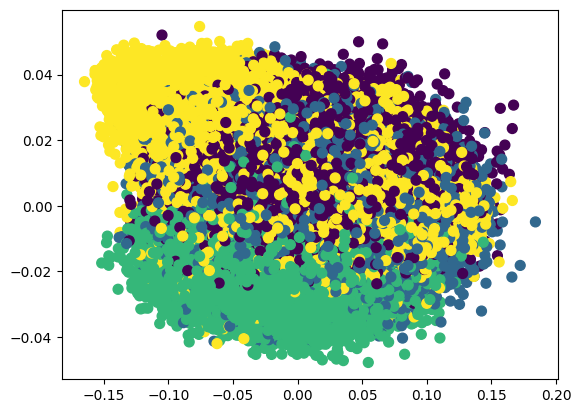

In [8]:
kmeans = KMeans(n_clusters=4, random_state=20).fit(data)
cc=kmeans.fit_predict(data)

plt.scatter(data[:, 0], data[:, 1], c=cc, s=50, cmap='viridis')

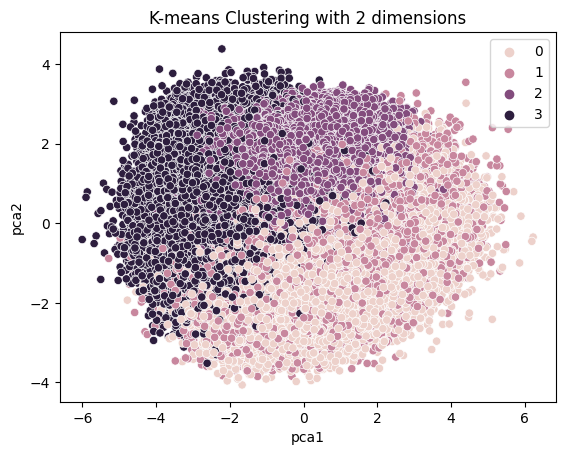

In [9]:
# let do PCA on the clusters
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=cc, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [10]:
# t-sne fit function with dimentionality reduction
from sklearn.manifold import TSNE
import time
RS = 123
time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(reduced_data)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 6197.656620025635 seconds


/home/ubuntu/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


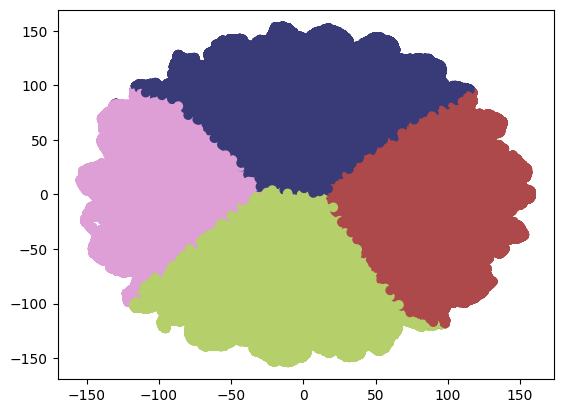

In [12]:
plt.scatter(fashion_pca_tsne[:,0], fashion_pca_tsne[:,1], c = kmeans.fit_predict(fashion_pca_tsne),cmap="tab20b")

In [ ]:
## HEATMAP VISUALIZATION

In [ ]:
# load the 7th encoder layer
import numpy as np
data_array = np.load('/home/ubuntu/layerwise-analysis/save_dir_pth_500_samples/wav2vec_base/librispeech_dev-clean_sample1/local/frame_level/layer_7.npy')

In [ ]:
print("### encoder  7th  layer data points  ###")
print("\nData summary:\n", data_array)
print("\nData shape:\n", data_array.shape)

In [14]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
X=np.load('/home/ubuntu/layerwise-analysis/save_dir_pth/wav2vec_base/librispeech_dev-clean_sample1/local/frame_level/layer_7.npy')

In [9]:
print(X[0])
print(X.shape)

[ 3.72694060e-03 -1.75185339e-03 -4.83171170e-04 -8.08497425e-03
 -2.66070142e-02  7.04477727e-03 -5.22053342e-05  7.06435472e-04
 -1.36714114e-03  5.09660924e-03 -2.36195121e-02  6.58930396e-04
 -5.66975866e-03  1.69588218e-03 -2.04564463e-02  4.78183245e-03
 -2.01610569e-02  1.06035247e-02  3.02198553e-03  2.69596428e-02
  1.25330524e-03 -1.13519672e-02  1.59844086e-02 -1.15319416e-02
  2.20549665e-02  1.44723279e-03 -1.24365775e-04  2.87231337e-02
  7.08587992e-04  1.08887171e-02  4.31981543e-03  2.27333959e-02
 -2.29990091e-02  2.00731810e-02 -1.73495673e-02 -4.83295834e-03
  3.74143856e-04 -1.65963974e-02  3.20980251e-02 -1.26169678e-02
 -3.62629257e-02  4.50528180e-03 -3.76118384e-02 -4.28624247e-04
 -4.34130523e-03  4.92484309e-03 -3.29142287e-02  2.77811172e-03
  5.72408997e-02  2.15192209e-03 -1.61965960e-03 -1.95525177e-02
 -5.85340941e-03 -3.08003668e-02  1.73580889e-02  6.86472934e-03
  2.80042674e-04 -9.44167189e-03 -3.44157703e-02 -6.58261310e-03
 -2.06079613e-02  4.66361

In [ ]:
#converting the list into array cause the list was giving bad results
data =np.array(X)

In [ ]:
x_subset = data[0:1000]

In [ ]:
print("\nData summary:\n", x_subset)
print("\nData shape:\n", x_subset.shape)

In [ ]:
numpy.savetxt("data3.csv", data, delimiter = " ")

In [ ]:
data= pd.read_csv("data3.csv")


In [ ]:
plt.figure(figsize=(200,195))
sns.set_theme(context='paper', style='ticks',font_scale=2)
sns.heatmap(data)

In [ ]:
!{sys.executable} -m pip install fastcluster

In [1]:
##Deploying Models to the hub

In [5]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/ubuntu/.huggingface/token
Login successful


In [6]:
from transformers import Wav2Vec2Config
from huggingface_hub import create_repo, Repository

import logging
import sys
import gradio as gr
from transformers import pipeline, AutoModelForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM

In [7]:
repo_url = create_repo("congowav2vec-multilingual_pretrained")
repo = Repository(local_dir="model_output/multilingual/hf2", clone_from=repo_url)

Cloning https://huggingface.co/Ussen/congowav2vec-multilingual_pretrained into local empty directory.


In [10]:
config = Wav2Vec2Config.from_pretrained('facebook/wav2vec2-base')
#facebook/wav2vec2-base
config.save_pretrained('model_output/multilingual/hf2');

In [12]:
!python workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py \
    --pytorch_dump_folder ${PWD}"/model_output/multilingual/hf" \
    --checkpoint_path ${PWD}"/model_output/multilingual/new_checkpoint.pt" \
    --config_path ${PWD}"/model_output/multilingual/hf/config.json" \
    --dict_path ${PWD}"/model_output/multilingual/dict.ltr.txt"


Traceback (most recent call last):
  File "/home/ubuntu/lingWav2Vec/workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py", line 24, in <module>
    import fairseq
ModuleNotFoundError: No module named 'fairseq'


In [ ]:
python workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py --pytorch_dump_folder ${PWD}"/model_output/multilingual/hf" --checkpoint_path ${PWD}"/model_output/multilingual/new_checkpoint.pt" --config_path ${PWD}"/model_output/multilingual/hf/config.json" --dict_path ${PWD}"/model_output/multilingual/dict.ltr.txt"

In [ ]:
python workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py --pytorch_dump_folder /home/ubuntu/lingWav2Vec/model_output/multilingual/hf --checkpoint_path /home/ubuntu/lingWav2Vec/model_output/multilingual/finetuned_on_lingala/checkpoint_best.pt --config_path /home/ubuntu/lingWav2Vec/model_output/multilingual/hf/config.json --dict_path /home/ubuntu/lingWav2Vec/model_output/multilingual/dict.ltr.txt --lm_path /home/ubuntu/lingWav2Vec/lm_data/lingala/lm.binary --lexicon_path /home/ubuntu/lingWav2Vec/lm_data/lingala/lexicon.lst --alpha 0.5 --beta 1.5 --with_LM

In [11]:
cd model_output/multilingual/hf2/

/home/ubuntu/lingWav2Vec/model_output/multilingual/hf2


In [15]:
!huggingface-cli lfs-enable-largefiles .
!git lfs track "*.binary"
!git add .
!git commit -m "cdwav2vec2.0"
!git push origin main

Local repo set up for largefiles
Tracking "*.binary"
[main 4bd5108] cdwav2vec2.0
 7 files changed, 197 insertions(+)
 create mode 100644 config.json
 create mode 100644 preprocessor_config.json
 create mode 100644 pytorch_model.bin
 create mode 100644 special_tokens_map.json
 create mode 100644 tokenizer_config.json
 create mode 100644 vocab.json
Uploading LFS objects: 100% (1/1), 378 MB | 102 MB/s, done.                     
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 4 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 2.02 KiB | 2.02 MiB/s, done.
Total 9 (delta 1), reused 0 (delta 0)
remote: Scanning LFS files for validity, may be slow...
remote: LFS file scan complete.
To https://huggingface.co/Ussen/congowav2vec-multilingual
   9a405a5..4bd5108  main -> main
